In [2]:
#!!! temp - erase

import pandas as pd
from varseek.utils import add_vcrs_variant_type
unique_mcrs_df = pd.read_csv('/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.csv')

if "DP_varseek" in unique_mcrs_df.columns:
    unique_mcrs_df.rename(columns={"DP_varseek": "AD_ALT_varseek"}, inplace=True)

if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

unique_mcrs_df.to_parquet('/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.parquet')
!cp '/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/unique_mcrs_df.parquet' '/data/Fig2/unique_mcrs_df.parquet'

# Synthetic data aggregate notebook

## How did we make this file? Run the commands below:
```bash
### Prep:
gget ref -w dna,gtf,cds,cdna -r 93 --out_dir data/reference/ensembl_grch37_release93 -d human_grch37
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cds.all.fa.gz
gunzip data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa.gz
wget -O data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf.gz
STAR --runMode genomeGenerate --genomeDir data/reference/ensembl_grch37_release93/star_reference --genomeFastaFiles data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --sjdbGTFfile data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf --sjdbOverhang 149
gget cosmic -d -cv 101 -gv 37 -o data/reference -mc cancer None
python -c "varseek.utils.convert_mutation_cds_locations_to_cdna(input_csv_path=data/reference/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv, output_csv_path=data/reference/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv, cds_fasta_path=data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cds.all.fa, cdna_fasta_path=data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa, strip_leading_Ns_cds=True)"
```
### Data generation
```bash
jupyter nbconvert --to notebook --execute --output Fig2_variant_simulation_output.ipynb notebooks/Fig2_variant_simulation.ipynb

python scripts/run_gatk_haplotypecaller_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--genomes1000_vcf data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--java /home/jmrich/opt/jdk-17.0.12+7/bin/java \
--picard_jar /home/jmrich/opt/picard.jar \
--disable_tool_default_read_filters \
--threads 4

python scripts/run_gatk_mutect2_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--genomes1000_vcf data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--java /home/jmrich/opt/jdk-17.0.12+7/bin/java \
--picard_jar /home/jmrich/opt/picard.jar \
--disable_tool_default_read_filters \
--threads 4

python scripts/run_strelka_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--STRELKA_INSTALL_PATH /home/jmrich/opt/strelka-2.9.10.centos6_x86_64 \
--python2_env python2_env \
--threads 4


python scripts/run_varscan_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--VARSCAN_INSTALL_PATH /home/jmrich/opt/VarScan.v2.3.9.jar \
--threads 4


python scripts/run_deepvariant_for_benchmarking.py \
--synthetic_read_fastq data/simulated_data_output/synthetic_reads.fq \
--unique_mcrs_df_path data/simulated_data_output/unique_mcrs_df.csv \
--out data/variant_simulation_alternative_tools \
--reference_genome_fasta data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa \
--reference_genome_gtf data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf \
--star_genome_dir data/reference/ensembl_grch37_release93/star_reference \
--cosmic_vcf data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz \
--model_dir data/benchmarking_tmp/deepvariant_model \
--read_length 150 \
--threads 4
```

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import os
import subprocess
import pandas as pd
import re
from scipy.optimize import curve_fit
from scipy.stats import linregress
from tqdm import tqdm
import numpy as np
import varseek as vk
from collections import OrderedDict
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

from RLSRWP_2025 import create_stratified_metric_bar_plot_updated, plot_overall_metrics, create_stratified_metric_line_plot, create_benchmarking_legend, plot_frequency_histogram, plot_time_and_memory_benchmarking, print_json, plot_precision_stratified_by_ad_alt, plot_recall_stratified_by_depth, plot_recall_stratified_by_tumor_purity
from varseek.utils import calculate_metrics, draw_confusion_matrix, find_specific_value_from_metric_text_file, color_map_20, add_vcrs_variant_type

varseek_directory = os.path.dirname(os.path.abspath(""))

Make sure to change any arguments in 2_variant_simulation.ipynb and any notebooks/scripts for tools I am benchmarking

In [3]:
tools = ["varseek", "gatk_mutect2", "gatk_haplotypecaller", "strelka2", "varscan", "deepvariant"]  # Ensure that any additional tools have columns mutation_detected_{tool} (bool) in unique_mcrs_df_path for each tool TOOL
fig2_output_dir = os.path.join(varseek_directory, "data", "Fig2")

unique_mcrs_df_path = os.path.join(fig2_output_dir, 'unique_mcrs_df.parquet')
variant_calling_stats_file = os.path.join(fig2_output_dir, "time_and_memory_benchmarking_report.txt")
STAR_stats_file = os.path.join(fig2_output_dir, "STAR_time_and_memory.txt")
hap_py_folder = os.path.join(varseek_directory, "data" "variant_simulation_alternative_tools", "hap_py_out")

This synthetic dataset has 30,174,400 reads and 381,837 variants

In [ ]:
unique_mcrs_df_url = "https://caltech.box.com/shared/static/8r5hm12muvphr9msui6u5uiip2bq16nm.parquet"
time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/sb9zr167i86ddf4e5h0rpi2wy2ptyula.txt"
STAR_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/992hmlis9jc6pz6s6u1xneiel0lzvbnn.txt"
happy_url = "https://caltech.box.com/shared/static/ganiusile1is2kazgvjg02w7n533ifu4.gz"

os.makedirs(fig2_output_dir, exist_ok=True)

if not os.path.isfile(unique_mcrs_df_path):
    subprocess.run(["wget", unique_mcrs_df_url, "-O", unique_mcrs_df_path])

if not os.path.isfile(variant_calling_stats_file):
    subprocess.run(["wget", time_and_memory_benchmarking_stat_url, "-O", variant_calling_stats_file])

if not os.path.isfile(STAR_stats_file):
    subprocess.run(["wget", STAR_time_and_memory_benchmarking_stat_url, "-O", STAR_stats_file])

if not os.path.exists(hap_py_folder):
    hap_py_tarball = os.path.join(fig2_output_dir, "hap_py_out.tar")
    hap_py_folder = os.path.join(fig2_output_dir, "hap_py_out")
    subprocess.run(["wget", happy_url, "-O", hap_py_tarball])
    subprocess.run(["tar", "-xzf", hap_py_tarball, "-C", fig2_output_dir])

# Generate plots for Fig 2

In [4]:
if unique_mcrs_df_path.endswith(".csv"):
    unique_mcrs_df = pd.read_csv(unique_mcrs_df_path)
elif unique_mcrs_df_path.endswith(".parquet"):
    unique_mcrs_df = pd.read_parquet(unique_mcrs_df_path)
else:
    raise ValueError("unique_mcrs_df_path must be a .csv or .parquet file")

In [30]:
if 'included_in_synthetic_reads_mutant' not in unique_mcrs_df.columns:
    unique_mcrs_df['included_in_synthetic_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'] > 0

fp_including_noncosmic_dict = {}
for tool in tools:
    assert f'mutation_detected_{tool}' in unique_mcrs_df.columns, f"mutation_detected_{tool} must be in unique_mcrs_df.columns"
    if f'TP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TP_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'TN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'TN_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FP_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FP_{tool}'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'FN_{tool}' not in unique_mcrs_df.columns:
        unique_mcrs_df[f'FN_{tool}'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df[f'mutation_detected_{tool}'])
    if f'mutation_expression_prediction_error_{tool}' not in unique_mcrs_df.columns and f'AD_ALT_{tool}' in unique_mcrs_df.columns:
        unique_mcrs_df[f'mutation_expression_prediction_error_{tool}'] = unique_mcrs_df[f'AD_ALT_{tool}'] - unique_mcrs_df['number_of_reads_mutant']

    assert unique_mcrs_df.loc[unique_mcrs_df[f'TP_{tool}'], f'mutation_detected_{tool}'].all(), (f"Some rows where TP_{tool}=True do not have mutation_detected_{tool}=True")
    assert unique_mcrs_df.loc[unique_mcrs_df[f'FP_{tool}'], f'mutation_detected_{tool}'].all(), (f"Some rows where FP_{tool}=True do not have mutation_detected_{tool}=True")
    assert (~unique_mcrs_df.loc[unique_mcrs_df[f'TN_{tool}'], f'mutation_detected_{tool}']).all(), (f"Some rows where TN_{tool}=True do not have mutation_detected_{tool}=False")
    assert (~unique_mcrs_df.loc[unique_mcrs_df[f'FN_{tool}'], f'mutation_detected_{tool}']).all(), (f"Some rows where FN_{tool}=True do not have mutation_detected_{tool}=False")

    reference_metrics_out = os.path.join(fig2_output_dir, f"reference_metrics_{tool}.txt")
    if not os.path.exists(reference_metrics_out):
        calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", check_assertions = False, out = reference_metrics_out, suffix = f"_{tool}")
    fp_including_noncosmic_dict[tool] = find_specific_value_from_metric_text_file(reference_metrics_out, line = "FP including non-cosmic:")

TP: 380847, FP: 116405, FN: 990, TN: 4831249
Accuracy: 0.9779725681120393, Sensitivity: 0.9974072706416612, Specificity: 0.9764726878637835
Mean Expression Error: -0.7157236169990266, Median Expression Error: 0.0, Mean Magnitude Expression Error: 1.237370588755802, Median Magnitude Expression Error: 1.0
TP: 228985, FP: 476, FN: 152852, TN: 4947178
Accuracy: 0.9712302732099557, Sensitivity: 0.5996930627466693, Specificity: 0.9999037927874503
Mean Expression Error: -16.180816107452838, Median Expression Error: -1.0, Mean Magnitude Expression Error: 16.395660692700766, Median Magnitude Expression Error: 1.0
TP: 143303, FP: 2699, FN: 238534, TN: 4944955
Accuracy: 0.9547362027630781, Sensitivity: 0.3752988840788085, Specificity: 0.9994544889355642
Mean Expression Error: -21.858059122617075, Median Expression Error: -2.0, Mean Magnitude Expression Error: 24.621582359148658, Median Magnitude Expression Error: 3.0
TP: 264283, FP: 20473, FN: 117554, TN: 4927181
Accuracy: 0.9741012790902546, Sen

### Add my own precision to include non-cosmic

In [31]:
precision_stats_dict = {}
if os.path.exists(hap_py_folder):
    for tool in tools:
        if tool == "varseek":
            if "vcrs_variant_type" not in unique_mcrs_df.columns:
                unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")
            
            sub_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "substitution"]
            indel_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] != "substitution"]

            indel_tp = indel_df["TP_varseek"].sum()
            snp_tp = sub_df["TP_varseek"].sum()
            indel_fp = indel_df["FP_varseek"].sum()
            snp_fp = sub_df["FP_varseek"].sum()
        else:
            file_path = os.path.join(hap_py_folder, tool, "happy.summary.csv")
            df = pd.read_csv(file_path)

            # Select rows
            indel_all = df[(df["Type"] == "INDEL") & (df["Filter"] == "ALL")]
            snp_all = df[(df["Type"] == "SNP") & (df["Filter"] == "ALL")]

            # Extract values
            indel_tp = indel_all["TRUTH.TP"].values[0]
            snp_tp = snp_all["TRUTH.TP"].values[0]
            indel_fp = indel_all["QUERY.FP"].values[0]
            snp_fp = snp_all["QUERY.FP"].values[0]

        total_tp = indel_tp + snp_tp
        total_fp = indel_fp + snp_fp

        indel_precision = indel_tp / (indel_tp + indel_fp) if (indel_tp + indel_fp) > 0 else 0
        snp_precision = snp_tp / (snp_tp + snp_fp) if (snp_tp + snp_fp) > 0 else 0
        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

        # Store in nested dict
        precision_stats_dict[tool] = {
            "tp_indel": indel_tp,
            "tp_sub": snp_tp,
            "fp_indel": indel_fp,
            "fp_sub": snp_fp,
            "total_tp": total_tp,
            "total_fp": total_fp,
            "indel_precision": indel_precision,
            "snp_precision": snp_precision,
            "precision": precision
        }

    # for tool in tools:
    #     metric_dict_collection[tool]['precision'] = precision_stats_dict[tool]['precision']

varseek
TP: 380847, FP: 116405, FN: 990, TN: 4831249
Accuracy: 0.9779725681120393, Sensitivity: 0.9974072706416612, Specificity: 0.9764726878637835
Mean Expression Error: -0.7157236169990266, Median Expression Error: 0.0, Mean Magnitude Expression Error: 1.237370588755802, Median Magnitude Expression Error: 1.0


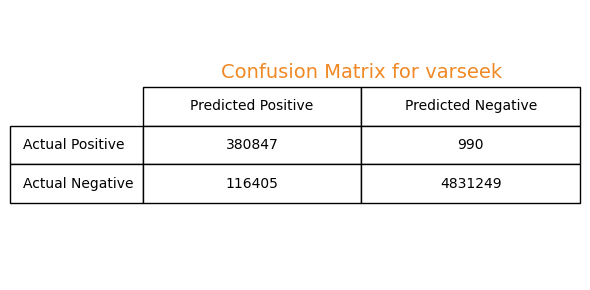

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_mutect2
TP: 228985, FP: 476, FN: 152852, TN: 4947178
Accuracy: 0.9712302732099557, Sensitivity: 0.5996930627466693, Specificity: 0.9999037927874503
Mean Expression Error: -16.180816107452838, Median Expression Error: -1.0, Mean Magnitude Expression Error: 16.395660692700766, Median Magnitude Expression Error: 1.0


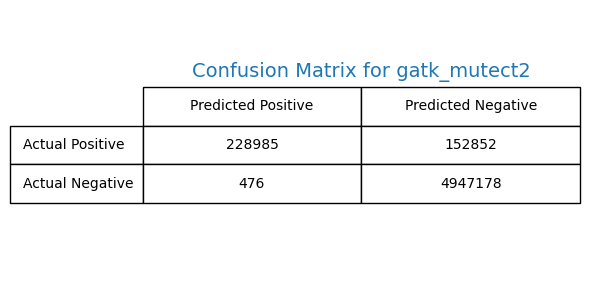

-------------------------------------------------------------------------------------------------------------------------------------------------------
gatk_haplotypecaller
TP: 143303, FP: 2699, FN: 238534, TN: 4944955
Accuracy: 0.9547362027630781, Sensitivity: 0.3752988840788085, Specificity: 0.9994544889355642
Mean Expression Error: -21.858059122617075, Median Expression Error: -2.0, Mean Magnitude Expression Error: 24.621582359148658, Median Magnitude Expression Error: 3.0


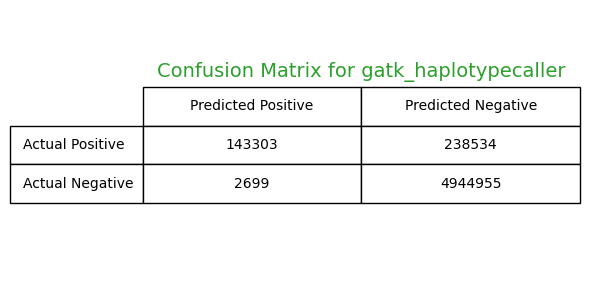

-------------------------------------------------------------------------------------------------------------------------------------------------------
strelka2
TP: 264283, FP: 20473, FN: 117554, TN: 4927181
Accuracy: 0.9741012790902546, Sensitivity: 0.6921356495048935, Specificity: 0.9958620792804024
Mean Expression Error: 0.27681045273624844, Median Expression Error: 0.0, Mean Magnitude Expression Error: 1.944396000056258, Median Magnitude Expression Error: 0.0


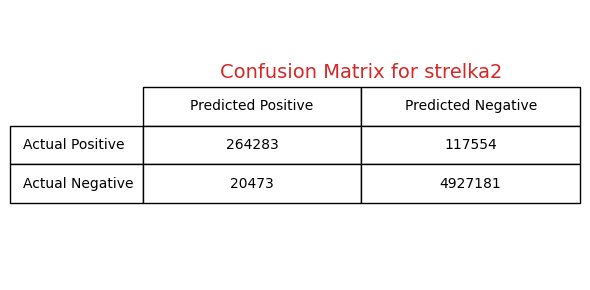

-------------------------------------------------------------------------------------------------------------------------------------------------------
varscan
TP: 191368, FP: 4614, FN: 190469, TN: 4943040
Accuracy: 0.9633955662932914, Sensitivity: 0.5011772038854275, Specificity: 0.9990674368094454
Mean Expression Error: -0.7273391588737289, Median Expression Error: 0.0, Mean Magnitude Expression Error: 4.079079155807655, Median Magnitude Expression Error: 0.0


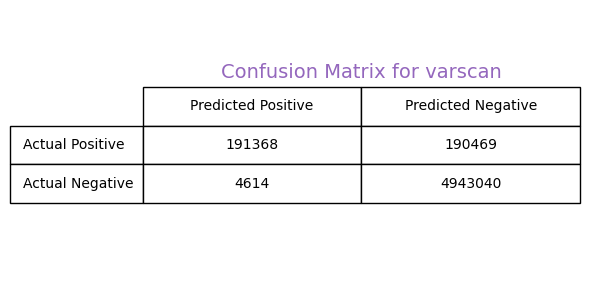

-------------------------------------------------------------------------------------------------------------------------------------------------------
deepvariant
TP: 152087, FP: 2688, FN: 229750, TN: 4944966
Accuracy: 0.9563864541660733, Sensitivity: 0.39830346456734156, Specificity: 0.9994567122114845
Mean Expression Error: -2.49520909302506, Median Expression Error: 0.0, Mean Magnitude Expression Error: 6.113009801639641, Median Magnitude Expression Error: 0.0


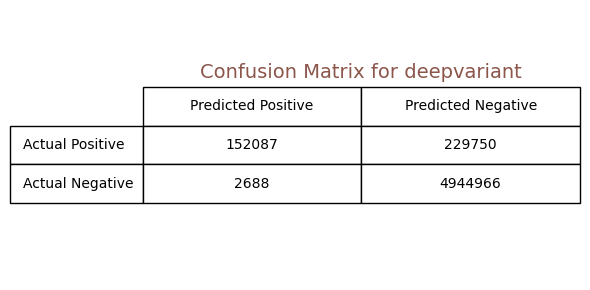

-------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
update_precision_and_f1 = True

metric_dict_collection = OrderedDict()
for index, tool in enumerate(tools):
    print(tool)
    metric_dict_collection[tool] = calculate_metrics(unique_mcrs_df, header_name = "vcrs_header", suffix=f"_{tool}")  # out = f"{fig2_output_dir}/reference_metrics_{tool}.txt"
    if tool != "varseek":
        if fp_including_noncosmic_dict.get(tool, None) is not None:
            metric_dict_collection[tool]["FP including non-cosmic"] = fp_including_noncosmic_dict[tool]
        elif precision_stats_dict.get(tool, {}).get('total_fp', None) is not None:
            metric_dict_collection[tool]["FP including non-cosmic"] = precision_stats_dict[tool]['total_fp']
            if update_precision_and_f1:
                metric_dict_collection[tool]['precision'] = precision_stats_dict[tool]['precision']  #* optional

                precision = metric_dict_collection[tool]['precision']
                recall = metric_dict_collection[tool]['recall']
                metric_dict_collection[tool]['f1_score'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    draw_confusion_matrix(metric_dict_collection[tool], title = f"Confusion Matrix for {tool}", title_color = color_map_20[index], additional_fp_key = "FP including non-cosmic", output_file=f"{fig2_output_dir}/confusion_matrix_{tool}.pdf")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")

# Create legend

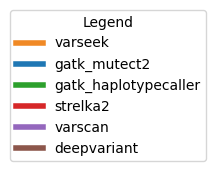

In [6]:
create_benchmarking_legend(tools, f"{fig2_output_dir}/legend.pdf")

# Bar plot of various metrics

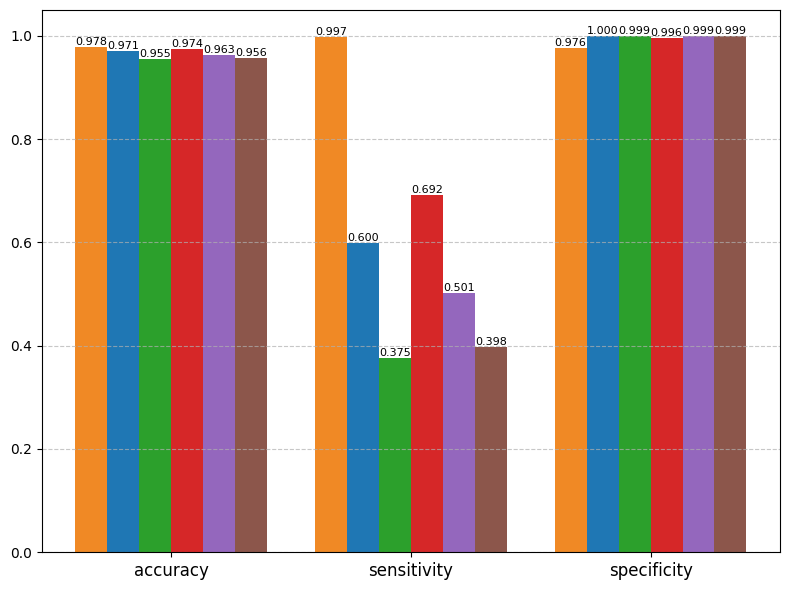

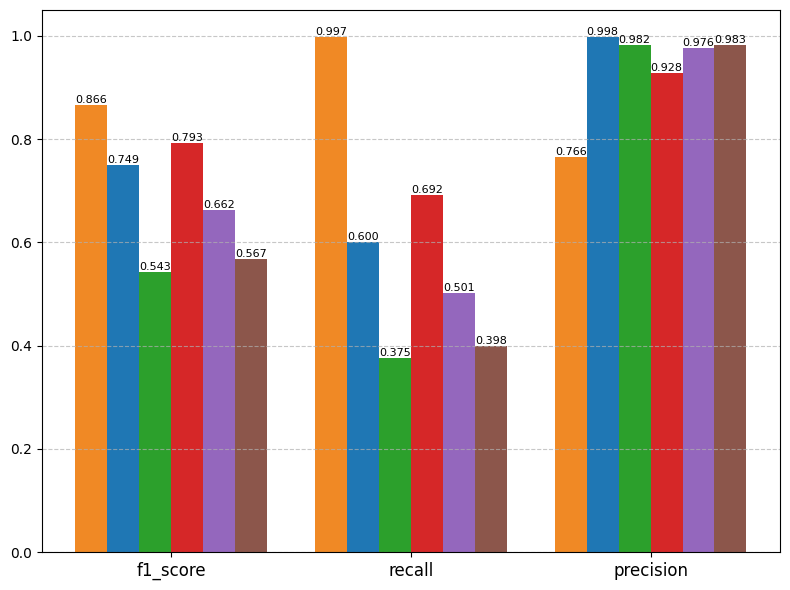

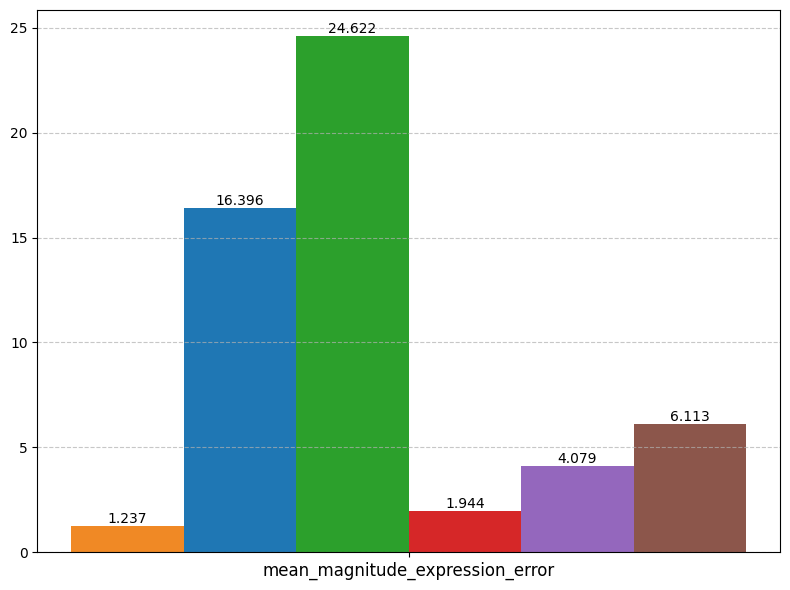

In [33]:
# plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], secondary_metric = "mean_magnitude_expression_error", display_numbers=True, output_file = f"{fig2_output_dir}/overall_metrics.pdf")
plot_overall_metrics(metric_dict_collection, primary_metrics = ["accuracy", "sensitivity", "specificity"], display_numbers=True, display_numbers_fontsize=8, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_accuracy_sensitivity_specificity.pdf")  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json"
plot_overall_metrics(metric_dict_collection, primary_metrics = ["f1_score", "recall", "precision"], display_numbers=True, display_numbers_fontsize=8, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_f1_recall_precision.pdf")  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json"
# print_json(f"{fig2_output_dir}/overall_metrics_acc_sens_spec_p_values.json")

plot_overall_metrics(metric_dict_collection, primary_metrics = "mean_magnitude_expression_error", display_numbers=True, display_numbers_fontsize=10, show_p_values = False, unique_mcrs_df = unique_mcrs_df, output_file = f"{fig2_output_dir}/overall_metrics_error.pdf", filter_real_negatives = True)  # output_file_p_values = f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json"
# print_json(f"{fig2_output_dir}/overall_metrics_expression_error_p_values.json")

# Number of detected reads for false positives

Text(0.5, 1.0, 'Histogram of AD_ALT_varseek where FP_varseek=True')

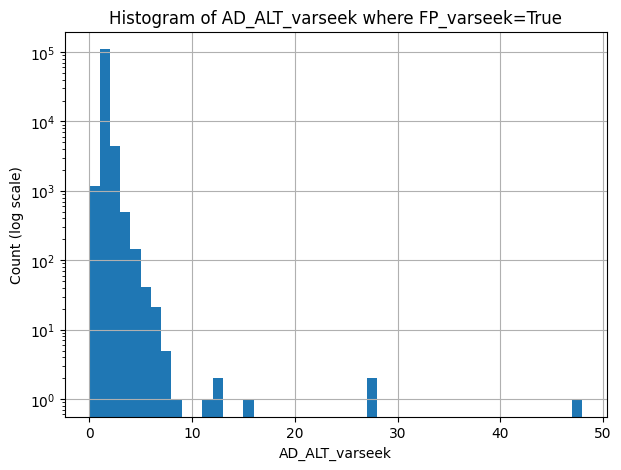

In [7]:
fp_df = unique_mcrs_df.loc[unique_mcrs_df["FP_varseek"], ["AD_ALT_varseek"]]

# hist() returns a 1-element array of Axes
axes = fp_df.hist(
    bins=range(
        int(fp_df["AD_ALT_varseek"].min()),
        int(fp_df["AD_ALT_varseek"].max()) + 2
    ),
    figsize=(7,5)
)

# Get the first Axes object
ax = axes[0,0]

# Now set scales and labels
ax.set_yscale("log")
ax.set_xlabel("AD_ALT_varseek")
ax.set_ylabel("Count (log scale)")
ax.set_title("Histogram of AD_ALT_varseek where FP_varseek=True")


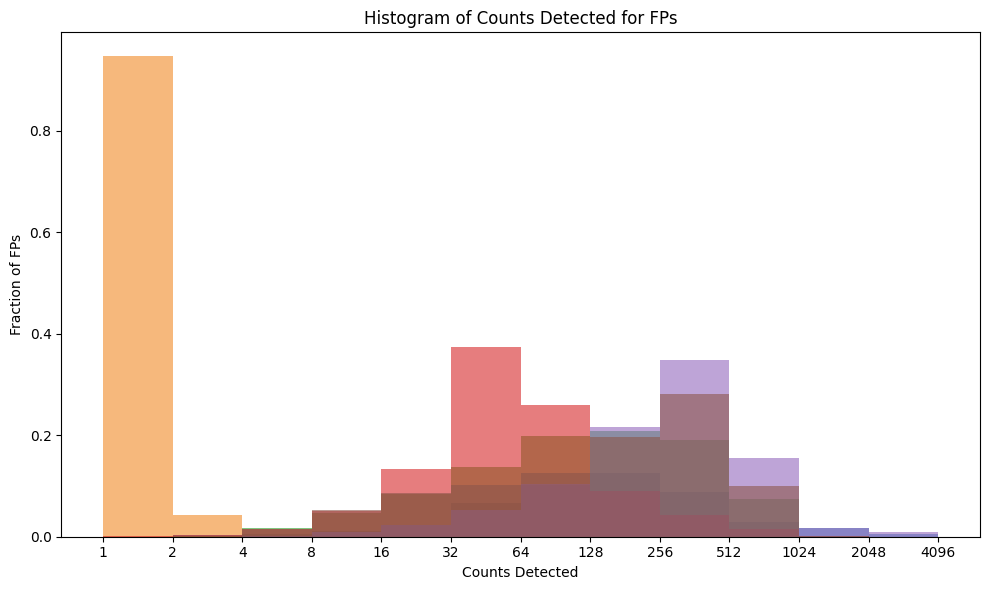

In [ ]:
plot_frequency_histogram(unique_mcrs_df, 'AD_ALT', tools, fraction=True, output_file = f"{fig2_output_dir}/AD_ALT_histogram.pdf")

# Stratified metric line plots

In [5]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

substitution_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "substitution"]
indel_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] != "substitution"]
insertion_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"].isin(["insertion", "duplication"])]
deletion_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"] == "deletion"]
delins_df = unique_mcrs_df.loc[unique_mcrs_df["vcrs_variant_type"].isin(["delins", "inversion"])]

### Recall

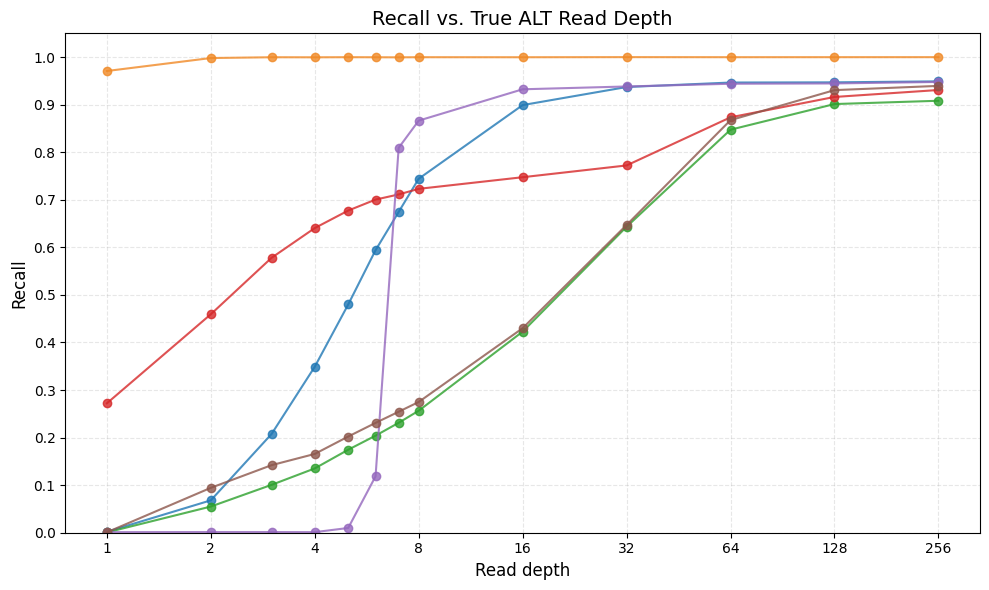

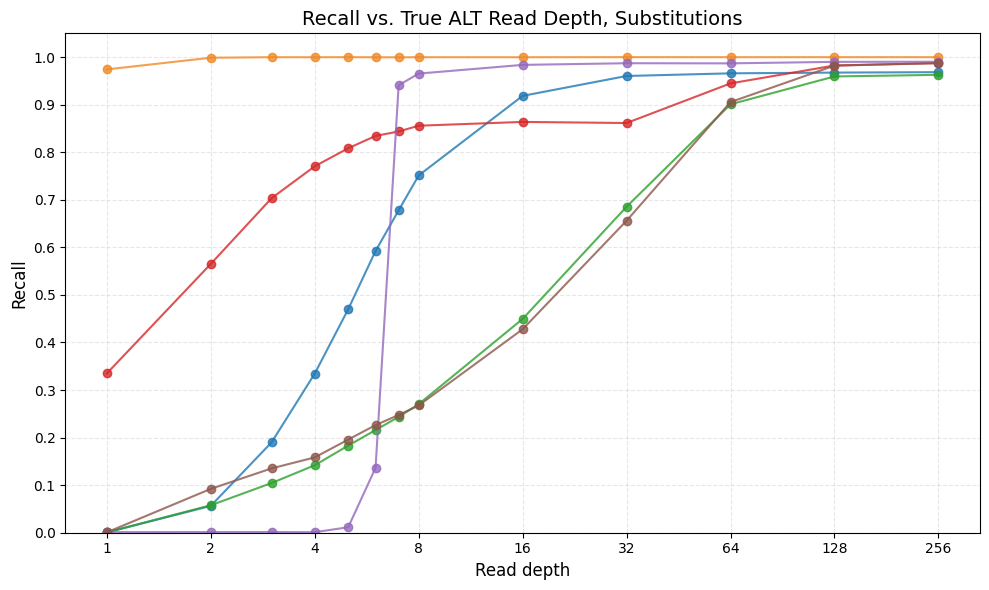

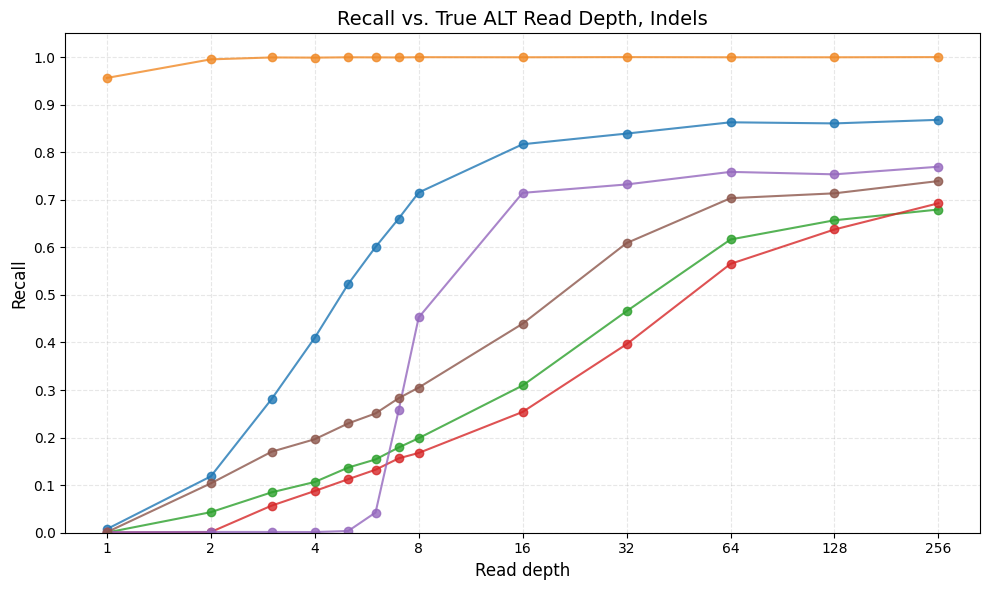

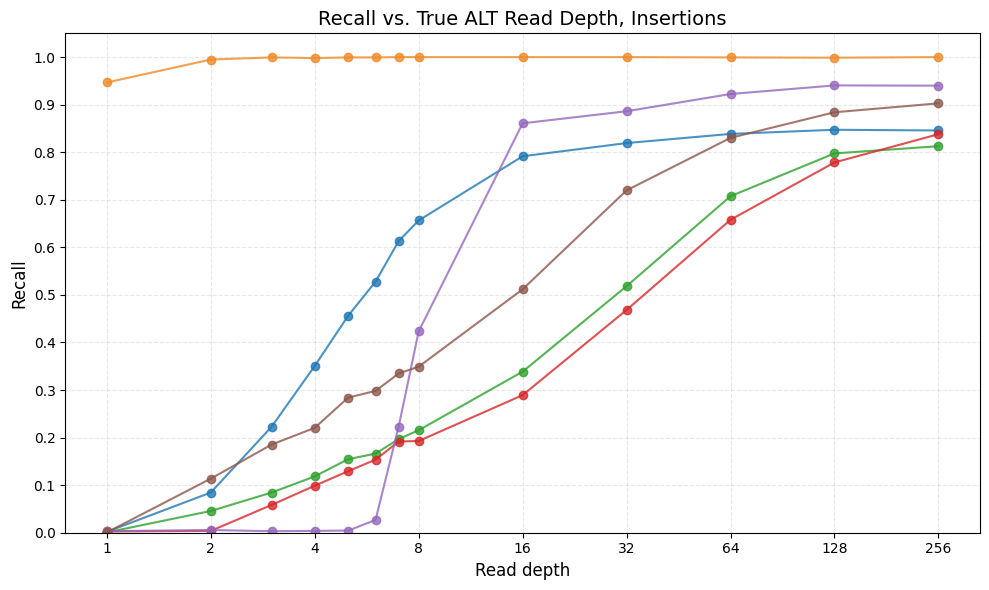

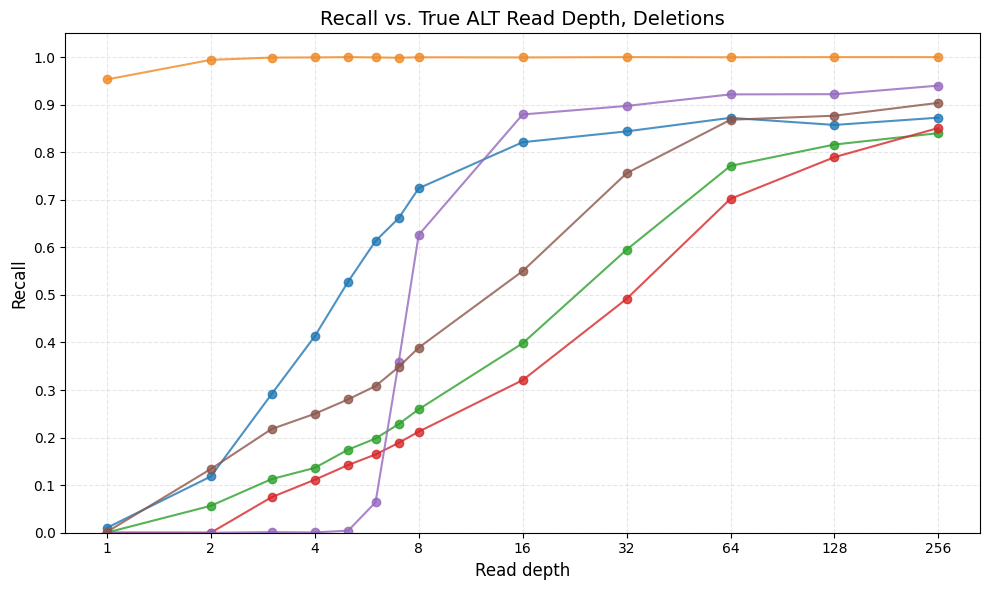

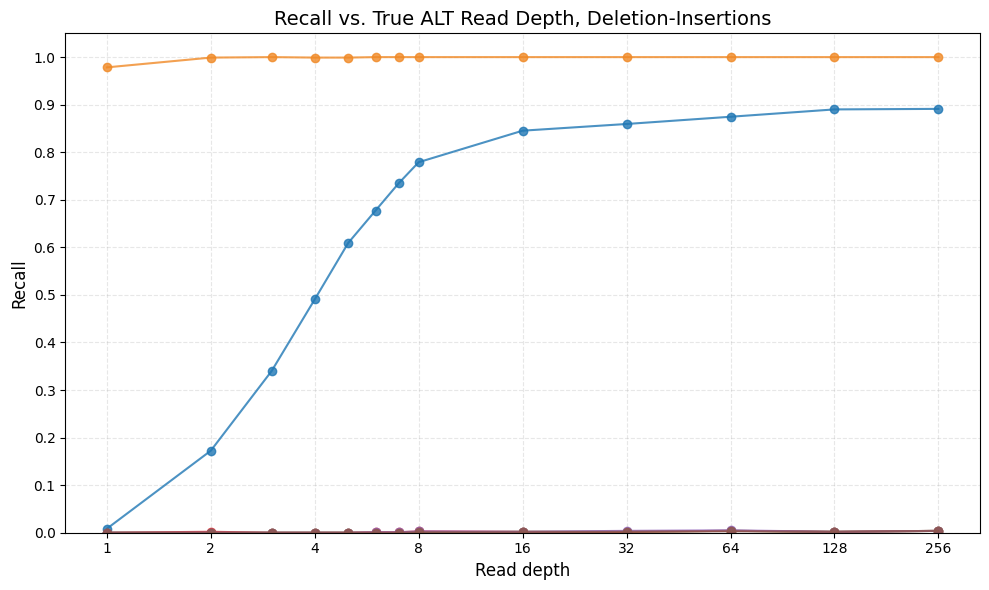

In [62]:
true_alt_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256]
x_log = True

plot_recall_stratified_by_depth(unique_mcrs_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth", output_file = f"{fig2_output_dir}/recall_vs_depth.pdf")
plot_recall_stratified_by_depth(substitution_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth, Substitutions", output_file = f"{fig2_output_dir}/recall_vs_depth_substitution_only.pdf")
plot_recall_stratified_by_depth(indel_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth, Indels", output_file = f"{fig2_output_dir}/recall_vs_depth_indel_only.pdf")
plot_recall_stratified_by_depth(insertion_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth, Insertions", output_file = f"{fig2_output_dir}/recall_vs_depth_insertion_only.pdf")
plot_recall_stratified_by_depth(deletion_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth, Deletions", output_file = f"{fig2_output_dir}/recall_vs_depth_deletion_only.pdf")
plot_recall_stratified_by_depth(delins_df, depth_values = true_alt_depth_values, tools = tools, x_log = x_log, title = "Recall vs. True ALT Read Depth, Deletion-Insertions", output_file = f"{fig2_output_dir}/recall_vs_depth_delins_only.pdf")

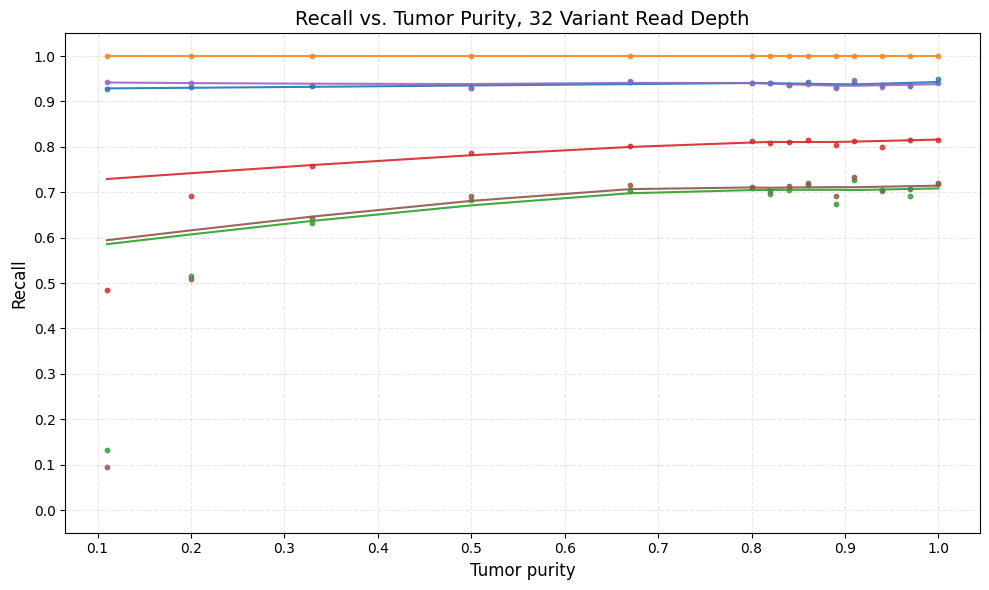

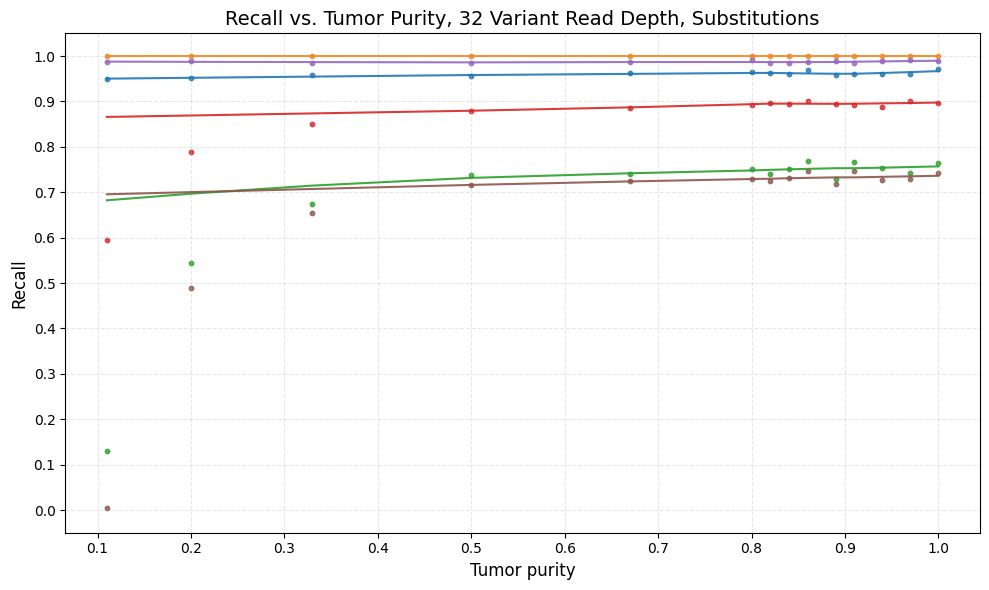

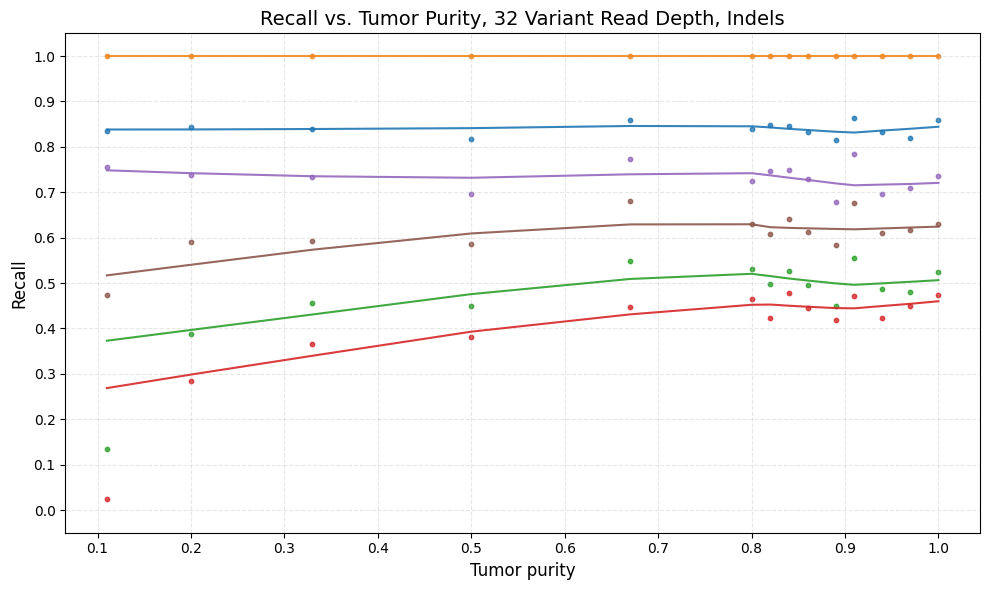

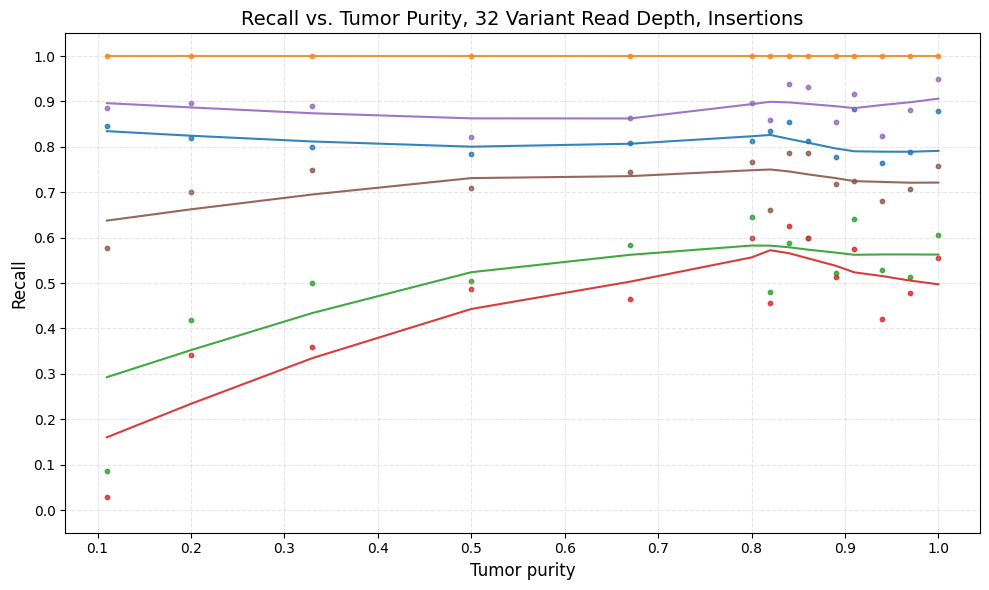

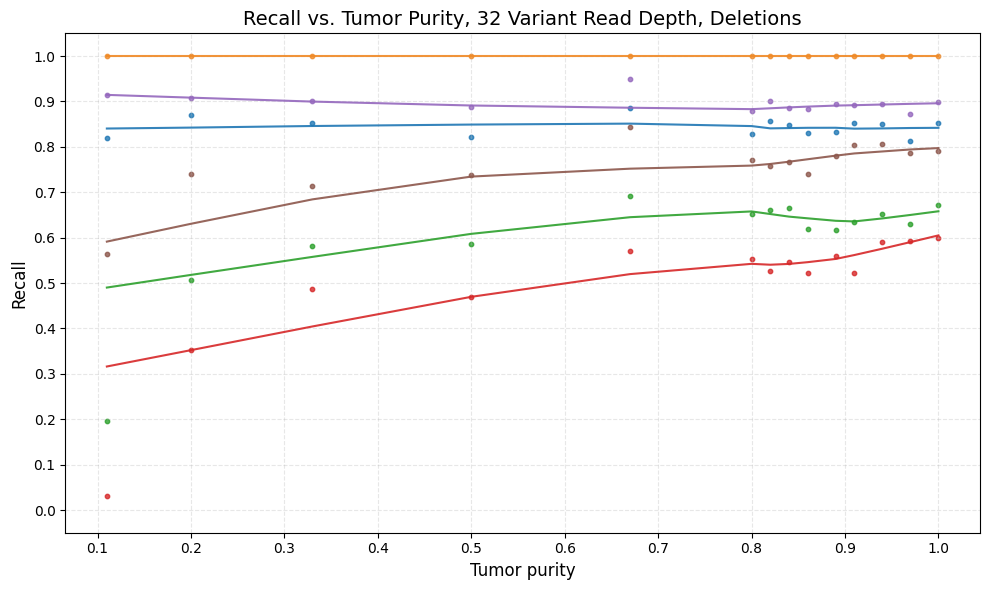

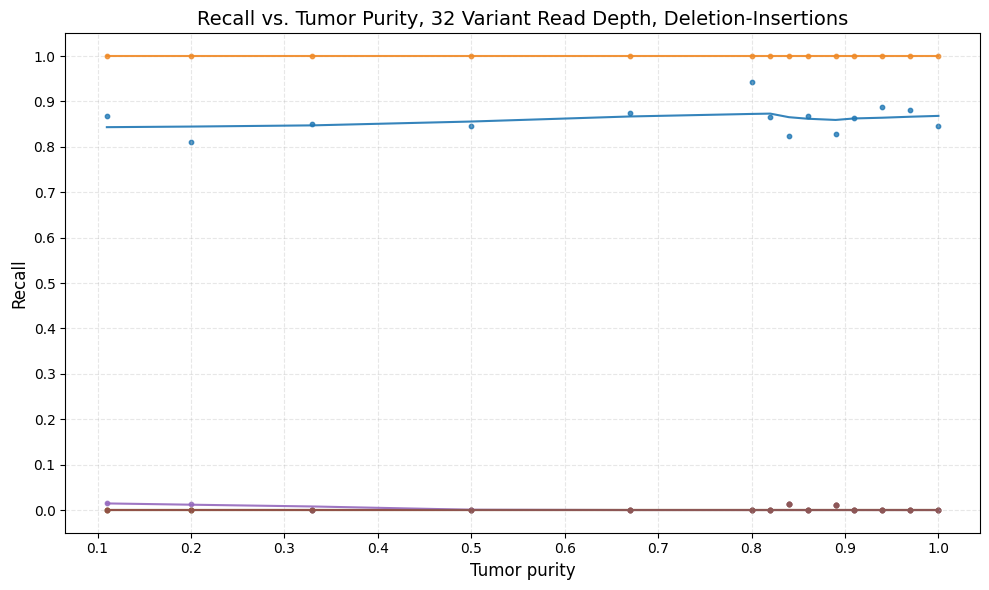

In [70]:
bins = None  # [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
number_of_reads_mutant = 32
fit_lowess = True
lowess_frac = 0.7
title_base = f"Recall vs. Tumor Purity, {number_of_reads_mutant} Variant Read Depth" if number_of_reads_mutant else "Recall vs. Tumor Purity"

plot_recall_stratified_by_tumor_purity(unique_mcrs_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}", output_file = f"{fig2_output_dir}/recall_vs_purity.pdf")
plot_recall_stratified_by_tumor_purity(substitution_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}, Substitutions", output_file = f"{fig2_output_dir}/recall_vs_purity_substitution_only.pdf")
plot_recall_stratified_by_tumor_purity(indel_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}, Indels", output_file = f"{fig2_output_dir}/recall_vs_purity_indel_only.pdf")
plot_recall_stratified_by_tumor_purity(insertion_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}, Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_insertion_only.pdf")
plot_recall_stratified_by_tumor_purity(deletion_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}, Deletions", output_file = f"{fig2_output_dir}/recall_vs_purity_deletion_only.pdf")
plot_recall_stratified_by_tumor_purity(delins_df, bins = bins, tools = tools, number_of_reads_mutant = number_of_reads_mutant, fit_lowess = fit_lowess, lowess_frac = lowess_frac, title = f"{title_base}, Deletion-Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_delins_only.pdf")

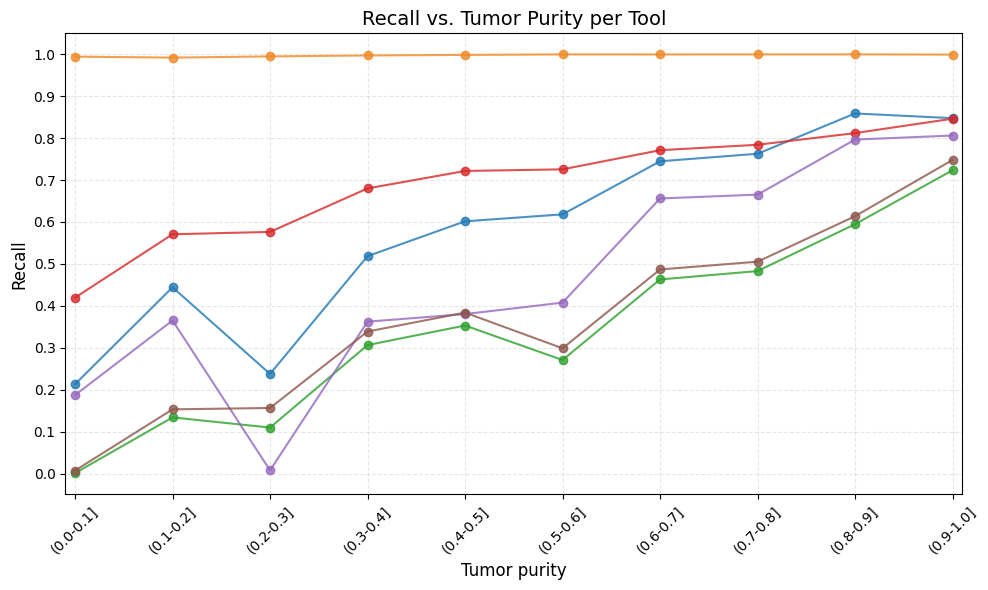

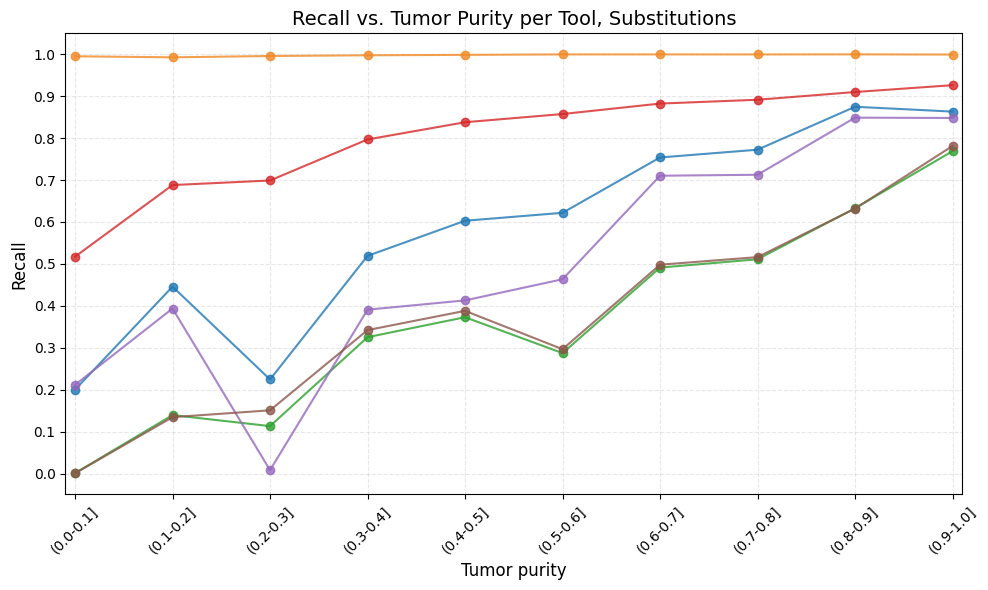

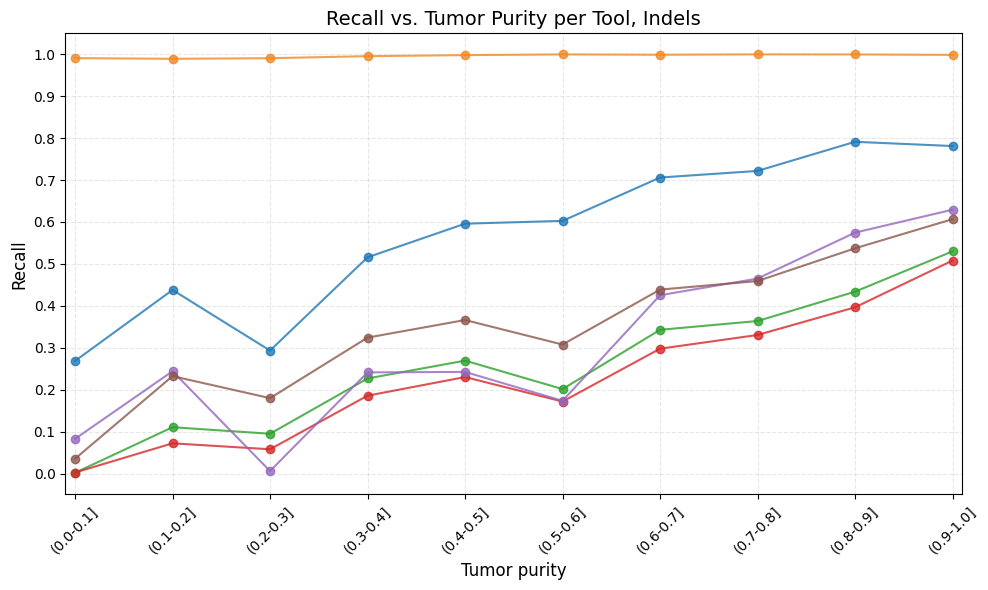

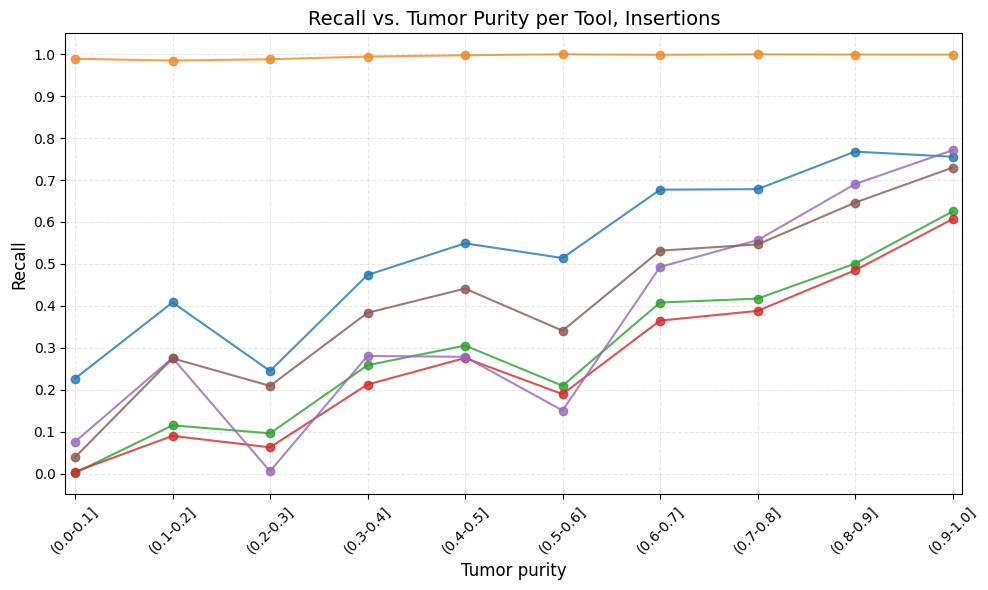

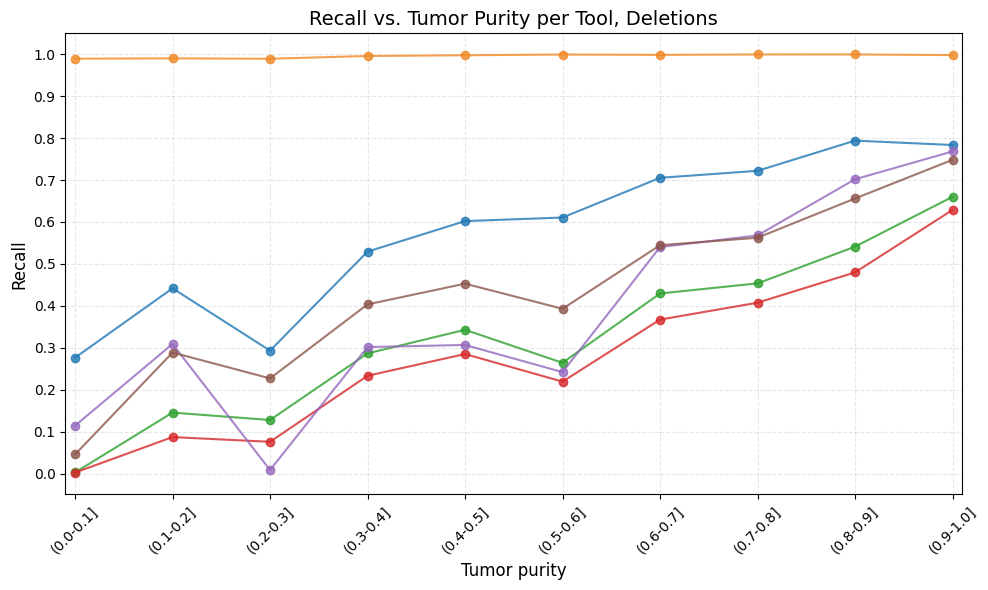

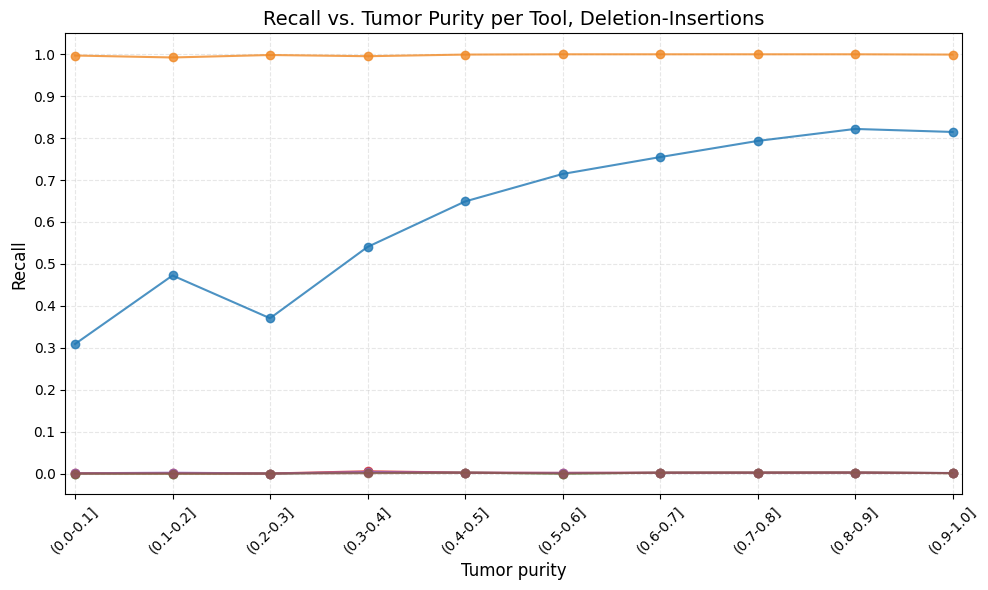

In [ ]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plot_recall_stratified_by_tumor_purity(unique_mcrs_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity", output_file = f"{fig2_output_dir}/recall_vs_purity_binned.pdf")
plot_recall_stratified_by_tumor_purity(substitution_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity, Substitutions", output_file = f"{fig2_output_dir}/recall_vs_purity_substitution_only_binned.pdf")
plot_recall_stratified_by_tumor_purity(indel_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity, Indels", output_file = f"{fig2_output_dir}/recall_vs_purity_indel_only_binned.pdf")
plot_recall_stratified_by_tumor_purity(insertion_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity, Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_insertion_only_binned.pdf")
plot_recall_stratified_by_tumor_purity(deletion_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity, Deletions", output_file = f"{fig2_output_dir}/recall_vs_purity_deletion_only_binned.pdf")
plot_recall_stratified_by_tumor_purity(delins_df, bins = bins, tools = tools, title = "Recall vs. Tumor Purity, Deletion-Insertions", output_file = f"{fig2_output_dir}/recall_vs_purity_delins_only_binned.pdf")

### Precision

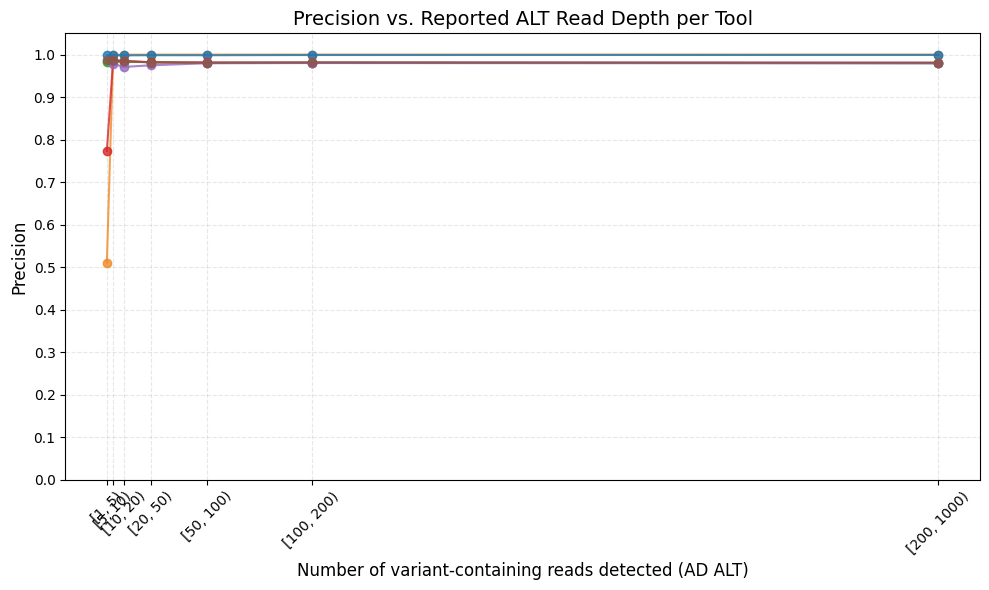

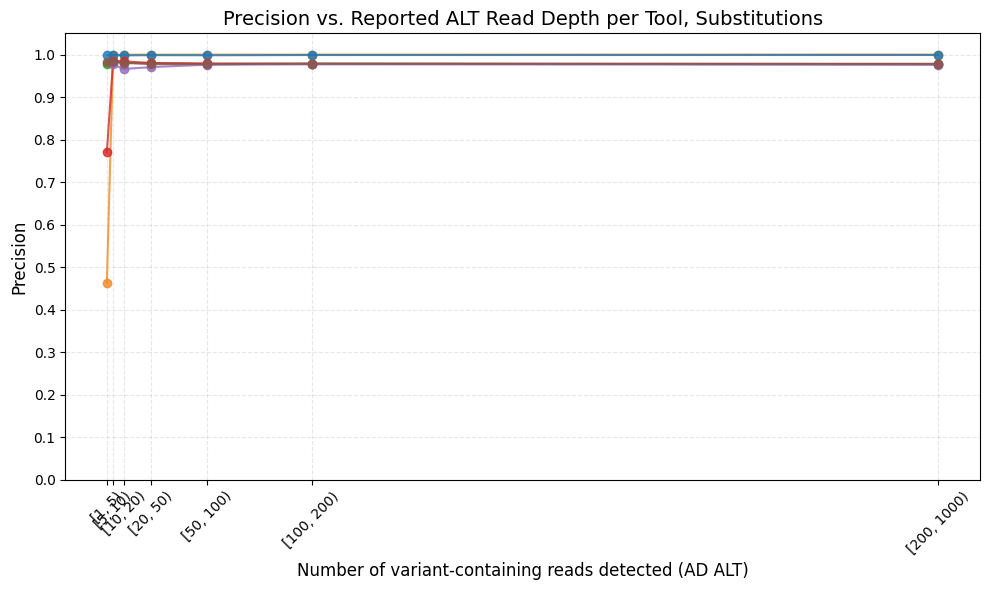

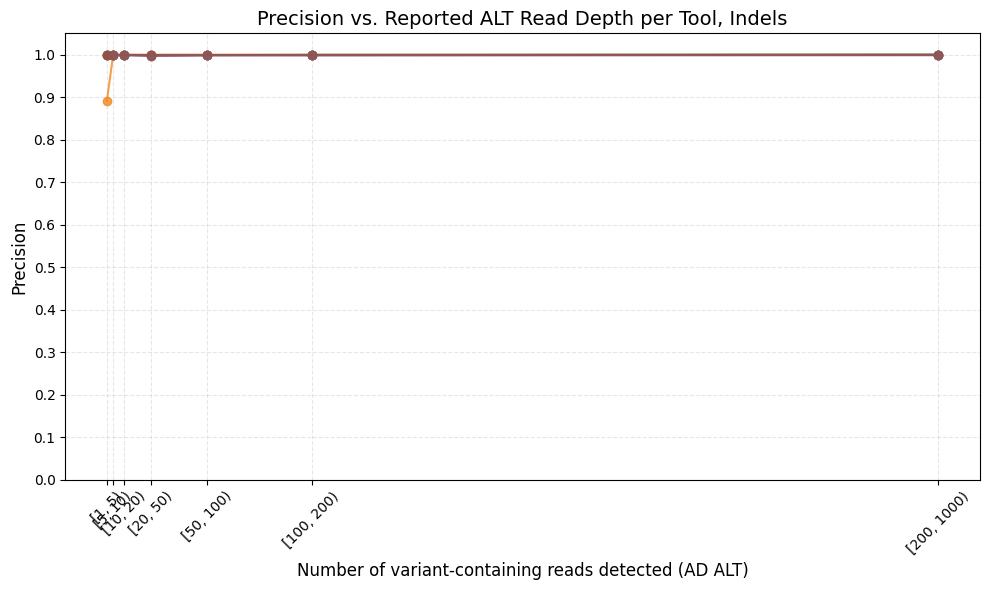

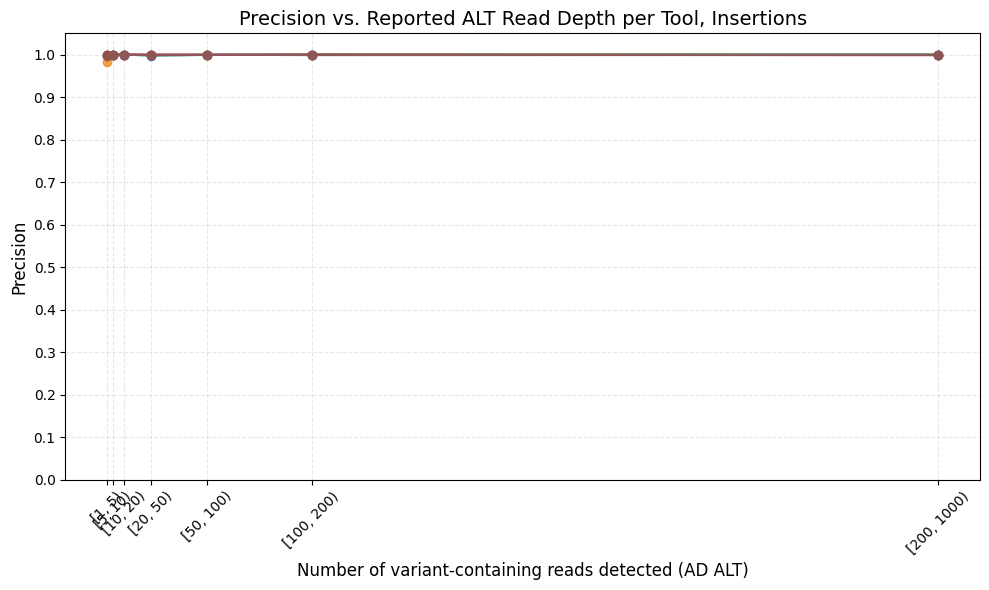

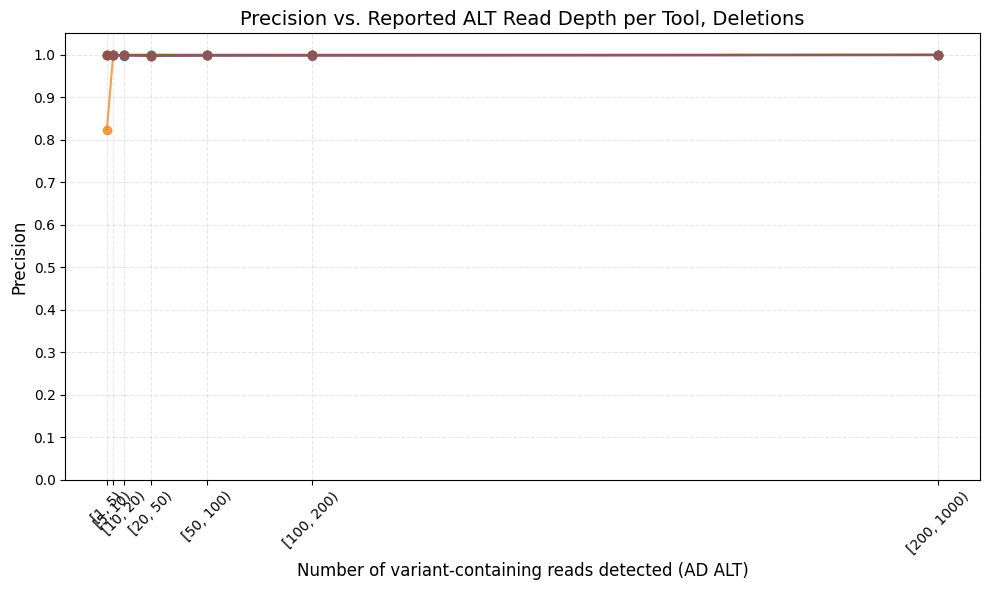

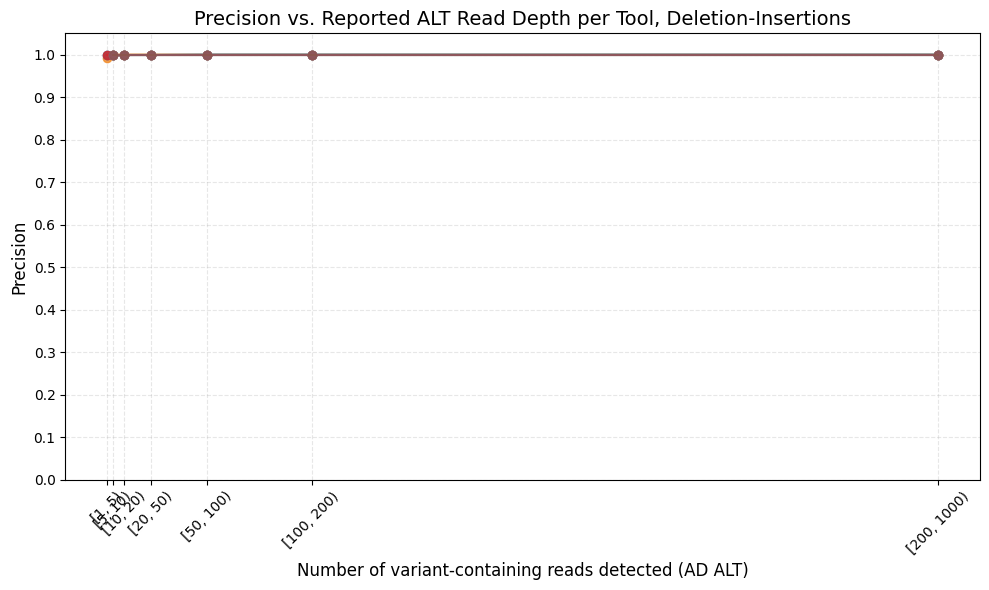

In [ ]:
x_min = 1
x_max = 300
min_occurrences = 0
bins = [1, 3, 6, 10, 20, 50, 100, 200, 1000]
x_log = True

plot_precision_stratified_by_ad_alt(unique_mcrs_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT.pdf")
plot_precision_stratified_by_ad_alt(substitution_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth, Substitutions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_substitution_only.pdf")
plot_precision_stratified_by_ad_alt(indel_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth, Indels", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_indel_only.pdf")
plot_precision_stratified_by_ad_alt(insertion_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth, Insertions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_insertion_only.pdf")
plot_precision_stratified_by_ad_alt(deletion_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth, Deletions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_deletion_only.pdf")
plot_precision_stratified_by_ad_alt(delins_df, tools = tools, x_min = x_min, x_max = x_max, min_occurrences = min_occurrences, bins = bins, x_log = x_log, title = "Precision vs. Reported ALT Read Depth, Deletion-Insertions", output_file = f"{fig2_output_dir}/precision_vs_AD_ALT_delins_only.pdf")

### Let's just print it out

In [69]:
min_counts = 3

for df_name, df in {
    "unique_mcrs_df": unique_mcrs_df,
    "substitution_df": substitution_df,
    "indel_df": indel_df,
    "insertion_df": insertion_df,
    "deletion_df": deletion_df,
    "delins_df": delins_df
}.items():
    for tool in tools:
        filtered = df.loc[df[f"AD_ALT_{tool}"] >= min_counts].copy()

        tp = filtered[f"TP_{tool}"].sum()
        fp = filtered[f"FP_{tool}"].sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')

        print(f"{df_name} {tool} precision with AD_ALT >= {min_counts}: {precision:.4f}")

unique_mcrs_df varseek precision with AD_ALT >= 3: 0.9978
unique_mcrs_df gatk_mutect2 precision with AD_ALT >= 3: 0.9987
unique_mcrs_df gatk_haplotypecaller precision with AD_ALT >= 3: 0.9819
unique_mcrs_df strelka2 precision with AD_ALT >= 3: 0.9834
unique_mcrs_df varscan precision with AD_ALT >= 3: 0.9774
unique_mcrs_df deepvariant precision with AD_ALT >= 3: 0.9830
substitution_df varseek precision with AD_ALT >= 3: 0.9976
substitution_df gatk_mutect2 precision with AD_ALT >= 3: 0.9987
substitution_df gatk_haplotypecaller precision with AD_ALT >= 3: 0.9792
substitution_df strelka2 precision with AD_ALT >= 3: 0.9822
substitution_df varscan precision with AD_ALT >= 3: 0.9742
substitution_df deepvariant precision with AD_ALT >= 3: 0.9797
indel_df varseek precision with AD_ALT >= 3: 0.9984
indel_df gatk_mutect2 precision with AD_ALT >= 3: 0.9989
indel_df gatk_haplotypecaller precision with AD_ALT >= 3: 0.9989
indel_df strelka2 precision with AD_ALT >= 3: 0.9988
indel_df varscan precisio

# Stratified metric line plot of all 3 methods: sensitivity vs mutant read depth

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


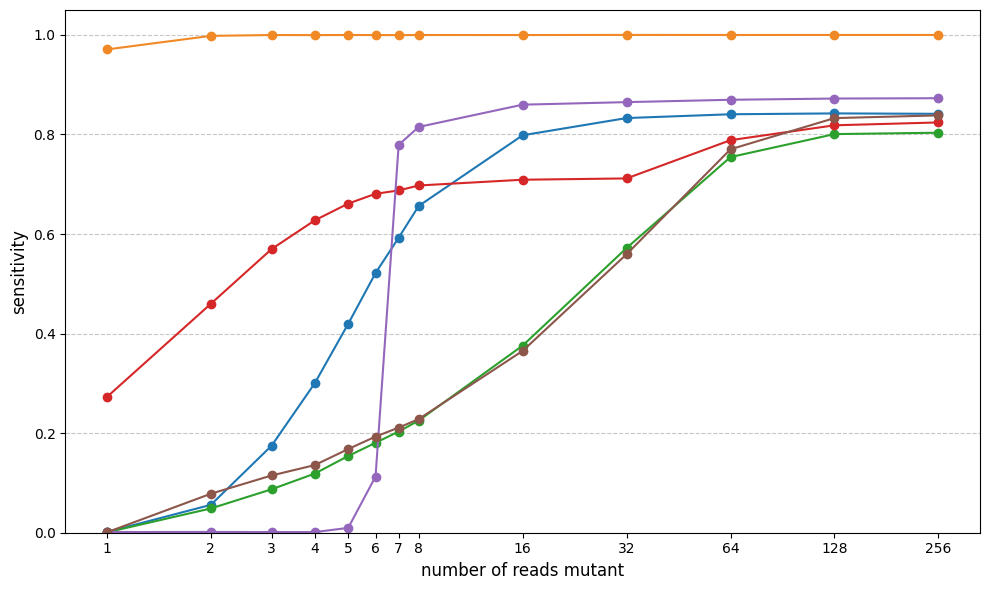

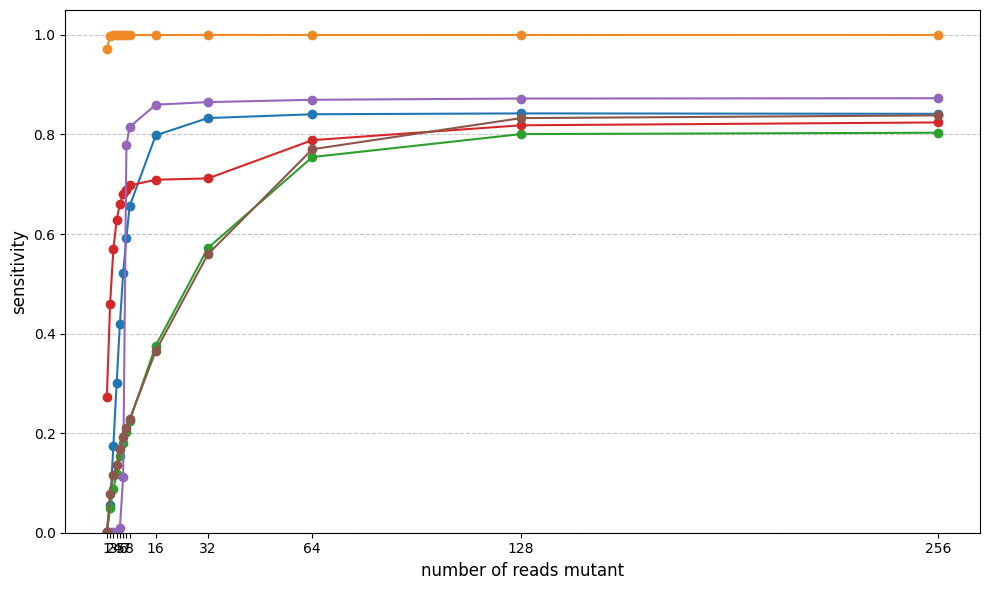

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "sensitivity"
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True
# bins, keep_strict_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, float('inf')], False  # uncomment for the binned appearance
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", filter_real_negatives = True, log=True)   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_unlogged.pdf", filter_real_negatives = True, log=False)   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


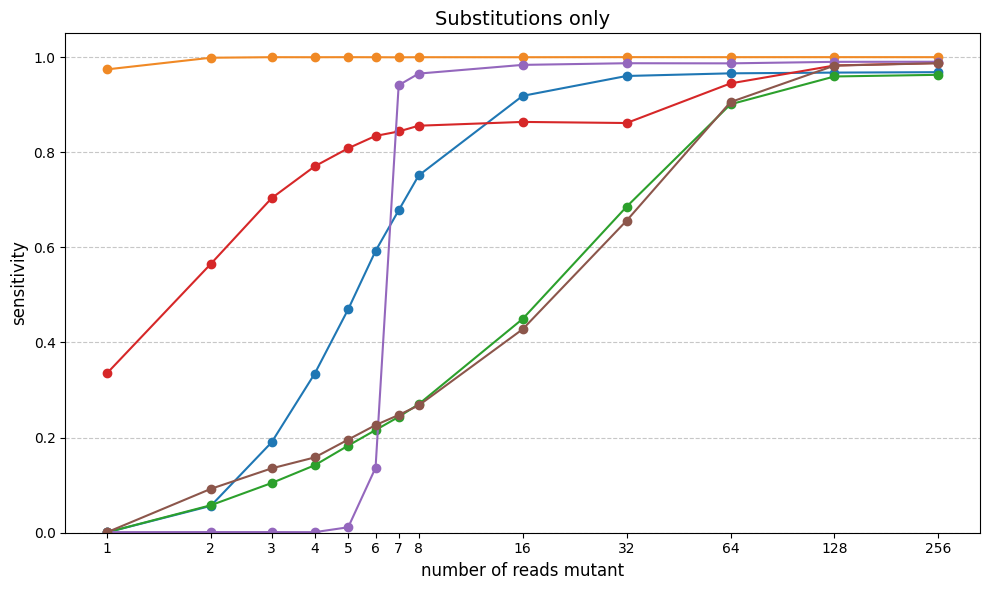

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


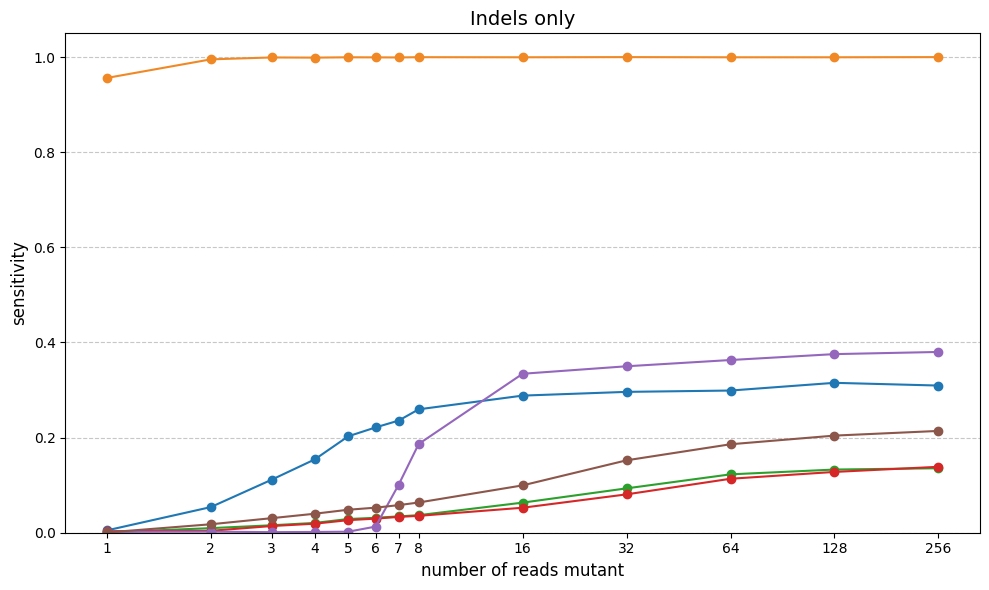

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "sensitivity"
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True

create_stratified_metric_line_plot(substitution_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_substitution.pdf", filter_real_negatives = True, log=True, title="Substitutions only")   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"
create_stratified_metric_line_plot(indel_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, keep_strict_bins = keep_strict_bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_indel.pdf", filter_real_negatives = True, log=True, title="Indels only")   # output_file_p_values = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric line plot of all 3 methods: sensitivity vs tumor purity

/home/jmrich/Desktop/RLSRWP_2025/RLSRWP_2025/visualization_utils.py:586: RuntimeWarning: invalid value encountered in remainder
  if np.all(np.equal(np.mod(bins, 1), 0)):  # if all bin values are integers, then display x-axis as integers


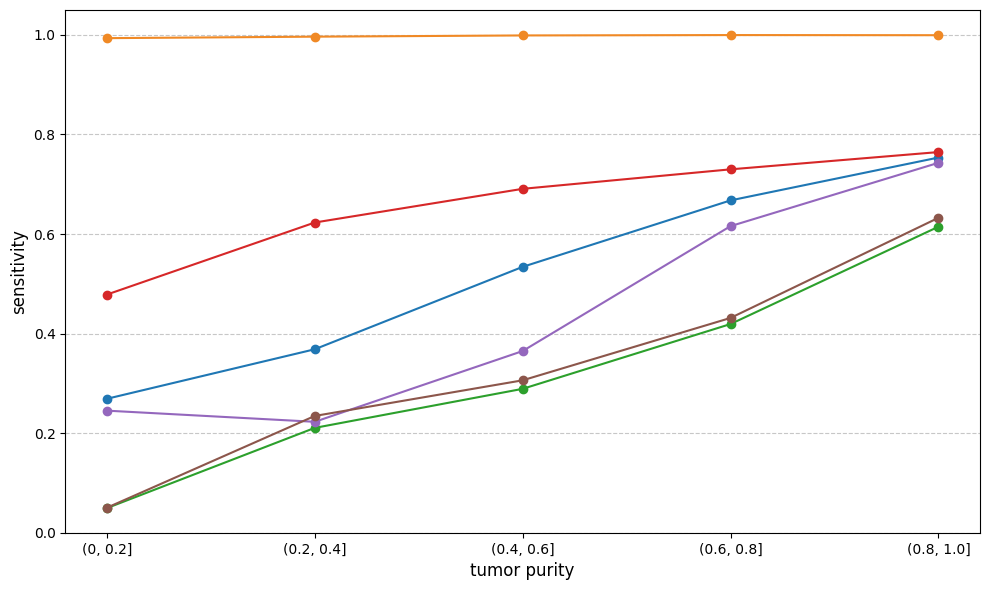

In [18]:
x_stratification = "tumor_purity"
y_metric = "sensitivity"
bins = [0, 0.2, 0.4, 0.6, 0.8, float('inf')]  # bins = None  # bins = [0, 0.25, 0.5, 0.75, 1]  # [-float('inf'), 0.25, 0.5, 0.75, float('inf')]  # absolute lower bound, midpoint1, midpoint2, ..., absolute upper bound - eg bins [0, 0.25, 0.5, 0.75, 1] --> labels ["(0, 0.25]", "(0.25, 0.5]", "(0.5, 0.75]", "(0.75, 1]"] - if absolute lower bound provided is less than real absolute lower bound, then just use -float(inf) and it is replaced internally (and same for upper)
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins = bins, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric line plot of all 3 methods: mean_magnitude_expression_error vs mutant sequencing depth

Log scale is set to True. Will remove all values <= 0 from the data for this plot.


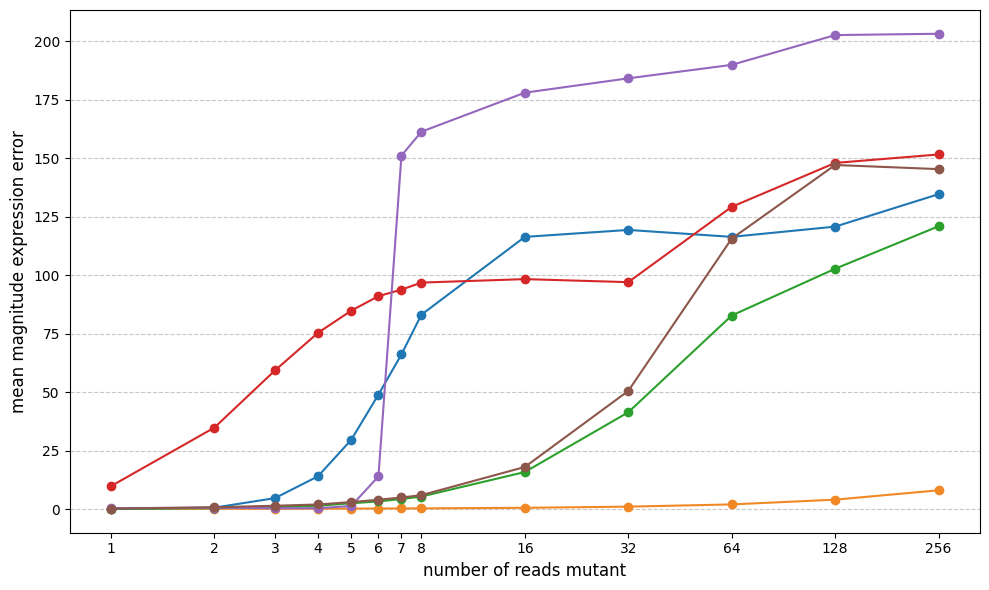

In [ ]:
x_stratification = "number_of_reads_mutant"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
bins, keep_strict_bins = [3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256], True
filter_real_negatives = False  # set this to True when y_metric is expression error for all cases besides x_stratification = "number_of_reads_mutant", as we are not interested in the vast majority of cases that are real 0 and predicted 0
create_stratified_metric_line_plot(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, bins=bins, keep_strict_bins=keep_strict_bins, filter_real_negatives = filter_real_negatives, show_p_values = False, show_confidence_intervals = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf", output_file_p_values = None, log=True)   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

# Stratified metric bar plot of all 3 methods: sensitivity vs mutation type

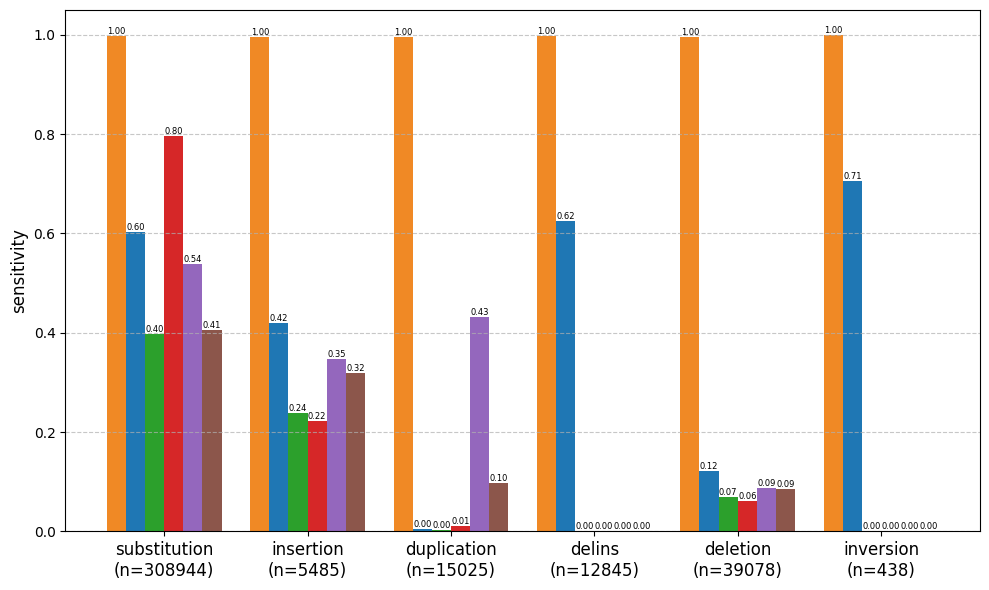

In [ ]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

x_stratification = "vcrs_variant_type"
y_metric = "sensitivity"
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")

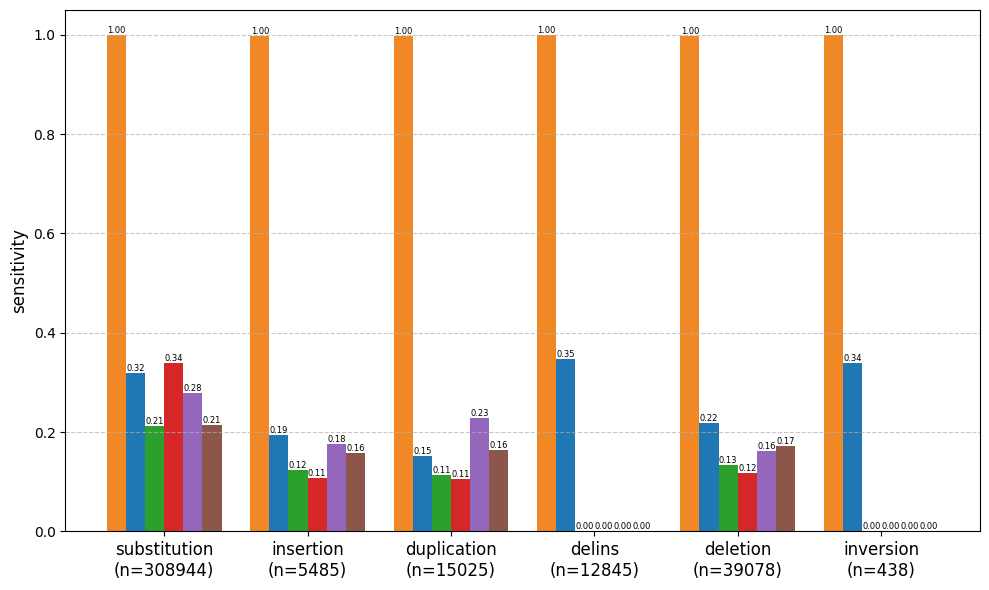

In [15]:
if "vcrs_variant_type" not in unique_mcrs_df.columns:
    unique_mcrs_df = add_vcrs_variant_type(unique_mcrs_df, var_column="vcrs_header")

x_stratification = "vcrs_variant_type"
y_metric = "sensitivity"
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")

# Stratified metric bar plot of all 3 methods: mean mutation expression error vs mutation type

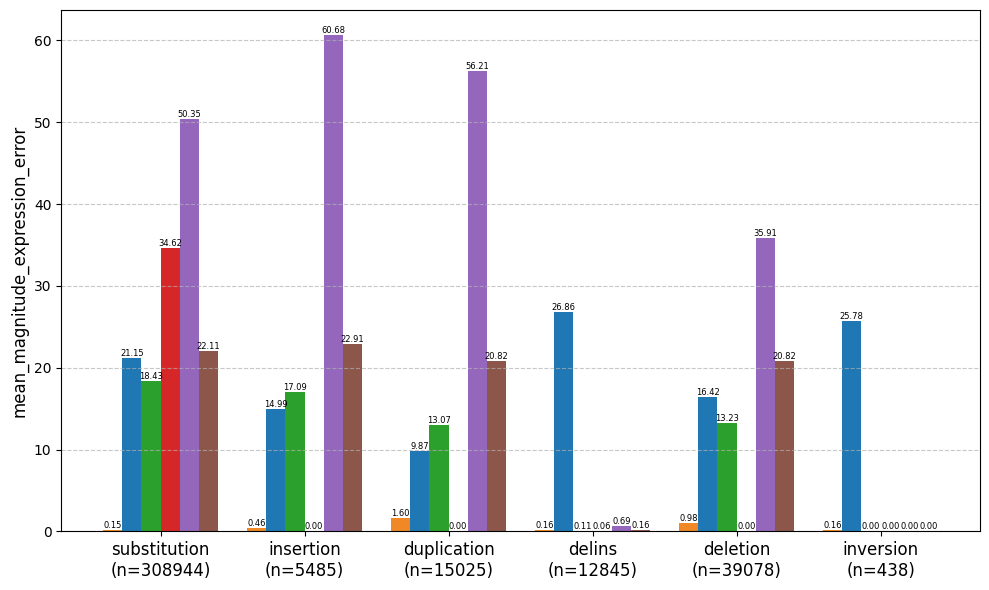

In [16]:
x_stratification = "vcrs_variant_type"
y_metric = "mean_magnitude_expression_error"  # mean_magnitude_expression_error or mean_expression_error
filter_real_negatives = True
create_stratified_metric_bar_plot_updated(unique_mcrs_df, tools = tools, x_stratification = x_stratification, y_metric = y_metric, display_numbers = True, display_numbers_fontsize=6, show_sample_size_per_x_value=True, show_p_values = False, filter_real_negatives = filter_real_negatives, output_file = f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}.pdf")   # f"{fig2_output_dir}/{y_metric}_vs_{x_stratification}_p_values.txt"

## Time and memory plot

### Put data in a df

In [11]:
# Regex patterns
runtime_pattern = re.compile(r"([\w\s]+)\s(\d+)\sreads\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern = re.compile(r"([\w\s]+)\s(\d+)\sreads\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")

data = []

# Read file and extract information
with open(variant_calling_stats_file, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern.match(line)
        if runtime_match:
            tool, reads, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Reads": int(reads), "Metric": "Runtime", "Value_variant_calling": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern.match(line)
        if memory_match:
            tool, reads, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Reads": int(reads), "Metric": "Memory", "Value_variant_calling": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df = pd.DataFrame(data)
print("Units: minutes for runtime, GB for memory")
time_and_memory_df.head()

Units: minutes for runtime, GB for memory


Tool    Reads   Metric  Value_variant_calling  Extrapolated
0               varseek  1000000  Runtime                   1.91         False
1               varseek  1000000   Memory                   4.02         False
2  gatk_haplotypecaller  1000000  Runtime                  29.64         False
3  gatk_haplotypecaller  1000000   Memory                  12.00         False
4          gatk_mutect2  1000000  Runtime                  36.26         False

## Fill in missing data by extrapolating best fit lines

In [12]:
def fit_func(x, a, b):
    return a * x**b  # Power law fit

# Identify unique values of Reads
unique_reads = time_and_memory_df["Reads"].unique()

# Function to handle missing values for a given tool
def extrapolate_missing_runtime(tool):
    updated_df = time_and_memory_df.copy()  # Make a copy to modify

    for metric in ["Runtime", "Memory"]:
        # Filter for the tool and metric
        df_tool = updated_df[
            (updated_df["Tool"] == tool) & (updated_df["Metric"] == metric)
        ]

        # Extract Reads and corresponding metric values
        available_reads = df_tool["Reads"].values
        metric_values = df_tool["Value_variant_calling"].values

        # Identify missing read values
        missing_reads = set(unique_reads) - set(available_reads)

        if missing_reads and len(available_reads) > 1:  # Ensure enough points to fit
            try:
                # Fit a curve to the available data
                popt, _ = curve_fit(fit_func, available_reads, metric_values)

                # Predict missing values
                missing_predictions = {r: fit_func(r, *popt) for r in missing_reads}

                # Create a DataFrame of missing values
                missing_df = pd.DataFrame({
                    "Tool": tool,
                    "Reads": list(missing_predictions.keys()),
                    "Metric": metric,
                    "Value_variant_calling": list(missing_predictions.values()),
                    "Extrapolated": True
                })

                # Append to the DataFrame
                updated_df = pd.concat([updated_df, missing_df], ignore_index=True)
            
            except RuntimeError:
                print(f"Curve fitting failed for {tool}, {metric} due to insufficient or poor data.")

    return updated_df  # Return updated DataFrame after processing both metrics

# Apply the function for each unique tool
for tool in time_and_memory_df["Tool"].unique():
    time_and_memory_df = extrapolate_missing_runtime(tool)

# Convert Tool and Metric to categorical with specified order
time_and_memory_df["Tool"] = pd.Categorical(time_and_memory_df["Tool"], categories=tools, ordered=True)
time_and_memory_df["Metric"] = pd.Categorical(time_and_memory_df["Metric"], categories=["Runtime", "Memory"], ordered=True)

# Sort by Reads, then Tool (custom order), then Metric (custom order)
time_and_memory_df = time_and_memory_df.sort_values(by=["Reads", "Tool", "Metric"]).reset_index(drop=True)

## Load in STAR data

In [13]:
# Data storage
data = []

# Regex pattern to extract relevant fields
bam_runtime_pattern = re.compile(r"BAM indexing runtime(?:\s\(aligned and unmapped, for GATK\))? for (\d+) reads: (\d+)\.0 minutes, ([\d.]+) seconds")

# Read and process the file
with open(STAR_stats_file, "r") as f:
    for line in f:
        # Extract STAR alignment runtime
        match = runtime_pattern.match(line)
        if match:
            tool, reads, minutes, seconds = match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": "STAR", "Reads": int(reads), "Metric": "Runtime", "Value_alignment": runtime})

        # Extract memory usage
        memory_match = memory_pattern.match(line)
        if memory_match:
            tool, reads, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": "STAR", "Reads": int(reads), "Metric": "Memory", "Value_alignment": memory})
        
        # Extract BAM indexing runtime (ignore "aligned-only, for non-GATK")
        match = bam_runtime_pattern.match(line)
        if match:
            reads, minutes, seconds = match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": "BAM indexing", "Reads": int(reads), "Metric": "Runtime", "Value_alignment": runtime})

# Convert to DataFrame
star_time_and_memory_df = pd.DataFrame(data)

# Aggregate across Tools that share the same Reads and Metric
star_time_and_memory_df = star_time_and_memory_df.groupby(["Reads", "Metric"], as_index=False).agg({"Value_alignment": "sum"})

print("Units: minutes for runtime, GB for memory")
star_time_and_memory_df.head()

Units: minutes for runtime, GB for memory


Reads   Metric  Value_alignment
0   1000000   Memory            34.64
1   1000000  Runtime             2.34
2   4000000   Memory            34.70
3   4000000  Runtime             2.77
4  16000000   Memory            34.88

### Notice how STAR alignments are pretty consistent in RAM requirements across reads

In [14]:
print(star_time_and_memory_df.loc[star_time_and_memory_df["Metric"] == "Memory"])
star_alignment_memory_mean = star_time_and_memory_df.loc[star_time_and_memory_df["Metric"] == "Memory", "Value_alignment"].mean()

         Reads  Metric  Value_alignment
0      1000000  Memory            34.64
2      4000000  Memory            34.70
4     16000000  Memory            34.88
6     64000000  Memory            35.13
8    256000000  Memory            35.11
10  1024000000  Memory            35.35


In [15]:
# Merge the STAR + BAM indexing DataFrame with time_and_memory_df
time_and_memory_df = time_and_memory_df.merge(star_time_and_memory_df, on=["Reads", "Metric"], how="left")

# Set varseek rows to 0, since varseek doesn't utilize STAR
time_and_memory_df.loc[time_and_memory_df["Tool"] == "varseek", "Value_alignment"] = 0

time_and_memory_df.loc[time_and_memory_df["Metric"] == "Runtime", "Value_total"] = (time_and_memory_df["Value_alignment"] + time_and_memory_df["Value_variant_calling"])  # for runtime, sum
time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_total"] = time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_variant_calling"] # time_and_memory_df.loc[time_and_memory_df["Metric"] == "Memory", "Value_total"] = (time_and_memory_df[["Value_alignment", "Value_variant_calling"]].max(axis=1))  # for memory, take the max
time_and_memory_df.head()

Tool    Reads   Metric  Value_variant_calling  \
0               varseek  1000000  Runtime                   1.91   
1               varseek  1000000   Memory                   4.02   
2          gatk_mutect2  1000000  Runtime                  36.26   
3          gatk_mutect2  1000000   Memory                  11.80   
4  gatk_haplotypecaller  1000000  Runtime                  29.64   

   Extrapolated  Value_alignment  Value_total  
0         False             0.00         1.91  
1         False             0.00         4.02  
2         False             2.34        38.60  
3         False            34.64        11.80  
4         False             2.34        31.98

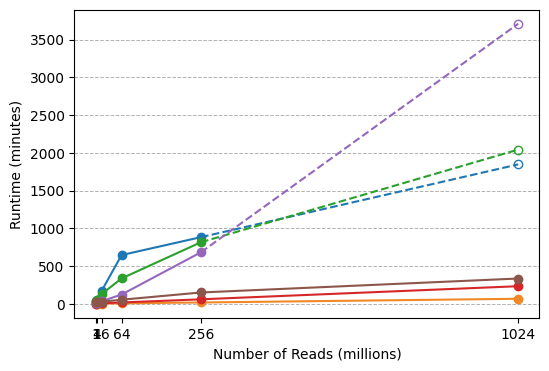

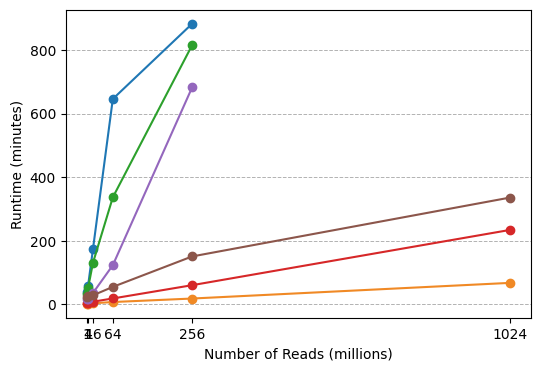

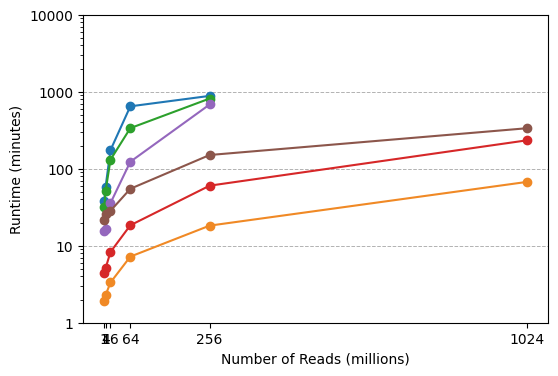

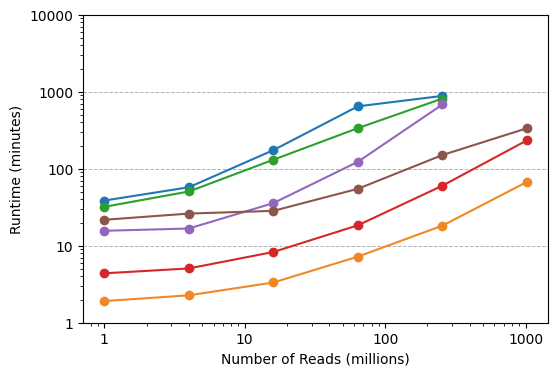

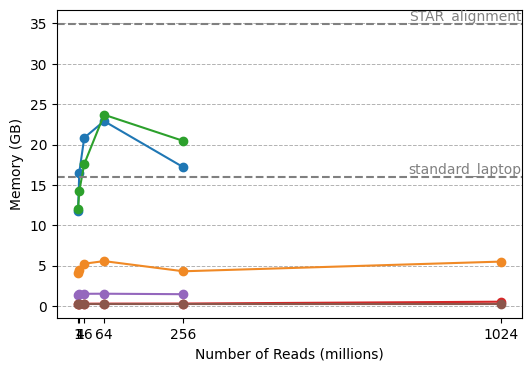

In [ ]:
# from RLSRWP_2025.visualization_utils import plot_time_and_memory_benchmarking
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", plot_extrapolated=True, output_file = f"{fig2_output_dir}/runtime_benchmarking_with_extrapolated_values.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", output_file = f"{fig2_output_dir}/runtime_benchmarking.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", log_y=True)
plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Runtime", units="minutes", y_col="Value_total", log_y=True, log_x=True)

plot_time_and_memory_benchmarking(time_and_memory_df, metric_name = "Memory", units="GB", y_col="Value_total", y_thresholds={"standard_laptop": 16, "STAR_alignment": star_alignment_memory_mean}, output_file = f"{fig2_output_dir}/memory_benchmarking.pdf")

In [23]:
# Dictionary to store slopes
slopes = {}

# Filter for Runtime metric
runtime_df = time_and_memory_df[time_and_memory_df["Metric"] == "Runtime"]

# Iterate over unique Tools
for tool in runtime_df["Tool"].unique():
    subset = runtime_df[runtime_df["Tool"] == tool].sort_values("Reads")
    if "Extrapolated" in subset.columns:
        subset = subset[~subset["Extrapolated"]]

    # Extract Reads (x) and Runtime (y)
    x = subset["Reads"].values / 1e6  # Convert to millions
    y = subset["Value_variant_calling"].values  # Assuming this stores runtime

    if len(x) > 1:  # Ensure at least two points for slope calculation
        slope, _, _, _, _ = linregress(x, y)
        slopes[tool] = slope  # Store the slope, in units of minutes per million reads

runtime_per_10M_reads_stats_file = os.path.join(fig2_output_dir, "runtime_per_10M_reads.txt")

with open(runtime_per_10M_reads_stats_file, "w") as f:
    f.write("Runtime per 10 million reads:\n")
    f.write("----------------------------\n")
    for tool, slope in slopes.items():
        line = f"{tool}: {slope*10:.2f} min/10M reads\n"
        f.write(line)
        print(line.strip())

varseek: 0.64 min/10M reads
gatk_mutect2: 128.76 min/10M reads
gatk_haplotypecaller: 77.59 min/10M reads
strelka2: 0.98 min/10M reads
varscan: 25.31 min/10M reads
deepvariant: 1.78 min/10M reads


In [82]:
def make_upset(unique_mcrs_df, tools = ('varseek', ), number_of_reads_mutant_min = 0, max_subset_size = None, title = None, include_empty_subsets = False, head = None, out_path = None):
    filtered_unique_mcrs_df = unique_mcrs_df.loc[unique_mcrs_df["included_in_synthetic_reads_mutant"]].copy()
    
    if number_of_reads_mutant_min:
        filtered_unique_mcrs_df = filtered_unique_mcrs_df.loc[filtered_unique_mcrs_df["number_of_reads_mutant"] >= number_of_reads_mutant_min]
    
    if head is not None:    # only for debugging
        if head is True:
            head = 20
        filtered_unique_mcrs_df = filtered_unique_mcrs_df.head(head)

    mutations_detected_dict = {}
    # all_elements = set(filtered_unique_mcrs_df['vcrs_header'].tolist())

    for tool in tools:
        mutations_detected_dict[tool] = set(filtered_unique_mcrs_df.loc[filtered_unique_mcrs_df[f'mutation_detected_{tool}'], 'vcrs_header'].tolist())
        # all_elements.update(mutations_detected_dict[tool])

    mutations_detected_data_for_upset = from_contents(mutations_detected_dict)
    upset = UpSet(mutations_detected_data_for_upset, subset_size='count', show_counts=True, include_empty_subsets = include_empty_subsets, max_subset_size=max_subset_size)
    fig = plt.figure(figsize=(8, 6))  # You can adjust the size
    upset.plot(fig=fig)
    if title:
        fig.suptitle(title)

    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight')
    
    plt.show()
    
    # plt.close()

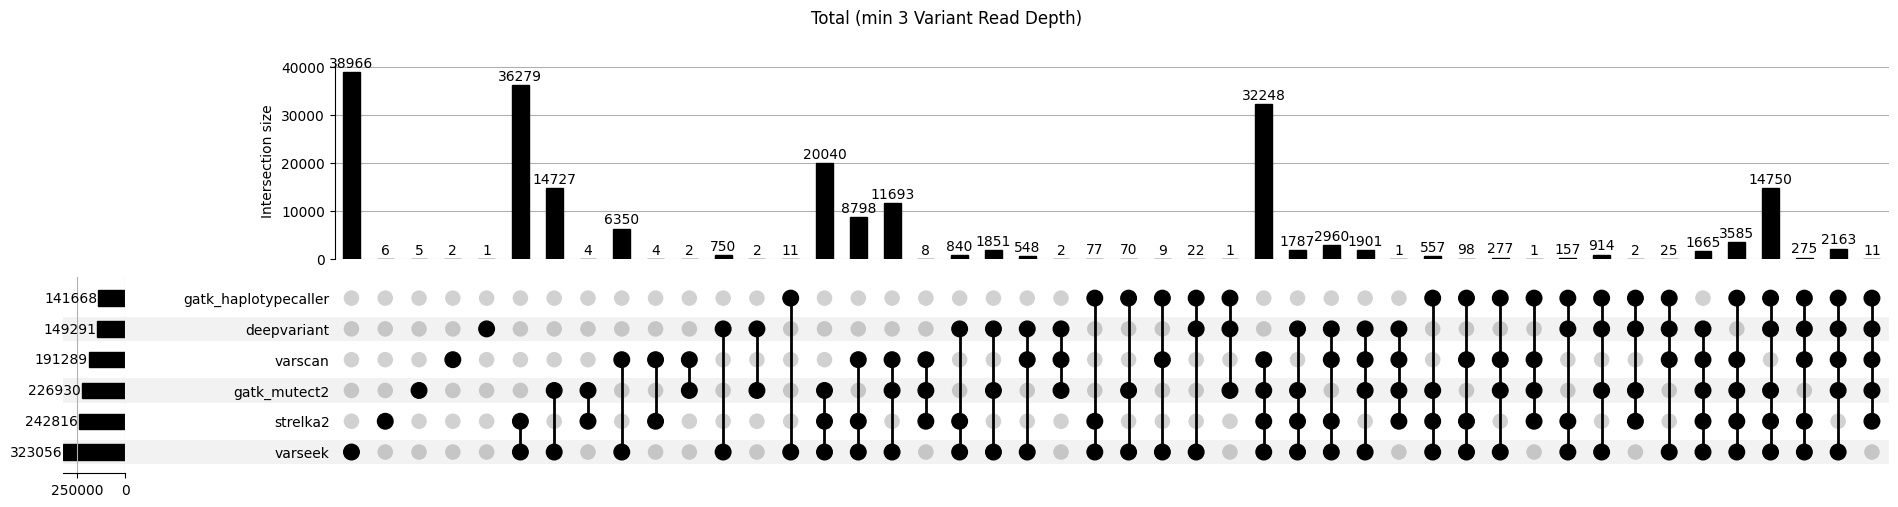

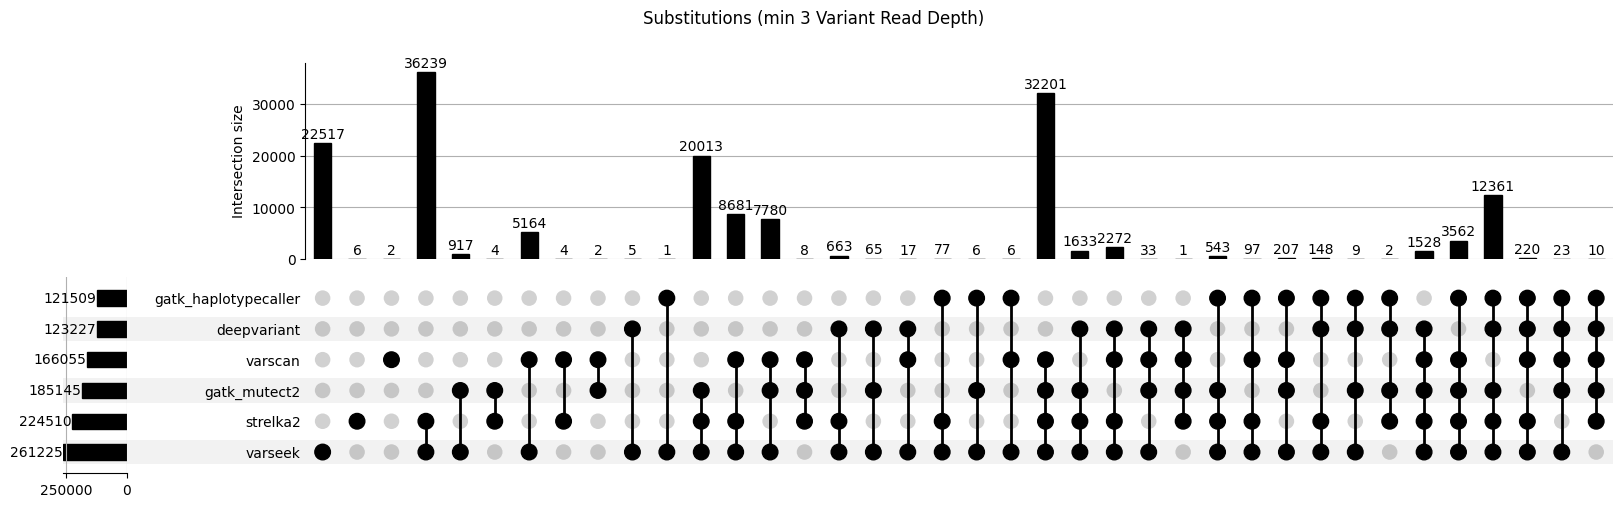

In [ ]:
number_of_reads_mutant_min = 3
max_subset_size = None
title_suffix = f" (min {number_of_reads_mutant_min} Variant Read Depth)" if number_of_reads_mutant_min else ""

make_upset(unique_mcrs_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title = f"Total{title_suffix}", out_path = f"{fig2_output_dir}/upset_total_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")
make_upset(substitution_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title =f"Substitutions{title_suffix}", out_path = f"{fig2_output_dir}/upset_substitution_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")
make_upset(indel_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title = f"Indels{title_suffix}", out_path = f"{fig2_output_dir}/upset_indel_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")
make_upset(insertion_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title = f"Insertions{title_suffix}", out_path = f"{fig2_output_dir}/upset_insertion_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")
make_upset(deletion_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title = f"Deletions{title_suffix}", out_path = f"{fig2_output_dir}/upset_deletion_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")
make_upset(delins_df, tools = tools, number_of_reads_mutant_min = number_of_reads_mutant_min, max_subset_size = max_subset_size, title = f"Deletion-Insertions{title_suffix}", out_path = f"{fig2_output_dir}/upset_delins_depth_min_{number_of_reads_mutant_min}_max_subset_size{str(max_subset_size)}.pdf")

In [101]:
number_of_reads_mutant_min = 128
filter_delins = True  # will remove delins, as many tools classify these as multiple substitutions rather than a single delins

indel_in_synthetic_data_df = indel_df[indel_df["included_in_synthetic_reads_mutant"]].copy()
if number_of_reads_mutant_min:
    indel_in_synthetic_data_df = indel_in_synthetic_data_df.loc[indel_in_synthetic_data_df["number_of_reads_mutant"] >= number_of_reads_mutant_min].copy()
if filter_delins:
    indel_in_synthetic_data_df = indel_in_synthetic_data_df.loc[~indel_in_synthetic_data_df["vcrs_variant_type"].isin(["delins", "inversion"])].copy()

cols_to_sum = [f"mutation_detected_{tool}" for tool in tools]
indel_in_synthetic_data_df["number_of_tools_that_detected_the_variant"] = indel_in_synthetic_data_df[cols_to_sum].sum(axis=1)

indel_in_synthetic_data_detected_by_many_tools_df = indel_in_synthetic_data_df.loc[(indel_in_synthetic_data_df["mutation_detected_varseek"]) & (indel_in_synthetic_data_df["number_of_tools_that_detected_the_variant"] > 2)].copy()
indel_in_synthetic_data_detected_by_few_tools_df = indel_in_synthetic_data_df.loc[(indel_in_synthetic_data_df["mutation_detected_varseek"]) & (indel_in_synthetic_data_df["number_of_tools_that_detected_the_variant"] <= 2)].copy()

indel_in_synthetic_data_detected_by_many_tools_df = indel_in_synthetic_data_detected_by_many_tools_df[indel_in_synthetic_data_detected_by_many_tools_df['vcrs_variant_type'] != 'mixed']
indel_in_synthetic_data_detected_by_few_tools_df = indel_in_synthetic_data_detected_by_few_tools_df[indel_in_synthetic_data_detected_by_few_tools_df['vcrs_variant_type'] != 'mixed']

vcrs_headers_in_at_most_2_tools = set(indel_in_synthetic_data_detected_by_few_tools_df["vcrs_header"].tolist())
sorted(list(vcrs_headers_in_at_most_2_tools))[:5]

['ENST00000007414:c.1548del',
 'ENST00000080059:c.702_703dup',
 'ENST00000155858:c.3140_3165del',
 'ENST00000171887:c.3784_3832del',
 'ENST00000203001:c.589del']

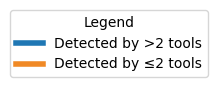

In [98]:
categories = ["Detected by >2 tools", "Detected by ≤2 tools"]
detected_by_most_tools_color = "#1f77b4"
detected_by_few_tools_color = "#f08925"
color_map = {
    "Detected by >2 tools": detected_by_most_tools_color,
    "Detected by ≤2 tools": detected_by_few_tools_color
}

create_benchmarking_legend(categories, color_map = color_map, outfile = f"{fig2_output_dir}/legend_missed_indels.pdf")

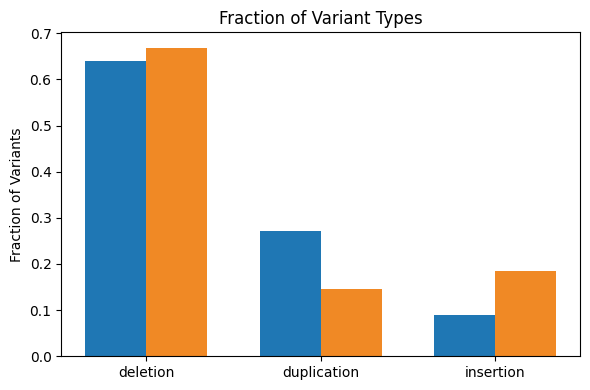

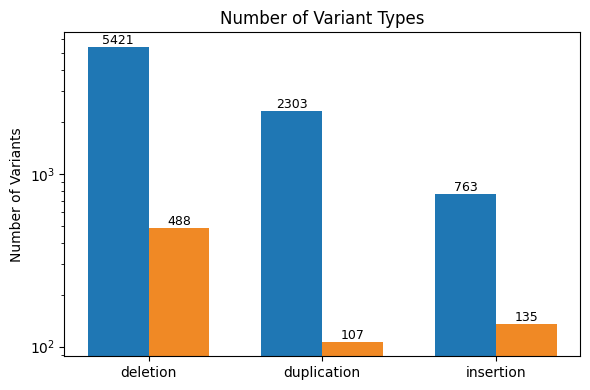

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_basic_mutation_types(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, normalize = True, show_numbers = False, out_path = None):
    # Get normalized counts (fractions) for each variant type
    all_variant_fractions = (
        indel_in_synthetic_data_detected_by_many_tools_df['vcrs_variant_type']
        .value_counts(normalize=normalize)
        .sort_index()
    )

    few_tools_fractions = (
        indel_in_synthetic_data_detected_by_few_tools_df['vcrs_variant_type']
        .value_counts(normalize=normalize)
        .sort_index()
    )

    # Ensure both have the same index (all 3 types in the same order)
    variant_types = sorted(set(all_variant_fractions.index).union(few_tools_fractions.index))
    variant_types = [variant_type for variant_type in variant_types if variant_type != "mixed"]
    all_variant_fractions = all_variant_fractions.reindex(variant_types, fill_value=0)
    few_tools_fractions = few_tools_fractions.reindex(variant_types, fill_value=0)

    # Plotting
    x = range(len(variant_types))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x, all_variant_fractions, width=width, label='Detected by >2 tools', color=detected_by_most_tools_color)
    plt.bar([i + width for i in x], few_tools_fractions, width=width, label='Detected by ≤2 tools (including varseek)', color=detected_by_few_tools_color)

    plt.xticks([i + width / 2 for i in x], variant_types)
    if not normalize:
        plt.yscale('log')
        plt.title("Number of Variant Types")
        plt.ylabel("Number of Variants")
    else:
        plt.title("Fraction of Variant Types")
        plt.ylabel("Fraction of Variants")
    
    if show_numbers:
        ax = plt.gca()
        bars1 = ax.bar(x, all_variant_fractions, width=width, label='Detected by >2 tools', color=detected_by_most_tools_color)
        bars2 = ax.bar([i + width for i in x], few_tools_fractions, width=width, label='Detected by ≤2 tools (including varseek)', color=detected_by_few_tools_color)

        # Add counts on top of each bar
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha='center', va='bottom', fontsize=9)

        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha='center', va='bottom', fontsize=9)

    # plt.legend()
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()


plot_basic_mutation_types(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, normalize = True, show_numbers = False, out_path = f"{fig2_output_dir}/missed_indels_variant_type_fraction.pdf")
plot_basic_mutation_types(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, normalize = False, show_numbers = True, out_path = f"{fig2_output_dir}/missed_indels_variant_type_total.pdf")

In [103]:
semicolon_count = indel_in_synthetic_data_detected_by_many_tools_df['vcrs_header'].str.contains(';').sum()
print(semicolon_count)

indel_in_synthetic_data_detected_by_many_tools_df = indel_in_synthetic_data_detected_by_many_tools_df[
    ~indel_in_synthetic_data_detected_by_many_tools_df['vcrs_header'].str.contains(';')
]

semicolon_count = indel_in_synthetic_data_detected_by_few_tools_df['vcrs_header'].str.contains(';').sum()
print(semicolon_count)

indel_in_synthetic_data_detected_by_few_tools_df = indel_in_synthetic_data_detected_by_few_tools_df[
    ~indel_in_synthetic_data_detected_by_few_tools_df['vcrs_header'].str.contains(';')
]

61
48


In [104]:
def add_additional_mutation_info_columns(df, t2g_dict = None):
    df = df.copy()
    df[['transcript_id', 'mutation']] = df['vcrs_header'].str.split(':', n=1, expand=True)
    df[["nucleotide_positions", "actual_variant"]] = df['mutation'].str.extract(vk.constants.mutation_pattern)
    df = df.dropna(subset=["nucleotide_positions", "actual_variant"])
    split_positions = df["nucleotide_positions"].str.split("_", expand=True)
    df["start_variant_position"] = split_positions[0]
    if split_positions.shape[1] > 1:
        df["end_variant_position"] = split_positions[1].fillna(split_positions[0])
    else:
        df["end_variant_position"] = df["start_variant_position"]

    df.loc[df["end_variant_position"].isna(), "end_variant_position"] = df["start_variant_position"]

    if "gene_id" not in df.columns:
        df["gene_id"] = df["transcript_id"].map(t2g_dict).fillna(df["transcript_id"])

    df['mutation_length'] = float('nan')

    # For deletions: end - start + 1
    mask_deletion_duplication = df['vcrs_variant_type'].isin(['deletion', 'duplication'])
    df.loc[mask_deletion_duplication, 'mutation_length'] = (
        df.loc[mask_deletion_duplication, 'end_variant_position'].astype(float) -
        df.loc[mask_deletion_duplication, 'start_variant_position'].astype(float) + 1
    )

    # For insertions and duplications: use length of actual_variant
    mask_insertion = df['vcrs_variant_type'] == 'insertion'
    df.loc[mask_insertion, 'mutation_length'] = df.loc[mask_insertion, 'actual_variant'].str.len()

    return df

reference_dir = os.path.join(varseek_directory, "data", "reference")
t2g_file = os.path.join(reference_dir, "ensembl_grch37_release93", "t2g.txt")
t2g_dict = vk.utils.make_t2g_dict(t2g_file, strip_versions=True)

indel_in_synthetic_data_detected_by_many_tools_df = add_additional_mutation_info_columns(indel_in_synthetic_data_detected_by_many_tools_df, t2g_dict = t2g_dict)
indel_in_synthetic_data_detected_by_few_tools_df = add_additional_mutation_info_columns(indel_in_synthetic_data_detected_by_few_tools_df, t2g_dict = t2g_dict)

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


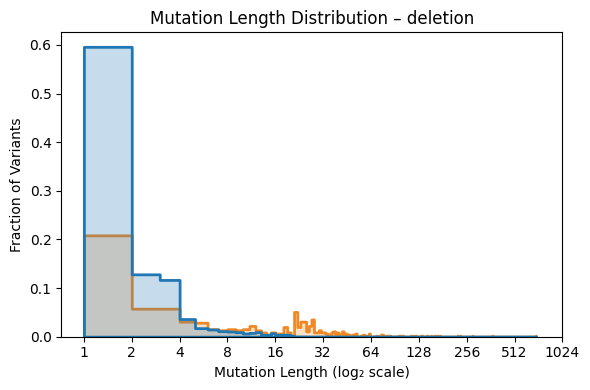

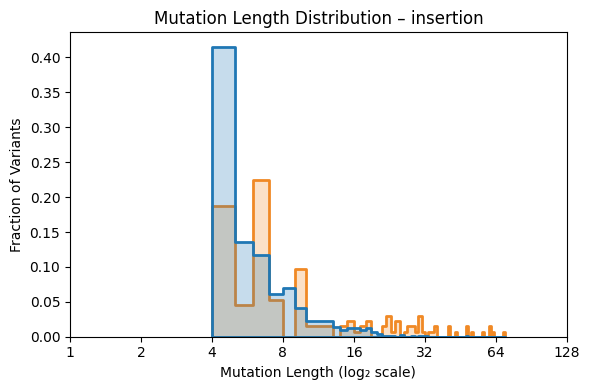

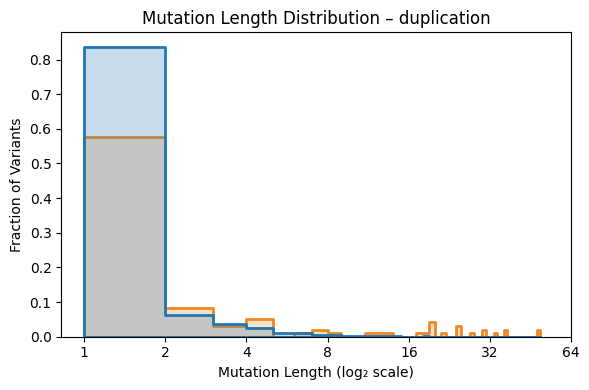

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Tag source
df_many = indel_in_synthetic_data_detected_by_many_tools_df.copy()
df_many['source'] = 'Detected by >2 tools'

df_few = indel_in_synthetic_data_detected_by_few_tools_df.copy()
df_few['source'] = 'Detected by ≤2 tools'

# Combine
combined_df = pd.concat([df_many, df_few], ignore_index=True)

# Variant types to plot
variant_types = ['deletion', 'insertion', 'duplication']

# Plot per variant type
for variant in variant_types:
    subset = combined_df[combined_df['vcrs_variant_type'] == variant]

    min_len = subset["mutation_length"].min()
    max_len = subset["mutation_length"].max()
    bins = np.arange(min_len, max_len + 2)

    plt.figure(figsize=(6, 4))
    ax = sns.histplot(
        data=subset,
        x='mutation_length',
        hue='source',
        stat='probability',
        common_norm=False,
        bins=bins,
        element='step',
        fill=True,
        linewidth=2,
        legend=False,  # comment out for legend
        palette={
            'Detected by >2 tools': detected_by_most_tools_color,
            'Detected by ≤2 tools': detected_by_few_tools_color
        }
    )

    # Set log2 scale on x-axis
    ax.set_xscale("log", base=2)

    # Set x ticks to exact powers of 2 within data range
    min_val = 1
    max_val = subset["mutation_length"].max()
    start_exp = int(np.floor(np.log2(min_val)))
    end_exp = int(np.ceil(np.log2(max_val)))
    xticks = [2**i for i in range(start_exp, end_exp + 1)]
    ax.set_xticks(xticks)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='x')  # disables scientific notation

    ax.set_title(f"Mutation Length Distribution – {variant}")
    ax.set_xlabel("Mutation Length (log₂ scale)")
    ax.set_ylabel("Fraction of Variants")
    plt.tight_layout()
    plt.savefig(f"{fig2_output_dir}/missed_indels_length_distribution_{variant}.pdf")
    plt.show()

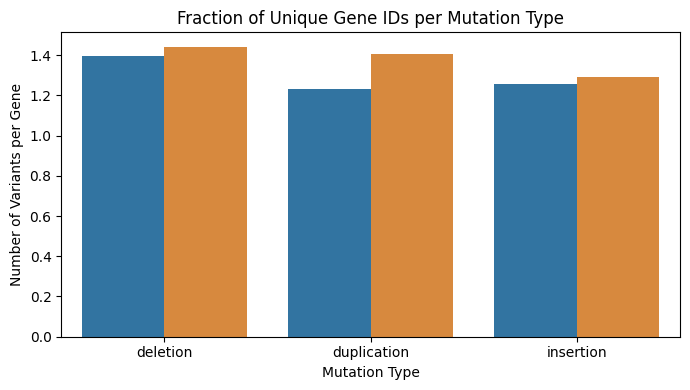

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a helper function
def compute_gene_id_fraction(df, label):
    grouped = df.groupby("vcrs_variant_type")
    result = grouped.apply(lambda g: len(g) / g["gene_id"].nunique()).reset_index()
    result.columns = ["vcrs_variant_type", "number_of_variants_per_gene_average"]
    result["source"] = label
    return result

# Compute for each
df_many_frac = compute_gene_id_fraction(indel_in_synthetic_data_detected_by_many_tools_df, 'Detected by >2 tools')
df_few_frac = compute_gene_id_fraction(indel_in_synthetic_data_detected_by_few_tools_df, 'Detected by ≤2 tools')

# Combine
summary_df = pd.concat([df_many_frac, df_few_frac], ignore_index=True)

# Plot
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=summary_df,
    x="vcrs_variant_type",
    y="number_of_variants_per_gene_average",
    hue="source",
    legend=False,  # comment out for legend
    palette={
        'Detected by >2 tools': detected_by_most_tools_color,
        'Detected by ≤2 tools': detected_by_few_tools_color 
    },
)
ax.set_ylabel("Number of Variants per Gene")
ax.set_xlabel("Mutation Type")
ax.set_title("Fraction of Unique Gene IDs per Mutation Type")
plt.tight_layout()
plt.savefig(f"{fig2_output_dir}/missed_indels_gene_id_fraction.pdf")
plt.show()


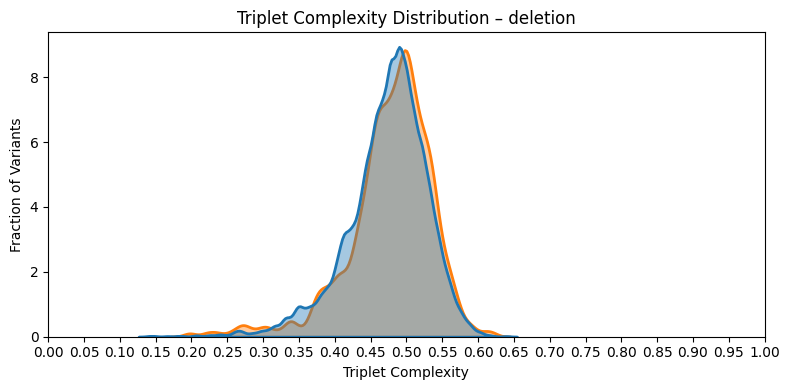

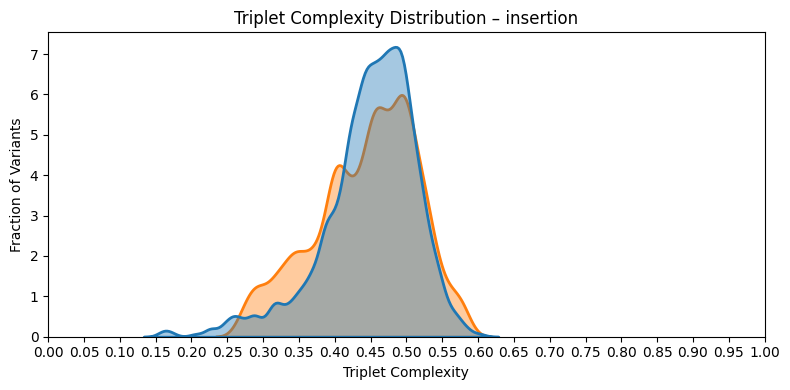

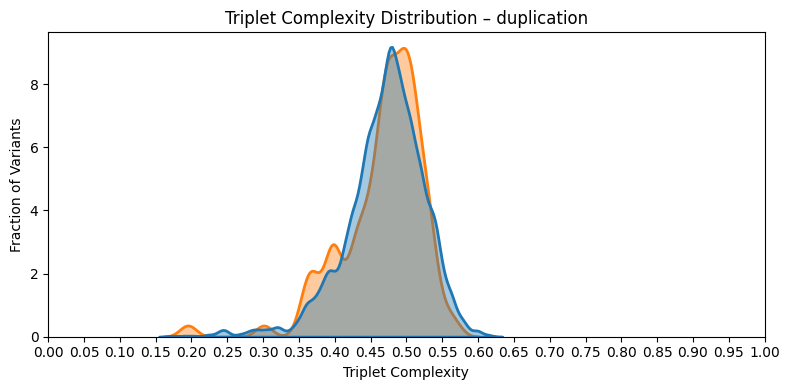

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

bw_adjust = 0.5  # smaller value = tighter fit; adjust as needed

# Add source column
df_many = indel_in_synthetic_data_detected_by_many_tools_df.copy()
df_many['source'] = 'Detected by >2 tools'
df_many['triplet_complexity'] = df_many['triplet_complexity'].str[1:-1]  # remove brackets

df_few = indel_in_synthetic_data_detected_by_few_tools_df.copy()
df_few['source'] = 'Detected by ≤2 tools'
df_few['triplet_complexity'] = df_few['triplet_complexity'].str[1:-1]

# Combine
combined_df = pd.concat([df_many, df_few], ignore_index=True)
combined_df = combined_df[~combined_df['triplet_complexity'].isna()]
combined_df['triplet_complexity'] = pd.to_numeric(combined_df['triplet_complexity'], errors='coerce')
# combined_df['triplet_complexity'] = combined_df['triplet_complexity'].round(2)

# Variant types to plot
variant_types = ['deletion', 'insertion', 'duplication']

# Plot per variant type
for variant in variant_types:
    subset = combined_df[combined_df['vcrs_variant_type'] == variant]

    plt.figure(figsize=(8, 4))

    ax = sns.kdeplot(
        data=subset,
        x='triplet_complexity',
        hue='source',
        common_norm=False,
        bw_adjust=bw_adjust,
        fill=True,
        legend=False,  # comment out for legend
        alpha=0.4,
        linewidth=2
    )
    
    # ax = sns.histplot(
    #     data=subset,
    #     x='triplet_complexity',
    #     hue='source',
    #     stat='probability',
    #     common_norm=False,
    #     multiple='layer',
    #     binwidth=0.05,
    #     binrange=(0.0, 1.0),  # ← force bins between 0.0 and 1.0
    #     shrink=0.8
    # )

    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.05, 0.05))
    ax.set_xlabel("Triplet Complexity")
    ax.set_ylabel("Fraction of Variants")
    ax.set_title(f"Triplet Complexity Distribution – {variant}")
    plt.tight_layout()
    plt.savefig(f"{fig2_output_dir}/missed_indels_triplet_complexity_distribution_smooth_{variant}.pdf")
    plt.show()


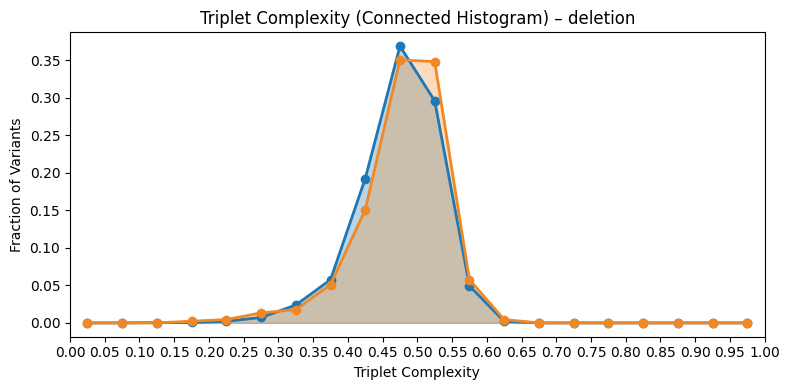

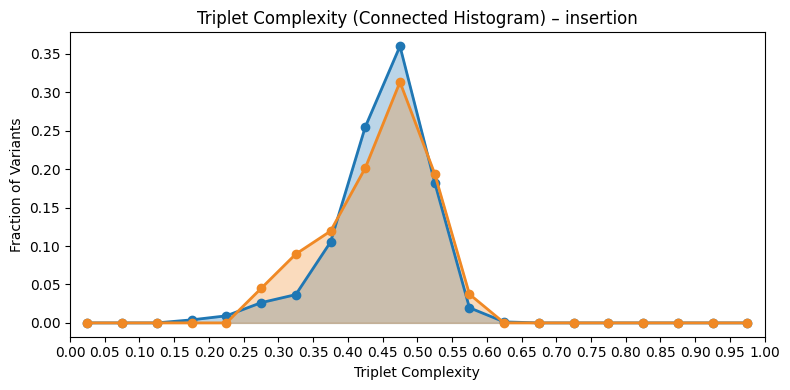

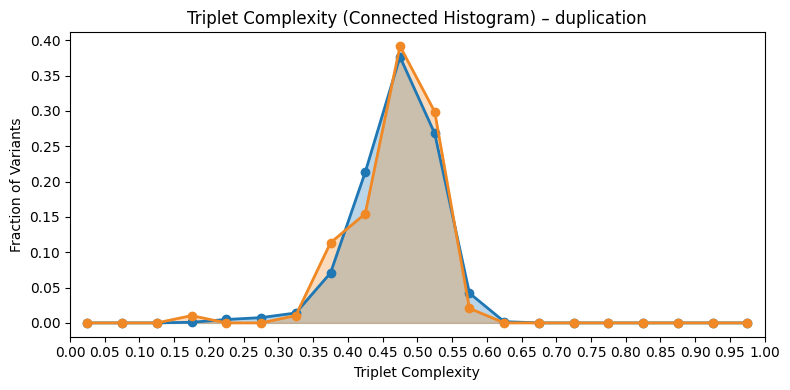

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

bw_adjust = 0.5  # smaller value = tighter fit; adjust as needed

# Add source column
df_many = indel_in_synthetic_data_detected_by_many_tools_df.copy()
df_many['source'] = 'Detected by >2 tools'
df_many['triplet_complexity'] = df_many['triplet_complexity'].str[1:-1]  # remove brackets

df_few = indel_in_synthetic_data_detected_by_few_tools_df.copy()
df_few['source'] = 'Detected by ≤2 tools'
df_few['triplet_complexity'] = df_few['triplet_complexity'].str[1:-1]

# Combine
combined_df = pd.concat([df_many, df_few], ignore_index=True)
combined_df = combined_df[~combined_df['triplet_complexity'].isna()]
combined_df['triplet_complexity'] = pd.to_numeric(combined_df['triplet_complexity'], errors='coerce')
# combined_df['triplet_complexity'] = combined_df['triplet_complexity'].round(2)

# Variant types to plot
variant_types = ['deletion', 'insertion', 'duplication']

bin_edges = np.arange(0, 1.05, 0.05)  # 0 to 1 in steps of 0.05
bin_centers = bin_edges[:-1] + 0.025

# Plot per variant type
for variant in variant_types:
    subset = combined_df[combined_df['vcrs_variant_type'] == variant]

    plt.figure(figsize=(8, 4))

    for source, color in zip(
        ['Detected by >2 tools', 'Detected by ≤2 tools'],
        ['#1f77b4', '#f08925']
    ):
        src_subset = subset[subset['source'] == source]
        counts, _ = np.histogram(src_subset['triplet_complexity'], bins=bin_edges)
        fraction = counts / counts.sum()  # convert to fraction

        plt.plot(bin_centers, fraction, marker='o', label=source, color=color, linewidth=2)
        plt.fill_between(bin_centers, 0, fraction, alpha=0.3, color=color)
    plt.xticks(bin_edges)

    plt.xlim(0, 1)
    plt.xlabel("Triplet Complexity")
    plt.ylabel("Fraction of Variants")
    plt.title(f"Triplet Complexity (Connected Histogram) – {variant}")
    # plt.legend()
    plt.tight_layout()
    plt.savefig(f"{fig2_output_dir}/missed_indels_triplet_complexity_distribution_connected_histogram_{variant}.pdf")
    plt.show()



### Let's actually look at some sequences

In [177]:
indel_in_synthetic_data_detected_by_few_tools_df.head()

vcrs_header order  \
7743        ENST00000007414:c.1548del   [0]   
31135    ENST00000080059:c.702_703dup   [0]   
33120  ENST00000155858:c.3140_3165del   [0]   
49478  ENST00000171887:c.3784_3832del   [0]   
72067        ENST00000203001:c.589del   [0]   

      alignment_to_reference_count_total    triplet_complexity  \
7743                                 [0]  [0.4597701149425287]   
31135                                [0]                 [0.4]   
33120                                [0]  [0.3736263736263736]   
49478                                [0]  [0.4659090909090909]   
72067                                [0]  [0.4523809523809524]   

       included_in_synthetic_reads  included_in_synthetic_reads_wt  \
7743                          True                            True   
31135                         True                            True   
33120                         True                            True   
49478                         True                            True   
72067                         True                            True   

       included_in_synthetic_reads_mutant  \
7743                                 True   
31135                                True   
33120                                True   
49478                                True   
72067                                True   

                        list_of_read_starting_indices_wt  \
7743   [61, 14, 29, 82, 123, 39, 103, 87, 17, 45, 89,...   
31135                                            [2, 87]   
33120  [67, 9, 124, 61, 79, 139, 5, 119, 14, 74, 157,...   
49478                                  [21, 69, 168, 74]   
72067  [94, 15, 100, 95, 65, 83, 2, 49, 125, 20, 140,...   

                    list_of_read_starting_indices_mutant  number_of_reads_wt  \
7743   [142, 49, 110, 140, 61, 83, 34, 18, 68, 25, 19...                16.0   
31135  [38, 134, 27, 33, 36, 55, 51, 100, 139, 31, 43...                 2.0   
33120  [14, 128, 82, 103, 68, 123, 96, 119, 84, 55, 1...                32.0   
49478  [102, 37, 38, 26, 85, 54, 60, 107, 126, 44, 13...                 4.0   
72067  [138, 131, 53, 79, 130, 6, 60, 35, 80, 133, 11...               128.0   

       number_of_reads_mutant  any_noisy_reads_wt  \
7743                    128.0                True   
31135                   256.0               False   
33120                   128.0                True   
49478                   128.0               False   
72067                   128.0                True   

                    noisy_read_indices_wt  any_noisy_reads_mutant  \
7743                                 [69]                    True   
31135                                  []                    True   
33120                         [5, 76, 44]                    True   
49478                                  []                    True   
72067  [73, 10, 37, 30, 109, 111, 89, 53]                    True   

                               noisy_read_indices_mutant  any_noisy_reads  \
7743     [110, 67, 31, 24, 99, 13, 23, 103, 81, 106, 16]             True   
31135  [55, 21, 86, 69, 34, 63, 88, 124, 87, 16, 139,...             True   
33120  [82, 113, 114, 57, 75, 121, 53, 98, 100, 26, 8...             True   
49478  [54, 126, 4, 103, 25, 77, 36, 104, 125, 138, 5...             True   
72067  [53, 100, 105, 88, 69, 0, 1, 97, 99, 113, 92, ...             True   

       tumor_purity  AD_ALT_varseek  mutation_detected_varseek  TP_varseek  \
7743       0.888889           121.0                       True        True   
31135      0.992248           243.0                       True        True   
33120      0.800000           124.0                       True        True   
49478      0.969697           119.0                       True        True   
72067      0.500000           116.0                       True        True   

       FP_varseek  FN_varseek  TN_varseek  \
7743        False       False       False   
31135       False       False       False   
33120      

In [120]:
mutation_metadata_df_path = os.path.join(varseek_directory, "data", "simulated_data_output", "mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv")
mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)

/tmp/ipykernel_278862/412172722.py:2: DtypeWarning: Columns (11,12,13,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)


In [ ]:
# mutation_metadata_df.head()

vcrs_header                    header  order           seq_ID  \
0  ENST00000391429:c.194C>T  ENST00000391429:c.194C>T      0  ENST00000391429   
1  ENST00000391429:c.128C>A  ENST00000391429:c.128C>A      0  ENST00000391429   
2  ENST00000391429:c.257C>A  ENST00000391429:c.257C>A      0  ENST00000391429   
3  ENST00000391429:c.100G>A  ENST00000391429:c.100G>A      0  ENST00000391429   
4   ENST00000391429:c.99G>A   ENST00000391429:c.99G>A      0  ENST00000391429   

  mutation_cdna  variant_type  \
0      c.194C>T  substitution   
1      c.128C>A  substitution   
2      c.257C>A  substitution   
3      c.100G>A  substitution   
4       c.99G>A  substitution   

                                         wt_sequence nucleotide_positions  \
0  GAGGCGGAGGAGCCGGCGGGCAGGAGGCGCGCGCGGCCGGTGCGGT...                  194   
1  CCCTGCCCCGAGCCCGGGGGCGATTCGGGGGTGCTGGGGGCGAACG...                  128   
2  GCCGCCAACGTGCGGGAGCGCAAGCGCATCCTAGACTACAACGAGG...                  257   
3  CGAGGACTCTGCGGAGGACTTGGGGGGCCCCTGCCCCGAGCCCGGG...                  100   
4  CCGAGGACTCTGCGGAGGACTTGGGGGGCCCCTGCCCCGAGCCCGG...                   99   

  actual_variant  mutation mutation_aa GENOMIC_MUTATION_ID chromosome  \
0            C>T  c.189C>T      p.S63=        COSV66953786         17   
1            C>A  c.123C>A      p.G41=        COSV66953766         17   
2            C>A  c.252C>A      p.A84=       COSV101195467         17   
3            G>A   c.95G>A      p.G32D        COSV66953819         17   
4            G>A   c.94G>A      p.G32S       COSV104700430         17   

  strand_original mutation_genome gene_name  mutation_id  \
0               +    g.1174046C>T    BHLHA9     43289988   
1               +    g.1173980C>A    BHLHA9     43290218   
2               +    g.1174109C>A    BHLHA9     43289971   
3               +    g.1173952G>A    BHLHA9     43289990   
4               +    g.1173951G>A    BHLHA9     43289934   

   start_transcript_position  end_transcript_position strand  \
0                    1173853                  1174754      +   
1                    1173853                  1174754      +   
2                    1173853                  1174754      +   
3                    1173853                  1174754      +   
4                    1173853                  1174754      +   

   start_variant_position  end_variant_position seq_ID_used_for_vcrs  \
0                     194                   194      ENST00000391429   
1                     128                   128      ENST00000391429   
2                     257                   257      ENST00000391429   
3                     100                   100      ENST00000391429   
4                      99                    99      ENST00000391429   

  variant_used_for_vcrs variant_source nucleotide_positions_cdna  \
0              c.194C>T           cdna                       194   
1              c.128C>A           cdna                       128   
2              c.257C>A           cdna                       257   
3              c.100G>A           cdna                       100   
4               c.99G>A           cdna                        99   

  actual_variant_cdna  start_variant_position_cdna  end_variant_position_cdna  \
0                 C>T                          194                        194   
1                 C>A                          128                        128   
2                 C>A                          257                        257   
3                 G>A                          100                        100   
4                 G>A                           99                         99   

  nucleotide_positions_genome actual_variant_genome  \
0                     1174046                   C>T   
1                     1173980                   C>A   
2                     1174109                   C>A   
3                     1173952                   G>A   
4                     1173951                   G>A   

   start_variant_posit

In [110]:
def align_sequences(ref, alt):
    # Simple alignment for a single insertion/deletion/duplication
    if ref == alt:
        return ref, alt  # no change

    min_len = min(len(ref), len(alt))
    
    # Find leftmost mismatch
    left = 0
    while left < min_len and ref[left] == alt[left]:
        left += 1

    # Find rightmost match
    right_ref = len(ref) - 1
    right_alt = len(alt) - 1
    while right_ref >= left and right_alt >= left and ref[right_ref] == alt[right_alt]:
        right_ref -= 1
        right_alt -= 1

    # Build aligned strings
    if len(ref) > len(alt):  # deletion
        alt_aligned = (
            alt[:left] +
            ' ' * (len(ref) - len(alt)) +
            alt[left:]
        )
        ref_aligned = ref
    else:  # insertion or duplication
        ref_aligned = (
            ref[:left] +
            ' ' * (len(alt) - len(ref)) +
            ref[left:]
        )
        alt_aligned = alt

    return ref_aligned, alt_aligned

In [111]:
number_to_sample = 5
variant_types_to_sample = ['deletion', 'insertion', 'duplication']
seed = 42
visually_align = True
overwrite_file = True
print_message = True
write_message = True

def print_and_write(message, file_out_path = None, print_message = True, write_message = True):
    if print_message:
        print(message)
    
    if not write_message:
        return
    
    write_mode = "a" if os.path.exists(file_out_path) else "w"
    with open(file_out_path, write_mode) as f:
        message += "\n"  # each new print statement adds a new line at the end by default
        f.write(message)

txt_output_path = os.path.join(fig2_output_dir, f"missed_indels_sequences_size{number_to_sample}_seed{seed}.txt")

if overwrite_file:
    with open(txt_output_path, "w") as f:
        f.write("")  # clear the file if it exists

for variant_type in variant_types_to_sample:
    print_and_write(f"Variant type == {variant_type}:\n", txt_output_path, print_message = print_message, write_message = write_message)
    selected_headers = (
        indel_in_synthetic_data_detected_by_few_tools_df
        .query(f"vcrs_variant_type == '{variant_type}'")
        ['vcrs_header']
        .sample(number_to_sample, random_state=seed)
        .to_list()
    )
    for variant_header_of_interest in selected_headers:
        wt_sequence = mutation_metadata_df.loc[mutation_metadata_df["header"] == variant_header_of_interest, "wt_sequence_read_parent"].values[0]
        mutant_sequence = mutation_metadata_df.loc[mutation_metadata_df["header"] == variant_header_of_interest, "mutant_sequence_read_parent"].values[0]
        print_and_write(f"Variant header: {variant_header_of_interest}", txt_output_path, print_message = print_message, write_message = write_message)
        
        if visually_align:
            wt_sequence, mutant_sequence = align_sequences(wt_sequence, mutant_sequence)

        print_and_write(f"REF: {wt_sequence}", txt_output_path, print_message = print_message, write_message = write_message)
        print_and_write(f"ALT: {mutant_sequence}\n", txt_output_path, print_message = print_message, write_message = write_message)

    print_and_write("\n---------------------\n\n", txt_output_path, print_message = print_message, write_message = write_message)

    # break  #!!! erase

Variant type == deletion:

Variant header: ENST00000374024:c.752_783del
REF: GCTGCCTGTGCTGGCCTGGAACTGCCTGGATGGCCTGACCACATGTGGCGTGGTTTATCCACTCTCCAAGAACCATCTGGTAGTTCTGGCCATTGCCTTCTTCATGGTGTTTGGCATCATGCTGCAGCTCTACGCCCAAATCTGCCGCATCGTCTGCCGCCATGCCCAGCAGATTGCCCTTCAGCGGCACCTGCTGCCTGCCTCCCACTATGTGGCCACCCGCAAGGGCATTGCCACACTGGCCGTGGTGCTTGGAGCCTTTGCCGCCTGCTGGTTGCCCTTCACTGTCTACTGCCTGCTGGGTGATGCCCACTCTCCACCTCT
ALT: GCTGCCTGTGCTGGCCTGGAACTGCCTGGATGGCCTGACCACATGTGGCGTGGTTTATCCACTCTCCAAGAACCATCTGGTAGTTCTGGCCATTGCCTTCTTCATGGTGTTTGGCATCATGCTGCAGCTCTACGCCCAAATCTGCC                                CTTCAGCGGCACCTGCTGCCTGCCTCCCACTATGTGGCCACCCGCAAGGGCATTGCCACACTGGCCGTGGTGCTTGGAGCCTTTGCCGCCTGCTGGTTGCCCTTCACTGTCTACTGCCTGCTGGGTGATGCCCACTCTCCACCTCT

Variant header: ENST00000256474:c.1067_1161del
REF: AGACGGCGGGGAGGAGTCGGGCGCCGAGGAGTCCGGCCCGGAAGAGTCCGGCCCGGAGGAACTGGGCGCCGAGGAGGAGATGGAGGCCGGGCGGCCGCGGCCCGTGCTGCGCTCGGTGAACTCGCGCGAGCCCTCCCAGGTCATCTTCTGCAATCGCAGTCCGCGCGTCGTGCTGCCCGTATGGCTCAACTTCGACGGCGAGCCGCAGCCCTACC

In [112]:
if 'wt_sequence' not in indel_in_synthetic_data_detected_by_many_tools_df.columns:
    indel_in_synthetic_data_detected_by_many_tools_df = indel_in_synthetic_data_detected_by_many_tools_df.merge(
        mutation_metadata_df[['vcrs_header', 'wt_sequence_read_parent', 'mutant_sequence_read_parent']],
        on='vcrs_header',
        how='left'
    )

    indel_in_synthetic_data_detected_by_many_tools_df.rename(columns={
        'wt_sequence_read_parent': 'wt_sequence',
        'mutant_sequence_read_parent': 'mutant_sequence'
    }, inplace=True)
    

if 'wt_sequence' not in indel_in_synthetic_data_detected_by_few_tools_df.columns:
    indel_in_synthetic_data_detected_by_few_tools_df = indel_in_synthetic_data_detected_by_few_tools_df.merge(
        mutation_metadata_df[['vcrs_header', 'wt_sequence_read_parent', 'mutant_sequence_read_parent']],
        on='vcrs_header',
        how='left'
    )

    indel_in_synthetic_data_detected_by_few_tools_df.rename(columns={
        'wt_sequence_read_parent': 'wt_sequence',
        'mutant_sequence_read_parent': 'mutant_sequence'
    }, inplace=True)

In [113]:
def insertion_disrupts_homopolymer(wt, alt, min_length=3):
    if len(alt) <= len(wt):
        return False  # Sanity check: only apply to insertions/duplications

    # Find first position where sequences differ
    prefix_len = 0
    while prefix_len < min(len(wt), len(alt)) and wt[prefix_len] == alt[prefix_len]:
        prefix_len += 1

    # Insertion happened at index `prefix_len` in alt
    insert_index = prefix_len

    if insert_index == 0 or insert_index >= len(alt):
        return False  # cannot check homopolymer safely

    # Step 2: Expand from insertion site in alt
    base = alt[insert_index - 1]  # base immediately before insertion
    left = insert_index - 1
    right = insert_index

    while left > 0 and alt[left - 1] == base:
        left -= 1
    while right < len(alt) and alt[right] == base:
        right += 1

    homopolymer_length = right - left
    return homopolymer_length >= min_length

def deletion_cuts_into_homopolymer(wt, alt, min_length=3):
    if len(wt) <= len(alt):
        return False  # not a deletion

    # Step 1: find prefix match
    prefix_len = 0
    while prefix_len < min(len(wt), len(alt)) and wt[prefix_len] == alt[prefix_len]:
        prefix_len += 1

    # Step 2: identify where deletion starts and ends in wt
    deletion_start = prefix_len
    deletion_end = deletion_start + (len(wt) - len(alt))  # exclusive

    # Step 3: scan left and right of the deletion site in wt
    def longest_homopolymer_centered_at(pos):
        base = wt[pos]
        left = pos
        right = pos

        # Expand left
        while left > 0 and wt[left - 1] == base:
            left -= 1
        # Expand right
        while right + 1 < len(wt) and wt[right + 1] == base:
            right += 1

        return left, right  # inclusive indices

    # Check start and end of deletion site
    positions_to_check = []
    if deletion_start < len(wt):
        positions_to_check.append(deletion_start)
    if deletion_end - 1 < len(wt):
        positions_to_check.append(deletion_end - 1)

    for pos in positions_to_check:
        if pos < 0 or pos >= len(wt):
            continue
        left, right = longest_homopolymer_centered_at(pos)
        if (right - left + 1) >= min_length:
            return True

    return False

def disrupts_homopolymer_wrapper(row, min_length=3):
    if row["vcrs_variant_type"] in ["insertion", "duplication"]:
        return insertion_disrupts_homopolymer(
            row["wt_sequence"], row["mutant_sequence"], min_length=min_length
        )
    elif row["vcrs_variant_type"] == "deletion":
        return deletion_cuts_into_homopolymer(
            row["wt_sequence"], row["mutant_sequence"], min_length=min_length
        )
    else:
        return False

import numpy as np

def analyze_mutation_context(row, number_nucleotides_to_edge = 20, number_nucleotides_for_complexity = 15, single_reading_frame = True):
    wt = row["wt_sequence"]
    alt = row["mutant_sequence"]

    # Find mutation index (first mismatch)
    mutation_index = 0
    while mutation_index < min(len(wt), len(alt)) and wt[mutation_index] == alt[mutation_index]:
        mutation_index += 1

    # Define outputs
    mutation_in_first_20 = mutation_index <= number_nucleotides_to_edge
    mutation_in_last_20 = (len(wt) - mutation_index) <= number_nucleotides_to_edge
    mutation_in_first_or_last = mutation_in_first_20 or mutation_in_last_20

    # Preceding triplets
    if mutation_index >= number_nucleotides_for_complexity:
        preceding_seq = wt[mutation_index - number_nucleotides_for_complexity:mutation_index]
        if single_reading_frame:
            preceding_triplets = {preceding_seq[i:i+3] for i in range(0, len(preceding_seq) - 2, 3)}
        else:
            preceding_triplets = {preceding_seq[i:i+3] for i in range(len(preceding_seq) - 2)}
        num_preceding_triplets = len(preceding_triplets)
    else:
        num_preceding_triplets = np.nan

    # Following triplets
    if (len(wt) - mutation_index) >= number_nucleotides_for_complexity:
        following_seq = wt[mutation_index:mutation_index + number_nucleotides_for_complexity]
        if single_reading_frame:
            following_triplets = {following_seq[i:i+3] for i in range(0, len(following_seq) - 2, 3)}
        else:
            following_triplets = {following_seq[i:i+3] for i in range(len(following_seq) - 2)}
        num_following_triplets = len(following_triplets)
    else:
        num_following_triplets = np.nan
    
    preceding_and_following_triplets = preceding_triplets | following_triplets
    num_preceding_and_following_triplets = len(preceding_and_following_triplets)

    return pd.Series({
        f"mutation_in_first_{number_nucleotides_to_edge}_bases": mutation_in_first_20,
        f"mutation_in_last_{number_nucleotides_to_edge}_bases": mutation_in_last_20,
        f"mutation_in_first_or_last_{number_nucleotides_to_edge}_bases": mutation_in_first_or_last,
        f"number_unique_triplets_in_preceding_{number_nucleotides_for_complexity}_nucleotides": num_preceding_triplets,
        f"number_unique_triplets_in_following_{number_nucleotides_for_complexity}_nucleotides": num_following_triplets,
        f"number_unique_triplets_in_preceding_and_following_{number_nucleotides_for_complexity}_nucleotides": num_preceding_and_following_triplets,
    })


In [114]:
min_homopolymer_length = 3
number_nucleotides_to_edge = 20
number_nucleotides_for_complexity = 15


indel_in_synthetic_data_detected_by_many_tools_df["disrupts_homopolymer"] = (
    indel_in_synthetic_data_detected_by_few_tools_df.apply(
        lambda row: disrupts_homopolymer_wrapper(row, min_length=min_homopolymer_length),
        axis=1
    )
)

indel_in_synthetic_data_detected_by_many_tools_df[
    [
        f"mutation_in_first_{number_nucleotides_to_edge}_bases",
        f"mutation_in_last_{number_nucleotides_to_edge}_bases",
        f"mutation_in_first_or_last_{number_nucleotides_to_edge}_bases",
        f"number_unique_triplets_in_preceding_{number_nucleotides_for_complexity}_nucleotides",
        f"number_unique_triplets_in_following_{number_nucleotides_for_complexity}_nucleotides",
        f"number_unique_triplets_in_preceding_and_following_{number_nucleotides_for_complexity}_nucleotides"
    ]
] = (
    indel_in_synthetic_data_detected_by_many_tools_df.apply(
        lambda row: analyze_mutation_context(row, number_nucleotides_to_edge=number_nucleotides_to_edge, number_nucleotides_for_complexity=number_nucleotides_for_complexity),
        axis=1
    )
)





indel_in_synthetic_data_detected_by_few_tools_df["disrupts_homopolymer"] = (
    indel_in_synthetic_data_detected_by_few_tools_df.apply(
        lambda row: disrupts_homopolymer_wrapper(row, min_length=min_homopolymer_length),
        axis=1
    )
)

indel_in_synthetic_data_detected_by_few_tools_df[
    [
        f"mutation_in_first_{number_nucleotides_to_edge}_bases",
        f"mutation_in_last_{number_nucleotides_to_edge}_bases",
        f"mutation_in_first_or_last_{number_nucleotides_to_edge}_bases",
        f"number_unique_triplets_in_preceding_{number_nucleotides_for_complexity}_nucleotides",
        f"number_unique_triplets_in_following_{number_nucleotides_for_complexity}_nucleotides",
        f"number_unique_triplets_in_preceding_and_following_{number_nucleotides_for_complexity}_nucleotides"
    ]
] = (
    indel_in_synthetic_data_detected_by_few_tools_df.apply(
        lambda row: analyze_mutation_context(row, number_nucleotides_to_edge=number_nucleotides_to_edge, number_nucleotides_for_complexity=number_nucleotides_for_complexity),
        axis=1
    )
)

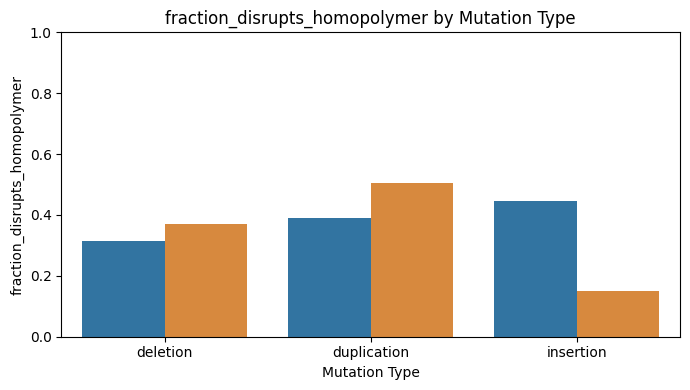

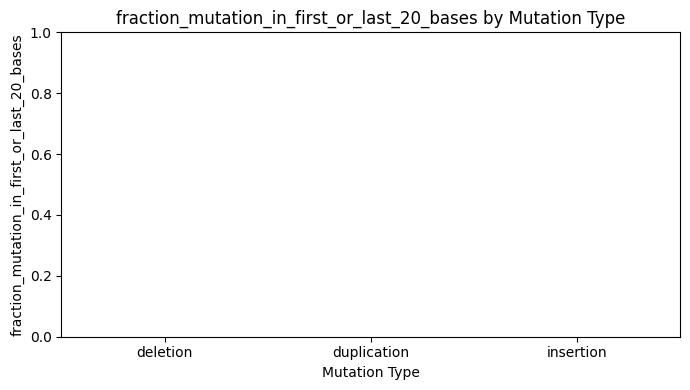

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_fraction_of_boolean_column_per_variant_type_and_make_bar_plot(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, boolean_column):
    # Create a helper function
    def compute_boolean_fraction(df, label, boolean_column, new_column_name):
        grouped = df.groupby("vcrs_variant_type")[boolean_column]
        result = grouped.mean().reset_index()  # mean of bool == fraction True
        result.columns = ["vcrs_variant_type", new_column_name]
        result["source"] = label
        return result

    new_column_name = f"fraction_{boolean_column}"

    # Compute for each
    df_many_grouped = compute_boolean_fraction(
        indel_in_synthetic_data_detected_by_many_tools_df, "Detected by >2 tools", boolean_column, new_column_name
    )
    df_few_grouped = compute_boolean_fraction(
        indel_in_synthetic_data_detected_by_few_tools_df, "Detected by ≤2 tools", boolean_column, new_column_name
    )

    # Combine
    summary_df = pd.concat([df_many_grouped, df_few_grouped], ignore_index=True)

    # Plot
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(
        data=summary_df,
        x="vcrs_variant_type",
        y=new_column_name,
        hue="source",
        legend=False,  # comment out to include legend
        palette={
            'Detected by >2 tools': detected_by_most_tools_color,
            'Detected by ≤2 tools': detected_by_few_tools_color 
        },
    )
    ax.set_ylabel(new_column_name)
    ax.set_xlabel("Mutation Type")
    ax.set_title(f"{new_column_name} by Mutation Type")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{fig2_output_dir}/missed_indels_{new_column_name}_fraction.pdf")
    plt.show()

calculate_fraction_of_boolean_column_per_variant_type_and_make_bar_plot(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, boolean_column = "disrupts_homopolymer")
calculate_fraction_of_boolean_column_per_variant_type_and_make_bar_plot(indel_in_synthetic_data_detected_by_many_tools_df, indel_in_synthetic_data_detected_by_few_tools_df, boolean_column = f"mutation_in_first_or_last_{number_nucleotides_to_edge}_bases")

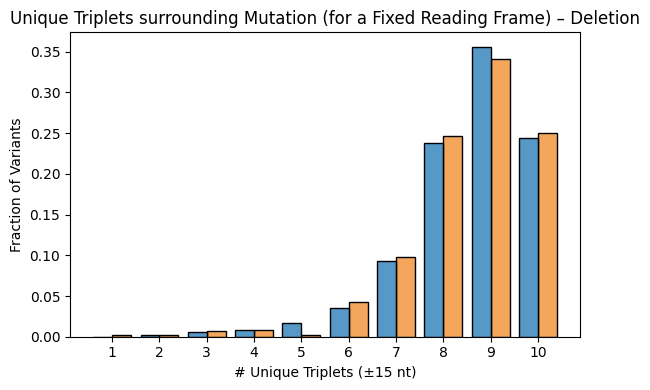

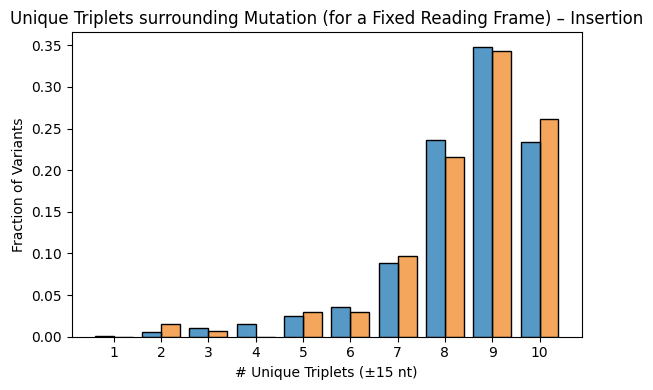

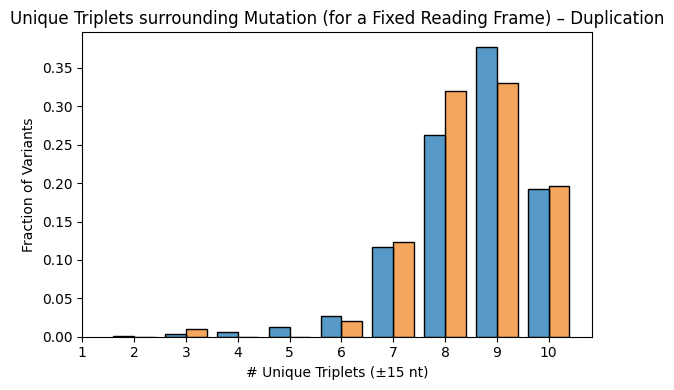

In [116]:
# Setup
column_name = f"number_unique_triplets_in_preceding_and_following_{number_nucleotides_for_complexity}_nucleotides"

# Tag source
df_many = indel_in_synthetic_data_detected_by_many_tools_df.copy()
df_many["source"] = "Detected by >2 tools"

df_few = indel_in_synthetic_data_detected_by_few_tools_df.copy()
df_few["source"] = "Detected by ≤2 tools"

# Combine
combined_df = pd.concat([df_many, df_few], ignore_index=True)

# Drop NA from the target column
combined_df = combined_df.dropna(subset=[column_name])

# Ensure the column is integer (needed for count-based binning)
combined_df[column_name] = combined_df[column_name].astype(int)

# Determine x-range dynamically
x_min = combined_df[column_name].min()
x_max = combined_df[column_name].max()
x_vals = list(range(x_min, x_max + 1))

# Plot per variant type
for variant in ['deletion', 'insertion', 'duplication']:
    subset = combined_df[combined_df['vcrs_variant_type'] == variant]

    plt.figure(figsize=(6, 4))
    ax = sns.histplot(
        data=subset,
        x=column_name,
        hue='source',
        stat='probability',
        common_norm=False,
        discrete=True,  # treat x-axis as categorical integers
        multiple='dodge',  # side-by-side bars
        shrink=0.8,
        palette={
            'Detected by >2 tools': detected_by_most_tools_color,
            'Detected by ≤2 tools': detected_by_few_tools_color
        },
        legend=False  # set to True to include legend
    )

    ax.set_xticks(x_vals)
    ax.set_xlabel(f"# Unique Triplets (±{number_nucleotides_for_complexity} nt)")
    ax.set_ylabel("Fraction of Variants")
    ax.set_title(f"Unique Triplets surrounding Mutation (for a Fixed Reading Frame) – {variant.title()}")
    plt.tight_layout()
    plt.savefig(f"{fig2_output_dir}/missed_indels_unique_triplets_local_{variant}.pdf")
    plt.show()


In [19]:
indel_in_synthetic_data_detected_by_few_tools_df.head(50)

vcrs_header   order  \
7743                            ENST00000007414:c.1548del     [0]   
31135                        ENST00000080059:c.702_703dup     [0]   
33120                      ENST00000155858:c.3140_3165del     [0]   
49478                      ENST00000171887:c.3784_3832del     [0]   
72067                            ENST00000203001:c.589del     [0]   
91293                      ENST00000215832:c.1143_1154del     [0]   
97389                            ENST00000216139:c.610del     [0]   
111663                       ENST00000216797:c.333_340del     [0]   
111706                       ENST00000216797:c.447_451del     [0]   
126809                     ENST00000218089:c.1249_1271del     [0]   
127359                          ENST00000218089:c.2866dup     [0]   
134562                       ENST00000219169:c.455_456del     [0]   
144735                     ENST00000219905:c.7711_7755del     [0]   
146523                       ENST00000220429:c.471_499del     [0]   
162693                     ENST00000221494:c.1654_1674del     [0]   
173349                          ENST00000222270:c.3057del     [0]   
178171                     ENST00000222390:c.2365_2399del     [0]   
186973                   ENST00000223127:c.1276_1277insGG     [0]   
203886                          ENST00000225964:c.2569dup     [0]   
228572                       ENST00000229268:c.484_488del     [0]   
234105                       ENST00000230036:c.873_900del     [0]   
243506                     ENST00000231130:c.1737_1749del     [0]   
255039                          ENST00000232603:c.1262dup     [0]   
260124                    ENST00000233146:c.2386_2387insA     [0]   
275973                      ENST00000234875:c.295_296insA     [0]   
284446                     ENST00000237289:c.2166_2188del     [0]   
287122                          ENST00000237612:c.2200dup     [0]   
293336                     ENST00000238823:c.1526_1561dup     [0]   
312678                     ENST00000241052:c.1150_1223del     [0]   
315156                     ENST00000241453:c.1828_1875dup     [0]   
315168                     ENST00000241453:c.1834_1881dup     [0]   
315169                     ENST00000241453:c.1835_1864dup     [0]   
315189                     ENST00000241453:c.1846_1875dup     [0]   
315213                     ENST00000241453:c.1852_1875dup     [0]   
315249                     ENST00000241453:c.1859_1882dup     [0]   
315324  ENST00000241453:c.1874_1875insGGGACGTTGATTTCAG...     [0]   
315391  ENST00000241453:c.1893_1894insCCCCCGGATTGATTTC...     [0]   
315404                     ENST00000241453:c.1899_1919dup     [0]   
315412  ENST00000241453:c.1907_1908insTTTAGAGTTTCACCCT...     [0]   
316022                       ENST00000241453:c.453_455del     [0]   
330266                     ENST00000243326:c.5721_5741del     [0]   
330587                           ENST00000243326:c.988del     [0]   
336318  ENST00000244174:c.1420del;ENST00000244174:c.14...  [0, 1]   
342025                       ENST00000244527:c.903_964del     [0]   
350340                     ENST00000245479:c.1269_1311del     [0]   
353197                           ENST00000245564:c.613del     [0]   
387036                       ENST00000249373:c.414_437del     [0]   
392107                       ENST00000250092:c.431_472del     [0]   
394570                     ENST00000250448:c.1020_1041del     [0]   
395068                       ENST00000250448:c.842_914del     [0]   

       alignment_to_reference_count_total  \
7743                                  [0]   
31135                                 [0]   
33120                                 [0]   
49478                                 [0]   
72067                                 [0]   
91293                                 [0]   
97389                                 [0]   
111663                                [0]   
111706                                [0]   
126809                                [0]   
127359                         

In [14]:
indel_in_synthetic_data_detected_by_few_tools_df['vcrs_variant_type'].unique()

array(['deletion', 'duplication', 'insertion'], dtype=object)

In [12]:
indel_in_synthetic_data_df.head(2)

vcrs_header order alignment_to_reference_count_total  \
267  ENST00000001008:c.559del   [0]                                [0]   
708  ENST00000002125:c.335dup   [0]                                [0]   

       triplet_complexity  included_in_synthetic_reads  \
267  [0.5517241379310345]                         True   
708  [0.5168539325842697]                         True   

     included_in_synthetic_reads_wt  included_in_synthetic_reads_mutant  \
267                           False                                True   
708                            True                                True   

       list_of_read_starting_indices_wt  \
267                                   0   
708  [83, 79, 116, 36, 29, 129, 17, 94]   

                  list_of_read_starting_indices_mutant  number_of_reads_wt  \
267  [135, 70, 59, 129, 41, 8, 80, 16, 49, 67, 140,...                 0.0   
708  [72, 36, 108, 108, 67, 120, 70, 124, 15, 9, 58...                 8.0   

     number_of_reads_mutant  any_noisy_reads_wt noisy_read_indices_wt  \
267                   256.0               False                     0   
708                   256.0                True                  [36]   

     any_noisy_reads_mutant  \
267                    True   
708                    True   

                             noisy_read_indices_mutant  any_noisy_reads  \
267  [59, 29, 133, 15, 78, 140, 18, 139, 64, 89, 12...             True   
708  [108, 33, 61, 49, 97, 72, 142, 25, 66, 131, 76...             True   

     tumor_purity  AD_ALT_varseek  mutation_detected_varseek  TP_varseek  \
267      1.000000           243.0                       True        True   
708      0.969697           244.0                       True        True   

     FP_varseek  FN_varseek  TN_varseek  \
267       False       False       False   
708       False       False       False   

     number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere  \
267                                                243                          
708                                                244                          

     number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere  \
267                                               13.0                             
708                                               12.0                             

     mutation_expression_prediction_error_varseek  \
267                                         -13.0   
708                                         -12.0   

     number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere  \
267                                                  0                      
708                                                  0                      

     number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere  \
267                                                0.0                         
708                                                8.0                         

     number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly  \
267                                              243.0                        
708                                              244.0                        

     received_an_aligned_read_from_one_of_its_corresponding_reads  \
267                                               True              
708                                               True              

                   reads_mapped_to_this_reference_item  \
267  ['ENST00000001008:c.559del_135fM_5632', 'ENST0...   
708  ['ENST00000002125:c.335dup_72fM_69168', 'ENST0...   

     contained_any_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere  \
267                                               True                              
708                                               True                              

     contained_any_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere  \
267                                       

In [ ]:
synthetic_reads_csv_path = "/data/simulated_data_output/synthetic_reads_updated.parquet"
bam_file_path = "/data/variant_simulation_alternative_tools/alignment/sample_Aligned.sortedByCoord.out.bam"


synthetic_reads_df = pd.read_parquet(synthetic_reads_csv_path, columns = ["read_id", "vcrs_header"])
synthetic_reads_df_filtered = synthetic_reads_df.loc[synthetic_reads_df["vcrs_header"].isin(vcrs_headers_in_at_most_2_tools)]

sam_file_path = bam_file_path.replace(".bam", ".sam")
output_sam_path = sam_file_path.replace(".sam", "_filtered.sam")

read_ids_in_selected_VCRSs = set(synthetic_reads_df_filtered["read_id"].tolist())
read_id_to_vcrs_header_dict = synthetic_reads_df_filtered.set_index('read_id')['vcrs_header'].to_dict()
vcrs_header_to_sam_count_dict = {vcrs_header: 0 for vcrs_header in vcrs_headers_in_at_most_2_tools}

if not os.path.isfile(sam_file_path):
    !samtools view -h -o {sam_file_path} {bam_file_path}

sam_total_lines = 30_578_771  # fill in here if known
if sam_total_lines is None:
    with open(sam_file_path, 'r') as infile:
        sam_total_lines = sum(1 for _ in infile)

# if not os.path.isfile(output_sam_path):  # commented out because I need to make vcrs_header_to_sam_count_dict regardless of whether the output file exists or not
read_ids_used = set()
with open(sam_file_path, 'r') as infile, open(output_sam_path, 'w') as outfile:
    for line in tqdm(infile, total=sam_total_lines):
        if line.startswith('@'):
            # Always keep SAM header lines
            outfile.write(line)
        else:
            fields = line.strip().split('\t')
            read_id = fields[0]
            if read_id in read_ids_in_selected_VCRSs:
                outfile.write(line)
                vcrs_header = read_id_to_vcrs_header_dict[read_id]
                if not read_id in read_ids_used:  # avoids double-counting multimapped reads
                    vcrs_header_to_sam_count_dict[vcrs_header] += 1
                    read_ids_used.add(read_id)

# vcrs_header_to_sam_count_dict = {'ENST00000001008:c.418C>G': 262,
#  'ENST00000001008:c.702T>C': 4,
#  'ENST00000001008:c.1294dup': 11,
#  'ENST00000001008:c.1353_1354delinsTT': 6,
#  'ENST00000001008:c.1451_1453del': 12}

100%|██████████| 30578771/30578771 [00:52<00:00, 585065.18it/s]


In [20]:
indel_in_synthetic_data_detected_by_few_tools_df['sam_read_count'] = indel_in_synthetic_data_detected_by_few_tools_df['vcrs_header'].map(vcrs_header_to_sam_count_dict)
for col in ["number_of_reads_mutant", "number_of_reads_wt", "sam_read_count"]:
    indel_in_synthetic_data_detected_by_few_tools_df[col] = indel_in_synthetic_data_detected_by_few_tools_df[col].fillna(0).astype(int)

indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_total'] = indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_mutant'] + indel_in_synthetic_data_detected_by_few_tools_df['number_of_reads_wt']
indel_in_synthetic_data_detected_by_few_tools_df[['vcrs_header', 'number_of_reads_total', 'number_of_reads_wt', 'number_of_reads_mutant', 'sam_read_count']].head()

vcrs_header  number_of_reads_total  \
267            ENST00000001008:c.559del                    256   
1461          ENST00000002829:c.2652del                    131   
1667     ENST00000003084:c.1492_1494del                    262   
2174          ENST00000003084:c.3905dup                    192   
2555  ENST00000003100:c.805_806delinsTT                    263   

      number_of_reads_wt  number_of_reads_mutant  sam_read_count  
267                    0                     256             256  
1461                   3                     128             131  
1667                   6                     256             262  
2174                  64                     128             192  
2555                   7                     256             263

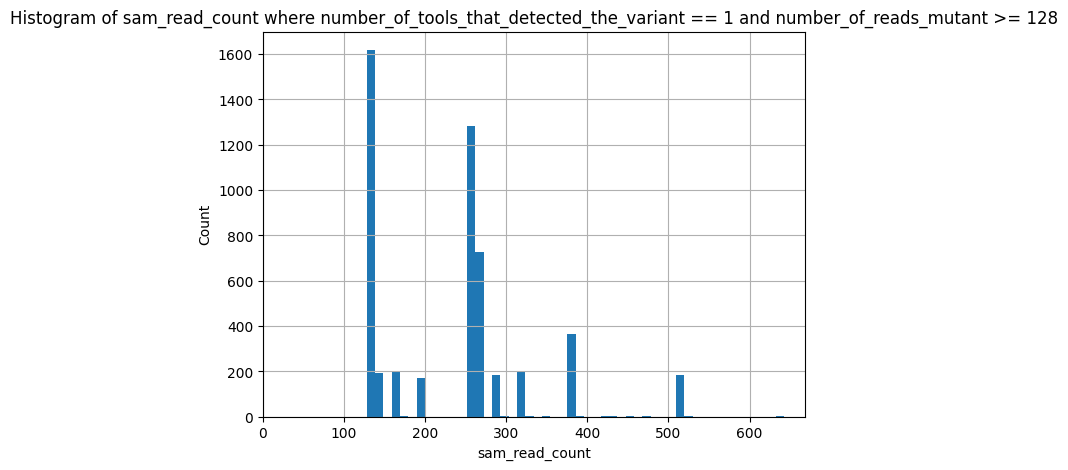

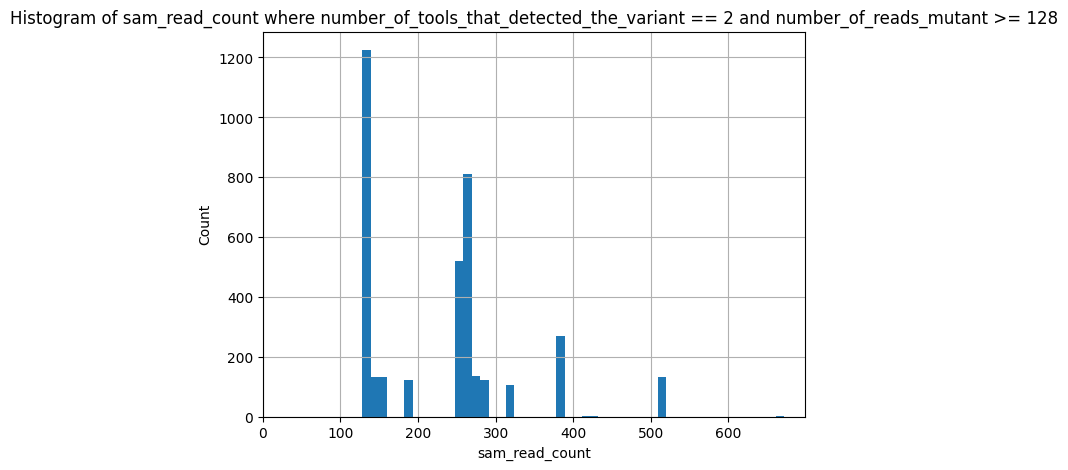

In [21]:
def make_sam_count_histogram(df, title = "sam_read_count histogram"):
    df = df.copy()
    plt.figure(figsize=(7, 5))   # <<< NEW FIGURE EACH TIME

    ax = df["sam_read_count"].hist(
        bins=50
    )

    # ax.set_yscale("log")
    ax.set_xlim(left=0)
    ax.set_xlabel("sam_read_count")
    ax.set_ylabel("Count")
    if title:
        ax.set_title(title)

    plt.show()  # make sure it shows before next plot

make_sam_count_histogram(indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["number_of_tools_that_detected_the_variant"] == 1], title = f"Histogram of sam_read_count where number_of_tools_that_detected_the_variant == 1 and number_of_reads_mutant >= {number_of_reads_mutant_min}")
make_sam_count_histogram(indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["number_of_tools_that_detected_the_variant"] == 2], title = f"Histogram of sam_read_count where number_of_tools_that_detected_the_variant == 2 and number_of_reads_mutant >= {number_of_reads_mutant_min}")

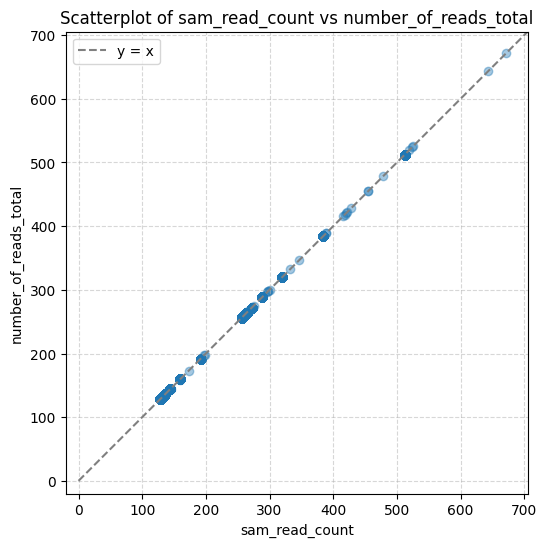

In [22]:
# Determine the maximum value across both columns
max_value = max(
    indel_in_synthetic_data_detected_by_few_tools_df["sam_read_count"].max(),
    indel_in_synthetic_data_detected_by_few_tools_df["number_of_reads_total"].max()
)

# Optionally add a small margin
max_value *= 1.05

plt.figure(figsize=(6,6))

# Scatterplot
plt.scatter(
    indel_in_synthetic_data_detected_by_few_tools_df["sam_read_count"],
    indel_in_synthetic_data_detected_by_few_tools_df["number_of_reads_total"],
    alpha=0.4
)

# y = x line
plt.plot([0, max_value], [0, max_value], color="grey", linestyle="--", label="y = x")

# Axis limits
plt.xlim(-20, max_value)
plt.ylim(-20, max_value)

# Make the aspect ratio square
plt.gca().set_aspect('equal', adjustable='box')

# Labels and title
plt.xlabel("sam_read_count")
plt.ylabel("number_of_reads_total")
plt.title("Scatterplot of sam_read_count vs number_of_reads_total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [23]:
has_semicolon = pd.Series(synthetic_reads_df_filtered['vcrs_header'].unique()).str.contains(";")
fraction_with_semicolon = has_semicolon.mean()
fraction_with_semicolon

0.012887180646619941

In [24]:
pd.Series(synthetic_reads_df_filtered['vcrs_header'].unique()).head(16)

0     ENST00000252085:c.2930_2932del;ENST00000252087...
1     ENST00000215754:c.728_729delinsGT;ENST00000433...
2     ENST00000252085:c.2915_2917del;ENST00000252087...
3     ENST00000296859:c.4268del;ENST00000514667:c.43...
4     ENST00000331531:c.904del;ENST00000571730:c.135...
5     ENST00000375832:c.530del;ENST00000503322:c.511del
6     ENST00000426342:c.1153_1154delinsTT;ENST000004...
7     ENST00000310137:c.250del;ENST00000412278:c.206del
8     ENST00000380371:c.609del;ENST00000380373:c.635del
9     ENST00000321826:c.1143_1147del;ENST00000393796...
10    ENST00000305139:c.1694_1695delinsGG;ENST000003...
11    ENST00000259053:c.286del;ENST00000504764:c.519...
12     ENST00000299367:c.301del;ENST00000456570:c.80del
13    ENST00000296859:c.388dup;ENST00000514667:c.519dup
14                       ENST00000262577:c.2669_2671del
15                             ENST00000407847:c.503del
dtype: object

In [25]:
# choose one of the entries above (without a semicolon)
chosen_vcrs_header = "ENST00000407847:c.503del"
synthetic_reads_df_filtered.loc[synthetic_reads_df_filtered["vcrs_header"] == chosen_vcrs_header][:5]

read_id               vcrs_header
6029356     vcrs_5331094_5rM_258  ENST00000407847:c.503del
6029357    vcrs_5331094_37fM_259  ENST00000407847:c.503del
6029358    vcrs_5331094_47rM_260  ENST00000407847:c.503del
6029359    vcrs_5331094_27fM_261  ENST00000407847:c.503del
6029360  vcrs_5331094_110fMn_262  ENST00000407847:c.503del

In [26]:
# choose one of the read IDs above
chosen_read_id = 'vcrs_5331094_5rM_258'
!grep {chosen_read_id} {output_sam_path}

vcrs_5331094_5rM_258	16	5	122425798	60	8S142M	*	0	0	TCCCTCACGAGGCGCAGGCCCGCTCAAGGGCAGCGGCGCCGCGGGTCTCCTGAGCGCGCCGCAGCCTCTTCAGCCGCCGCCGCCGCCCCCGCCCCCGGAGCGCGCTGAGCCTCCGCCGGACAGCCTGCGCCCGCGGCCCGCCTCTCTCTC	IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII	NH:i:1	HI:i:1	AS:i:140	nM:i:0


In [ ]:
# does anything remotely close to this position occur in my output VCFs?
alt_tool_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz"
position = "122425798"

position = position[:-4]  # chop off last 4 characters to have it be within roughly ± 10_000 bp of the position in the VCF
!zgrep {position} {alt_tool_vcf}

1	212242032	.	G	A	89.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-9.757;DP=103;ExcessHet=0.0000;FS=1.053;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=0.88;ReadPosRankSum=-0.819;SOR=0.456	GT:AD:DP:GQ:PL	0/1:86,16:102:97:97,0,2426
14	51224285	.	G	A	1371.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-9.033;DP=108;ExcessHet=0.0000;FS=1.583;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=13.06;ReadPosRankSum=2.591;SOR=0.648	GT:AD:DP:GQ:PL	0/1:45,60:105:99:1379,0,1142
15	81224244	.	A	G	1159.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=8.516;DP=105;ExcessHet=0.0000;FS=4.820;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=11.04;ReadPosRankSum=0.730;SOR=0.707	GT:AD:DP:GQ:PL	0/1:59,46:105:99:1167,0,1307
16	84256020	.	G	A	1687.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-22.526;DP=576;ExcessHet=0.0000;FS=5.151;MLEAC=1;MLEAF=0.500;MQ=60.00;MQRankSum=0.000;QD=2.99;ReadPosRankSum=0.816;SOR=0.887	GT:AD:DP:GQ:PL	0/1:436,128:564:99:1695,0,12242
19	41712242	.	C	T	27.64	.	AC=1;AF=0.500;AN=2;BaseQRankSum=-4.598;DP=54;ExcessHet=0.000

In [ ]:
# does anything remotely close to this position occur in my output VCFs?
alt_tool_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools/results/variants/variants.vcf.gz"
position = "122425798"

position = position[:-4]  # chop off last 4 characters to have it be within roughly ± 10_000 bp of the position in the VCF
!zgrep {position} {alt_tool_vcf}

1	163122424	.	G	C	0	LowGQX;NoPassedVariantGTs	SNVHPOL=4;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:7:0:51:0:50,1:24,0:26,1:0.0:LowGQX:8,0,370
1	212242023	.	G	A	20	PASS	SNVHPOL=2;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:52:9:100:0:93,7:42,1:51,6:-24.7:PASS:54,0,370
1	212242032	.	G	A	75	PASS	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:108:14:103:0:87,16:37,8:50,8:-23.3:PASS:109,0,370
10	46122428	.	A	T	0	LowGQX;NoPassedVariantGTs	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:3:0:75:0:74,1:34,1:40,0:0.0:LowGQX:3,0,370
10	127512242	.	A	G	0	LowGQX;NoPassedVariantGTs	SNVHPOL=2;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:6:0:57:0:56,1:30,0:26,1:0.0:LowGQX:7,0,370
11	28112242	.	C	G	0	LowGQX;NoPassedVariantGTs	SNVHPOL=3;MQ=60	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:5:0:63:0:62,1:36,1:26,0:0.0:LowGQX:5,0,370
14	50122426	.	C	A	0	LowGQX;NoPassedVariantGTs	SNVHPOL=2;MQ=57	GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL	0/1:16:0:22:0:21,1:9,1:12,0:0.0:LowGQX:17,0,345
14	501

In [29]:
# find the VCRS VCF ID for the chosen VCRS id
chosen_vcrs_vcf_id = indel_in_synthetic_data_detected_by_few_tools_df.loc[indel_in_synthetic_data_detected_by_few_tools_df["vcrs_header"] == chosen_vcrs_header, "VCF_ID"].values[0]
chosen_vcrs_vcf_id

'variant_4337984'

In [ ]:
# search for this VCRS VCF ID in the COSMIC ground truth VCF
cosmic_vcf = "/home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz"
!zgrep {chosen_vcrs_vcf_id} {cosmic_vcf}

5	122425797	variant_4337984	GG	G	.	PASS	.	GT	0/1


In [31]:
import pyfastx

cdna_fa_path = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"

cdna_fa = pyfastx.Fasta(cdna_fa_path, build_index=True)

In [35]:
cdna_fa['ENST00000407847.4'].seq[499:510]

'ACGGAGGCGCA'

In [ ]:
reference_fasta = "/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
ground_truth_vcf = "/home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf"
test_vcf = "/home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf"

!bcftools view -h /home/jmrich/Desktop/RLSRWP_2025/data/variant_simulation_alternative_tools/vcfs/haplotypecaller/haplotypecaller_output_unfiltered.g.vcf.gz > {test_vcf}
!bcftools view -h /home/jmrich/Desktop/RLSRWP_2025/data/simulated_data_output/synthetic_cosmic_simulated_reads.vcf.gz > {ground_truth_vcf}

haplotypecaller_fields = [
    "5",
    "122425796",
    ".",
    "CG",
    "C",
    "6353.03",
    ".",
    "AC=2;AF=1.00;AN=2;BaseQRankSum=-0.767;DP=218;ExcessHet=0.0000;FS=1.186;MLEAC=2;MLEAF=1.00;MQ=59.45;MQRankSum=0.000;QD=33.09;ReadPosRankSum=0.349;SOR=0.517",
    "GT:AD:DP:GQ:PL",
    "1/1:11,181:192:99:6367,168,0"
]

# Join them with tabs
line = "\t".join(haplotypecaller_fields)
with open(test_vcf, "a") as f:
    f.write(line + "\n")



cosmic_fields = [
    "5",
    "122425797",
    "variant_4337984",
    "GG",
    "G",
    ".",
    "PASS",
    ".",
    "GT",
    "0/1"
]

# Join them with tabs
line = "\t".join(cosmic_fields)
with open(ground_truth_vcf, "a") as f:
    f.write(line + "\n")


In [44]:
output_dir = "/home/jmrich/Desktop/RLSRWP_2025/happy_test3"
output_prefix = "happy"
    
ground_truth_vcf_dir = os.path.dirname(ground_truth_vcf)
test_vcf_dir = os.path.dirname(test_vcf)
reference_fasta_dir = os.path.dirname(reference_fasta)
output_prefix_full = os.path.join(output_dir, output_prefix)

command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=xcmp -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
# command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-somatic -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
subprocess.run(command, shell = True)

2025-07-03 17:25:32,273 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
[I] Total VCF records:         1
[I] Non-reference VCF records: 1
[I] Total VCF records:         1
[I] Non-reference VCF records: 1


Hap.py v0.3.12
Benchmarking Summary:
Type Filter  TRUTH.TOTAL  TRUTH.TP  TRUTH.FN  QUERY.TOTAL  QUERY.FP  QUERY.UNK  FP.gt  FP.al  METRIC.Recall  METRIC.Precision  METRIC.Frac_NA  METRIC.F1_Score  TRUTH.TOTAL.TiTv_ratio  QUERY.TOTAL.TiTv_ratio  TRUTH.TOTAL.het_hom_ratio  QUERY.TOTAL.het_hom_ratio
INDEL    ALL            1         0         1            1         1          0      0      1            0.0               0.0             0.0              NaN                     NaN                     NaN                        NaN                        0.0
INDEL   PASS            1         0         1            1         1          0      0      1            0.0               0.0             0.0              NaN                     NaN                     NaN                        NaN                        0.0


CompletedProcess(args='docker run --rm -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93:/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93 -v /home/jmrich/Desktop/RLSRWP_2025/happy_test3:/home/jmrich/Desktop/RLSRWP_2025/happy_test3 mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --engine=xcmp -o /home/jmrich/Desktop/RLSRWP_2025/happy_test3/happy /home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf /home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf', returncode=0)

In [45]:
output_dir = "/home/jmrich/Desktop/RLSRWP_2025/happy_test4"
output_prefix = "happy"
    
ground_truth_vcf_dir = os.path.dirname(ground_truth_vcf)
test_vcf_dir = os.path.dirname(test_vcf)
reference_fasta_dir = os.path.dirname(reference_fasta)
output_prefix_full = os.path.join(output_dir, output_prefix)

command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-distance -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
# command = f"docker run --rm -v {ground_truth_vcf_dir}:{ground_truth_vcf_dir} -v {test_vcf_dir}:{test_vcf_dir} -v {reference_fasta_dir}:{reference_fasta_dir} -v {output_dir}:{output_dir} mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r {reference_fasta} --engine=scmp-somatic -o {output_prefix_full} {ground_truth_vcf} {test_vcf}"
subprocess.run(command, shell = True)

2025-07-03 17:25:49,245 WARNING  No reference file found at default locations. You can set the environment variable 'HGREF' or 'HG19' to point to a suitable Fasta file.
[I] Total VCF records:         1
[I] Non-reference VCF records: 1
[I] Total VCF records:         1
[I] Non-reference VCF records: 1


Hap.py v0.3.12


2025-07-03 17:25:52,291 ERROR    Exception when running scmp: Command line bcftools merge --force-samples /tmp/truth.ppqB7NOb.vcf.gz /tmp/query.ppELHydL.vcf.gz -o /tmp/tmpMhnisO got return code 255.
STDOUT: 
STDERR: Incorrect number of AD fields (2) at 5:122425796, cannot merge.

2025-07-03 17:25:52,291 ERROR    ------------------------------------------------------------
2025-07-03 17:25:52,292 ERROR    Traceback (most recent call last):
2025-07-03 17:25:52,292 ERROR      File "/opt/hap.py/lib/python27/Haplo/scmp.py", line 46, in runSCmp
2025-07-03 17:25:52,293 ERROR        runBcftools(*vargs)
2025-07-03 17:25:52,293 ERROR      File "/opt/hap.py/lib/python27/Tools/bcftools.py", line 64, in runBcftools
2025-07-03 17:25:52,294 ERROR        return runShellCommand('bcftools', *args)
2025-07-03 17:25:52,294 ERROR      File "/opt/hap.py/lib/python27/Tools/bcftools.py", line 52, in runShellCommand
2025-07-03 17:25:52,294 ERROR        raise Exception("Command line {} got return code {}.\nSTDO

CompletedProcess(args='docker run --rm -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025:/home/jmrich/Desktop/RLSRWP_2025 -v /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93:/home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93 -v /home/jmrich/Desktop/RLSRWP_2025/happy_test4:/home/jmrich/Desktop/RLSRWP_2025/happy_test4 mgibio/hap.py:v0.3.12 /opt/hap.py/bin/hap.py -r /home/jmrich/Desktop/RLSRWP_2025/data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa --engine=scmp-distance -o /home/jmrich/Desktop/RLSRWP_2025/happy_test4/happy /home/jmrich/Desktop/RLSRWP_2025/vcf_cosmic_test.vcf /home/jmrich/Desktop/RLSRWP_2025/vcf_haplotypecaller_test.vcf', returncode=1)

## For visualization

In [123]:
synthetic_reads_df.head(1)

read_id                vcrs_header
0  vcrs_0800017_71rMn_0  ENST00000287777:c.1404A>G

In [121]:
mutation_metadata_df.head(1)

vcrs_header                    header  order           seq_ID  \
0  ENST00000391429:c.194C>T  ENST00000391429:c.194C>T      0  ENST00000391429   

  mutation_cdna  variant_type  \
0      c.194C>T  substitution   

                                         wt_sequence nucleotide_positions  \
0  GAGGCGGAGGAGCCGGCGGGCAGGAGGCGCGCGCGGCCGGTGCGGT...                  194   

  actual_variant  mutation mutation_aa GENOMIC_MUTATION_ID chromosome  \
0            C>T  c.189C>T      p.S63=        COSV66953786         17   

  strand_original mutation_genome gene_name  mutation_id  \
0               +    g.1174046C>T    BHLHA9     43289988   

   start_transcript_position  end_transcript_position strand  \
0                    1173853                  1174754      +   

   start_variant_position  end_variant_position seq_ID_used_for_vcrs  \
0                     194                   194      ENST00000391429   

  variant_used_for_vcrs variant_source nucleotide_positions_cdna  \
0              c.194C>T           cdna                       194   

  actual_variant_cdna  start_variant_position_cdna  end_variant_position_cdna  \
0                 C>T                          194                        194   

  nucleotide_positions_genome actual_variant_genome  \
0                     1174046                   C>T   

   start_variant_position_genome  end_variant_position_genome  \
0                      1174046.0                    1174046.0   

                                       vcrs_sequence  \
0  GAGGCGGAGGAGCCGGCGGGCAGGAGGCGCGCGCGGCCGGTGCGGT...   

                                    vcrs_sequence_rc       vcrs_id  \
0  AGGATGCGCTTGCGCTCCCGCACGTTGGCGGCCATGCGCCGCGCCT...  vcrs_0000001   

   alignment_to_reference_cdna  alignment_to_reference_genome  \
0                        False                          False   

   substring_alignment_to_reference_cdna  \
0                                  False   

   substring_alignment_to_reference_genome  alignment_to_reference_count_cdna  \
0                                    False                                  0   

   alignment_to_reference_count_genome  \
0                                    0   

   substring_alignment_to_reference_count_cdna  \
0                                            0   

   substring_alignment_to_reference_count_genome  alignment_to_reference  \
0                                              0                   False   

   substring_alignment_to_reference  alignment_to_reference_count_total  \
0                             False                                   0   

   substring_alignment_to_reference_count_total  \
0                                             0   

   pseudoaligned_to_reference_despite_not_truly_aligning  \
0                                                NaN       

   num_distinct_triplets  num_total_triplets  triplet_complexity  \
0                     32                  93            0.344086   

                header_list  order_list  \
0  ENST00000391429:c.194C>T           0   

                         mutant_sequence_read_parent  \
0  GGGGCCGAGGACTCTGCGGAGGACTTGGGGGGCCCCTGCCCCGAGC...   

                      mutant_sequence_read_parent_rc  \
0  TGGATGGCCCTGCGCAGCGTGGCGATCTTGGAGAGCCTCTTGCCGC...   

   mutant_sequence_read_parent_length  \
0                               293.0   

                             wt_sequence_read_parent  \
0  GGGGCCGAGGACTCTGCGGAGGACTTGGGGGGCCCCTGCCCCGAGC...   

                          wt_sequence_read_parent_rc  \
0  TGGATGGCCCTGCGCAGCGTGGCGATCTTGGAGAGCCTCTTGCCGC...   

   wt_sequence_read_parent_length vcrs_id_read_parent  semicolon_count  \
0                           293.0        vcrs_0000001                0   

   included_in_synthetic_reads  included_in_synthetic_reads_wt  \
0                        False                           False   

   included_in_synthetic_reads_mutant list_of_read_starting_indices_wt  \
0                               False                              NaN   

  list

In [ ]:
number_of_variants = 1
threads = 32
reference_genome_dir = os.path.join(varseek_directory, "data", "reference", "ensembl_grch37_release93")
bowtie_reference_prefix = os.path.join(reference_genome_dir, "bowtie_index_genome")

synthetic_reads_csv_path = "/data/simulated_data_output/synthetic_reads_updated.parquet"
bam_file_path = "/data/variant_simulation_alternative_tools/alignment/sample_Aligned.sortedByCoord.out.bam"
mutation_metadata_df_path = os.path.join(varseek_directory, "data", "simulated_data_output", "mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv")
cosmic_vcf_data_path = "/data/reference/cosmic/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37_vcf_data.csv"

if 'synthetic_reads_df' not in globals() and 'synthetic_reads_df' not in locals():
    synthetic_reads_df = pd.read_parquet(synthetic_reads_csv_path, columns = ["read_id", "vcrs_header", "mutant_read"])
if 'mutation_metadata_df' not in globals() and 'mutation_metadata_df' not in locals():
    mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)
if 'cosmic_vcf_data_df' not in globals() and 'cosmic_vcf_data_df' not in locals():
    cosmic_vcf_data_df = pd.read_csv(cosmic_vcf_data_path)


def convert_sam_to_sorted_bam(input_sam, output_unsorted_bam, output_sorted_bam):
    # Convert sam to bam
    if not os.path.exists(output_unsorted_bam):
        !samtools view \
            -bS -F4 {input_sam} \
            > {output_unsorted_bam}

    # Sort bam file
    if not os.path.exists(output_sorted_bam):
        !samtools sort \
            -o {output_sorted_bam} \
            {output_unsorted_bam}

    # Create an index for the sorted bam file (creates a .bai file)
    !samtools index {output_sorted_bam}

sam_file_path = bam_file_path.replace(".bam", ".sam")

if not os.path.isfile(sam_file_path):
    !samtools view -h -o {sam_file_path} {bam_file_path}

sam_total_lines = 30_578_771  # fill in here if known
if sam_total_lines is None:
    with open(sam_file_path, 'r') as infile:
        sam_total_lines = sum(1 for _ in infile)

# only works if no semicolon
list_of_dicts = []
for vcrs_header in list(vcrs_headers_in_at_most_2_tools)[:number_of_variants]:
    if ";" in vcrs_header:
        continue

    print(vcrs_header)
    subdict = {}

    cosmic_vcf_row = cosmic_vcf_data_df[cosmic_vcf_data_df["ID"] == vcrs_header]
    chromosome, genome_position = cosmic_vcf_row["CHROM"].values[0], cosmic_vcf_row["POS"].values[0]

    outfolder = f"{fig2_output_dir}/specific_VCRS_sams/{vcrs_header}_chrom{chromosome}_pos{genome_position}"
    os.makedirs(outfolder, exist_ok=True)

    output_sam_path = f"{outfolder}/sam_unsorted_reads.sam"
    output_bam_path_unsorted = f"{outfolder}/bam_unsorted_reads.bam"
    output_bam_path_sorted = f"{outfolder}/bam_sorted_reads.bam"

    read_ids_in_selected_VCRS = synthetic_reads_df.loc[(synthetic_reads_df["vcrs_header"] == vcrs_header) & (synthetic_reads_df["mutant_read"] == True), "read_id"].tolist()
    
    if not os.path.exists(output_sam_path):
        with open(sam_file_path, 'r') as infile, open(output_sam_path, 'w') as outfile:
            number_of_reads_near_variant = 0
            for line in tqdm(infile, total=sam_total_lines):
                if line.startswith('@'):
                    # Always keep SAM header lines
                    outfile.write(line)
                else:
                    fields = line.strip().split('\t')
                    read_id = fields[0]
                    if read_id in read_ids_in_selected_VCRS:
                        outfile.write(line)
                        chrom = fields[2]
                        pos = int(fields[3])

                        if str(chrom) == str(chromosome) and abs(pos - genome_position) <= 10_000:
                            number_of_reads_near_variant += 1
    
    subdict['vcrs_header'] = vcrs_header
    subdict['chromosome'] = chromosome
    subdict['genome_position'] = genome_position
    subdict['number_of_reads_near_variant'] = number_of_reads_near_variant
    list_of_dicts.append(subdict)

    print(f"Number of reads near variant {vcrs_header}: {number_of_reads_near_variant}")
    
    convert_sam_to_sorted_bam(output_sam_path, output_bam_path_unsorted, output_bam_path_sorted)
    

    VCRS_sequence = mutation_metadata_df.loc[mutation_metadata_df["vcrs_header"] == vcrs_header, "mutant_sequence_read_parent"].values[0]
    output_sam_path = f"{outfolder}/sam_unsorted_vcrs.sam"
    output_bam_path_unsorted = f"{outfolder}/bam_unsorted_vcrs.bam"
    output_bam_path_sorted = f"{outfolder}/bam_sorted_vcrs.bam"

    # Align vcrs to human ref using bowtie2
    !bowtie2 \
        --very-sensitive \
        -k 3 \
        -x $bowtie_reference_prefix \
        -p $threads \
        -c $VCRS_sequence \
        -S $output_sam_path
    # use k 3 to get multiple alignments, not just the best one

    convert_sam_to_sorted_bam(output_sam_path, output_bam_path_unsorted, output_bam_path_sorted)

df_tmp = pd.DataFrame(list_of_dicts)
output_csv_path = f"{fig2_output_dir}/vcrs_header_to_number_of_nearby_aligned_reads.txt"
df_tmp.to_csv(output_csv_path, index=False)

ENST00000369308:c.207_227del
Number of reads near variant ENST00000369308:c.207_227del: 135


41887.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
41895.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


1 reads; of these:
  1 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    1 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


41905.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
41912.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
41919.83s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [147]:
output_unsorted_bam = f"{outfolder}/bam_unsorted_vcrs.bam"
output_sorted_bam = f"{outfolder}/bam_sorted_vcrs.bam"

!samtools sort -o {output_sorted_bam} {output_unsorted_bam}

41772.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[W::hts_set_opt] Cannot change block size for this format
samtools sort: failed to read header from "/home/jmrich/Desktop/RLSRWP_2025/data/Fig2/specific_VCRS_sams/ENST00000369308:c.207_227del_chrom1_pos145477290/bam_unsorted_vcrs.bam"


## varseek ref

In [3]:
fig3_output_dir = os.path.join(varseek_directory, "data", "Fig3")
stats_file_vk_ref = os.path.join(fig3_output_dir, "time_and_memory_benchmarking_report_vk_ref.txt")
stats_file_vk_count = os.path.join(fig3_output_dir, "time_and_memory_benchmarking_report_vk_count.txt")

In [4]:
index_ref_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/lfnvbvknsggd8k3jj71emured1g90xq8.txt"
index_count_time_and_memory_benchmarking_stat_url = "https://caltech.box.com/shared/static/z13p9lh1ewtw7uglkac8sbka3shpe7pm.txt"

if not os.path.isfile(stats_file_vk_ref):
    subprocess.run(["wget", index_ref_time_and_memory_benchmarking_stat_url, "-O", stats_file_vk_ref])

if not os.path.isfile(stats_file_vk_count):
    subprocess.run(["wget", index_count_time_and_memory_benchmarking_stat_url, "-O", stats_file_vk_count])

In [5]:
# Regex patterns
runtime_pattern_ref = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern_ref = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")
runtime_pattern_count = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sreads\s\d+\sthreads\sRuntime:\s(\d+(?:\.\d+)?)\sminutes,\s([\d.]+)\sseconds")
memory_pattern_count = re.compile(r"([\w\s]+)\s(\d+)\svariants\s\d+\sreads\s\d+\sthreads\sPeak memory usage:\s([\d.]+)\s(GB|MB)")

data = []

# Read file and extract information
with open(stats_file_vk_ref, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern_ref.match(line)
        if runtime_match:
            tool, variants, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Runtime", "Value": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern_ref.match(line)
        if memory_match:
            tool, variants, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Memory", "Value": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df_index_ref = pd.DataFrame(data)


data = []

# Read file and extract information
with open(stats_file_vk_count, "r") as f:
    for line in f:
        # Extract runtime
        runtime_match = runtime_pattern_count.match(line)
        if runtime_match:
            tool, variants, minutes, seconds = runtime_match.groups()
            runtime = round((int(float(minutes)) * 60 + float(seconds)) / 60, 2)  # units: minutes
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Runtime", "Value": runtime, "Extrapolated": False})

        # Extract memory usage
        memory_match = memory_pattern_count.match(line)
        if memory_match:
            tool, variants, mem_value, unit = memory_match.groups()
            memory = round(float(mem_value) if unit == "GB" else float(mem_value) / 1024, 2)  # units: GB
            data.append({"Tool": tool, "Variants": int(variants), "Metric": "Memory", "Value": memory, "Extrapolated": False})

# Convert to DataFrame
time_and_memory_df_index_count = pd.DataFrame(data)

print("Units: minutes for runtime, GB for memory")
print(time_and_memory_df_index_ref.head())
print(time_and_memory_df_index_count.head())

Units: minutes for runtime, GB for memory
     Tool  Variants   Metric  Value  Extrapolated
0  vk ref      1000  Runtime   3.29         False
1  vk ref      1000   Memory  14.46         False
2  vk ref      4000  Runtime   6.98         False
3  vk ref      4000   Memory  14.45         False
4  vk ref     16000  Runtime   4.02         False
       Tool  Variants   Metric  Value  Extrapolated
0  vk count      1000  Runtime  18.09         False
1  vk count      1000   Memory   2.00         False
2  vk count      4000  Runtime  18.04         False
3  vk count      4000   Memory   2.00         False
4  vk count     16000  Runtime  17.93         False


### Note this is at 16 threads, 256,000,000 reads

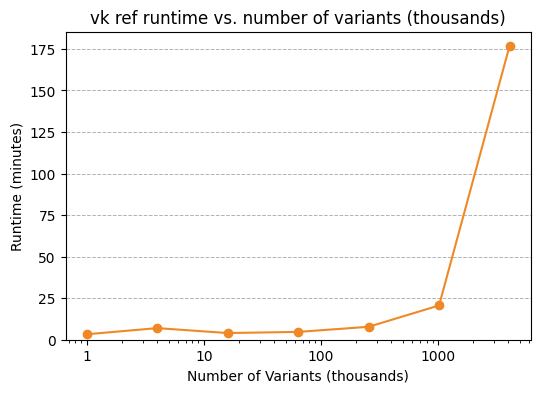

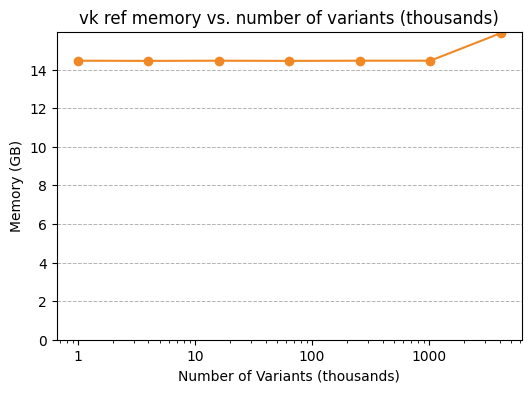

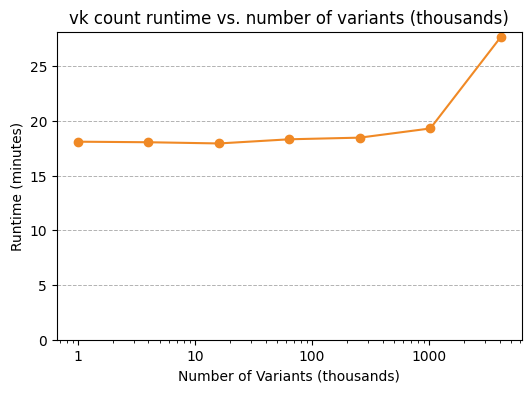

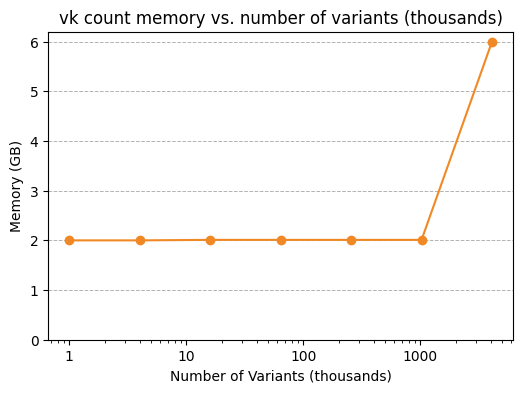

In [ ]:
from RLSRWP_2025.visualization_utils import plot_time_and_memory_benchmarking

plot_time_and_memory_benchmarking(time_and_memory_df_index_ref, metric_name = "Runtime", units="minutes", log_x=True, title="vk ref runtime vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/runtime_benchmarking_index_vk_ref.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_ref, metric_name = "Memory", units="GB", log_x=True, title="vk ref memory vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/memory_benchmarking_index_vk_ref.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_count, metric_name = "Runtime", units="minutes", log_x=True, title="vk count runtime vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/runtime_benchmarking_index_vk_count.pdf")
plot_time_and_memory_benchmarking(time_and_memory_df_index_count, metric_name = "Memory", units="GB", log_x=True, title="vk count memory vs. number of variants (thousands)", x_col="Variants", x_col_units="thousands", y_col="Value", y_min=0, output_file = f"{fig3_output_dir}/memory_benchmarking_index_vk_count.pdf")